In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle

print('Numpy version:', np.__version__)
print('Pandas version:', pd.__version__)

Numpy version: 1.20.3
Pandas version: 1.3.4


In [2]:
import sklearn as sk
sk.__version__

'0.24.2'

In [3]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

import dataset

In [ ]:
data_train = pd.read_excel(r'E:/R code-LMX/R code for SEER-Bone metastasis-LYS/Data/start0.9-number.xlsx')
data_test = pd.read_excel(r'E:/R code-LMX/R code for SEER-Bone metastasis-LYS/Data/starv0.1-number.xlsx')

In [7]:
pd.set_option('display.max_columns', data_train.shape[1])
pd.set_option('max_colwidth', 1000)

In [8]:
data_train.head()

Unnamed: 0  X.1       X  Rural.urban  Patient.ID  Marital.status  Age  \
0           1    2  113150            1        2557               2   72   
1           2    3   51311            1        3273               4   61   
2           3    4  147754            1        3391               1   79   
3           4    7  174575            1        5086               2   87   
4           5    8   96471            1        5234               4   69   

   Race             Sequence.number  \
0     2  2nd of 2 or more primaries   
1     1  2nd of 2 or more primaries   
2     4  3rd of 3 or more primaries   
3     4  4th of 4 or more primaries   
4     4  2nd of 2 or more primaries   

   Total.number.of.in.situ.malignant.tumors.for.patient  \
0                                                     2   
1                                                     2   
2                                                     3   
3                                                     4   
4                                                     2   

   Total.number.of.benign.borderline.tumors.for.patient  \
0                                                     0   
1                                                     0   
2                                                     0   
3                                                     0   
4                                                     0   

  SEER.cause.specific.death.classification  \
0    Dead (attributable to this cancer dx)   
1    Dead (attributable to this cancer dx)   
2    Dead (attributable to this cancer dx)   
3    Dead (attributable to this cancer dx)   
4    Dead (attributable to this cancer dx)   

  SEER.other.cause.of.death.classification  Survival.months  \
0              Alive or dead due to cancer                7   
1              Alive or dead due to cancer               10   
2              Alive or dead due to cancer                1   
3              Alive or dead due to cancer                4   
4              Alive or dead due to cancer               21   

   Threemonthmortality  Censor  \
0                    0       1   
1                    0       1   
2                    1       1   
3                    0       1   
4                    0       1   

                                                      Survival.months.flag  \
0  Complete dates are available and there are more than 0 days of survival   
1  Complete dates are available and there are more than 0 days of survival   
2  Complete dates are available and there are more than 0 days of survival   
3  Complete dates are available and there are more than 0 days of survival   
4  Complete dates are available and there are more than 0 days of survival   

  Vital.status.recode..study.cutoff.used. EOD.Primary.Tumor..2018..  \
0                                    Dead                  Blank(s)   
1                                    Dead                  Blank(s)   
2                                    Dead                  Blank(s)   
3                                    Dead                  Blank(s)   
4                                    Dead                  Blank(s)   

  Tumor.Size.Summary..2016.. SEER.Combined.Mets.at.DX.bone..2010..  Brain.m  \
0                   Blank(s)                                   Yes        1   
1                   Blank(s)                                   Yes        3   
2                   Blank(s)                                   Yes        1   
3                   Blank(s)                                   Yes        1   
4                   Blank(s)                                   Yes        1   

   Liver.m  Lung.m  Regional.nodes.positive..1988..  \
0        1       1                               98   
1        3       1                                0   
2        1       1                               98   
3        1       1                               98   
4        1       1                               98   

  Mets.at.DX.Distant.LN..2016.. Breast

In [9]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106492 entries, 0 to 106491
Data columns (total 62 columns):
 #   Column                                                 Non-Null Count   Dtype 
---  ------                                                 --------------   ----- 
 0   Unnamed: 0                                             106492 non-null  int64 
 1   X.1                                                    106492 non-null  int64 
 2   X                                                      106492 non-null  int64 
 3   Rural.urban                                            106492 non-null  int64 
 4   Patient.ID                                             106492 non-null  int64 
 5   Marital.status                                         106492 non-null  int64 
 6   Age                                                    106492 non-null  int64 
 7   Race                                                   106492 non-null  int64 
 8   Sequence.number                             

Data preprocessing piprlines
Prepare the data to a format that can be fit into scikit learn algorithms

Categorical variable encoder

In [10]:
categorical_vars = [
"Sex",
"Race",
"Primary.site",
"Marital.status",
"Rural.urban",
"Tstage",
"Nstage",
"Brain.m",
"Liver.m",
"Lung.m",
"Cancer.directed.surgery",
"Radiation",
"Chemotherapy"]

In [11]:
data_train[categorical_vars].head()

Sex  Race  Primary.site  Marital.status  Rural.urban  Tstage  Nstage  \
0    1     2             3               2            1       5       3   
1    2     1             3               4            1       5       3   
2    2     4             3               1            1       4       4   
3    2     4             1               2            1       3       1   
4    2     4             1               4            1       6       5   

   Brain.m  Liver.m  Lung.m  Cancer.directed.surgery  Radiation  Chemotherapy  
0        1        1       1                        1          2             2  
1        3        3       1                        1          2             2  
2        1        1       1                        1          1             1  
3        1        1       1                        1          1             1  
4        1        1       1                        1          1             1

In [12]:
# to make a custom transformer to fit into a pipeline
class Vars_selector(BaseEstimator, TransformerMixin):
    '''Returns a subset of variables in a dataframe'''
    def __init__(self, var_names):
        '''var_names is a list of categorical variables names'''
        self.var_names = var_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        '''returns a dataframe with selected variables'''
        return X[self.var_names]

In [13]:
class Cat_vars_encoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        '''X is a dataframe'''

        return X.values

Transform data in a pipeline

In [14]:
# categorical variables preprocessing
cat_vars_pipeline = Pipeline([
    ('selector', Vars_selector(categorical_vars)),
    ('encoder', Cat_vars_encoder())
])

For many machine learning algorithms, gradient descent is the preferred or even the only optimization method to learn the model parameters. Gradient descent is highly sensitive to feature scaling.

** Continuous vars **

In [15]:
continuous_vars = ['Age']

In [16]:
data_train[continuous_vars].describe()

Age
count  106492.000000
mean       67.091124
std        12.400931
min        18.000000
25%        59.000000
50%        67.000000
75%        76.000000
max       100.000000

The scales among the continuous variables vary a lot, we need to standardize them prior to modelling.

In [17]:
# continuous variables preprocessing
cont_vars_pipeline = Pipeline([
    ('selector', Vars_selector(continuous_vars)),
    ('standardizer', StandardScaler())
])

To transform the two types of variables in one step

In [18]:
preproc_pipeline = FeatureUnion(transformer_list=[
    ('cat_pipeline', cat_vars_pipeline),
    ('cont_pipeline', cont_vars_pipeline)
])

In [19]:
data_train_X = pd.DataFrame(preproc_pipeline.fit_transform(data_train), 
                            columns=categorical_vars + continuous_vars)

In [20]:
data_train_X.head()

Sex  Race  Primary.site  Marital.status  Rural.urban  Tstage  Nstage  \
0  1.0   2.0           3.0             2.0          1.0     5.0     3.0   
1  2.0   1.0           3.0             4.0          1.0     5.0     3.0   
2  2.0   4.0           3.0             1.0          1.0     4.0     4.0   
3  2.0   4.0           1.0             2.0          1.0     3.0     1.0   
4  2.0   4.0           1.0             4.0          1.0     6.0     5.0   

   Brain.m  Liver.m  Lung.m  Cancer.directed.surgery  Radiation  Chemotherapy  \
0      1.0      1.0     1.0                      1.0        2.0           2.0   
1      3.0      3.0     1.0                      1.0        2.0           2.0   
2      1.0      1.0     1.0                      1.0        1.0           1.0   
3      1.0      1.0     1.0                      1.0        1.0           1.0   
4      1.0      1.0     1.0                      1.0        1.0           1.0   

        Age  
0  0.395849  
1 -0.491185  
2  0.960326  
3  1.605441  
4  0.153931

Fitting classifiers

In [21]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import learning_curve, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score

In [23]:
data_train['Threemonthmortality'].value_counts()

0    67451
1    39041
Name: Threemonthmortality, dtype: int64

This is a fairly balanced dataset(i.e., the number of positive and negative cases are roughly the same), and we'll use AUC as our metric to optimise the model performance.

Assessing learning curve using the model default settings
Tuning the model hyper-parameters are always difficult, so a good starting point is to see how the Scikit-learn default settings for the model performs, i.e., to see if it overfits or underfits, or is just right. This will give a good indication as to the direction of tuning.

In [24]:
def plot_learning_curves(model, X, y):
    train_sizes, train_scores, val_scores = learning_curve(model, X, y, cv=5, scoring='roc_auc',
                                                           random_state=42, n_jobs=-1)
    plt.plot(train_sizes, np.mean(train_scores, axis=1), "o-", label="training scores")
    plt.plot(train_sizes, np.mean(val_scores, axis=1), "o-", label="x-val scores")
    plt.legend(fontsize=14).get_frame().set_facecolor('white')
    plt.xlabel("Training set size")
    plt.ylabel("Area under Curve")
    plt.title('{} learning curve'.format(model.__class__.__name__))

# Compute and compare test metrics
Transform test data set

In [25]:
data_test_X = pd.DataFrame(preproc_pipeline.transform(data_test), # it's imperative not to do fit_transfomr again
                           columns=categorical_vars + continuous_vars)

In [26]:
data_test_X.shape

(11735, 14)

In [27]:
data_test_X.head()

Sex  Race  Primary.site  Marital.status  Rural.urban  Tstage  Nstage  \
0  2.0   1.0           3.0             2.0          1.0     6.0     5.0   
1  1.0   4.0           3.0             7.0          1.0     6.0     1.0   
2  2.0   4.0           3.0             2.0          1.0     4.0     2.0   
3  2.0   4.0           3.0             1.0          1.0     3.0     1.0   
4  1.0   4.0           3.0             4.0          1.0     3.0     3.0   

   Brain.m  Liver.m  Lung.m  Cancer.directed.surgery  Radiation  Chemotherapy  \
0      1.0      1.0     1.0                      1.0        1.0           2.0   
1      1.0      3.0     2.0                      1.0        1.0           1.0   
2      1.0      3.0     1.0                      1.0        1.0           2.0   
3      1.0      1.0     1.0                      1.0        2.0           2.0   
4      3.0      1.0     3.0                      1.0        2.0           1.0   

        Age  
0  0.073291  
1  1.282884  
2  0.476489  
3  1.363523  
4  0.718407

In [28]:
def plot_roc_curve(fpr, tpr, auc, model=None):
    if model == None:
        title = None
    elif isinstance(model, str):
        title = model
    else:
        title = model.__class__.__name__
#    title = None if model == None else model.__class__.__name__
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, linewidth=2, label='auc: {}'.format(auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-.01, 1.01, -.01, 1.01])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.legend(fontsize=14).get_frame().set_facecolor('white')
    plt.title('{} - ROC Curve'.format(title))

# Logistic Regression---网格搜索模型调参GridSearchCV

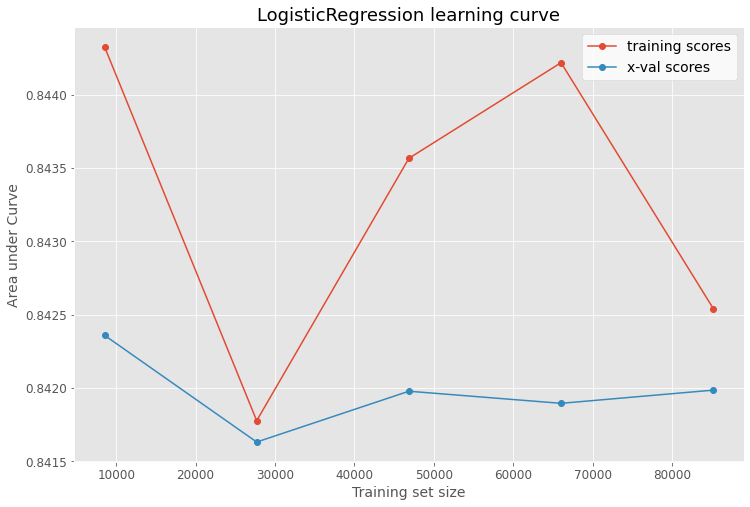

In [29]:
lr_clf = LogisticRegression(n_jobs = -1)
plot_learning_curves(lr_clf, data_train_X, data_train['Threemonthmortality'])

Let's see if we can squeeze some more performance out by optimising C

In [31]:
param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    }
lr_clf = LogisticRegression(random_state=42)
grid_search = GridSearchCV(lr_clf, param_grid=param_grid, return_train_score=True,
                                cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(data_train_X, data_train['Threemonthmortality'])

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='roc_auc')

In [32]:
cv_rlt = grid_search.cv_results_
pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['mean_train_score'], cv_rlt["params"])), 
                    key=lambda x: x[0], reverse=True), columns=['X-val scores', 'Train scores', 'Params'])

X-val scores  Train scores        Params
0      0.842104      0.842662   {'C': 0.01}
1      0.841997      0.842556    {'C': 0.1}
2      0.841986      0.842544      {'C': 1}
3      0.841984      0.842543     {'C': 10}
4      0.841983      0.842543   {'C': 1000}
5      0.841982      0.842543    {'C': 100}
6      0.841830      0.842373  {'C': 0.001}

# Looks like C=100? is our best value.

下方with open,"wb",确实是保存了新的pkl模型文件，下一次使用该文件只需要直接调用即可

In [33]:
lr_clf = grid_search.best_estimator_
with open('E:/R code-LMX/R code for SEER-Bone metastasis-LYS/Models/lr_clf_final_round.pkl', 'wb') as f:
    pickle.dump(lr_clf, f)

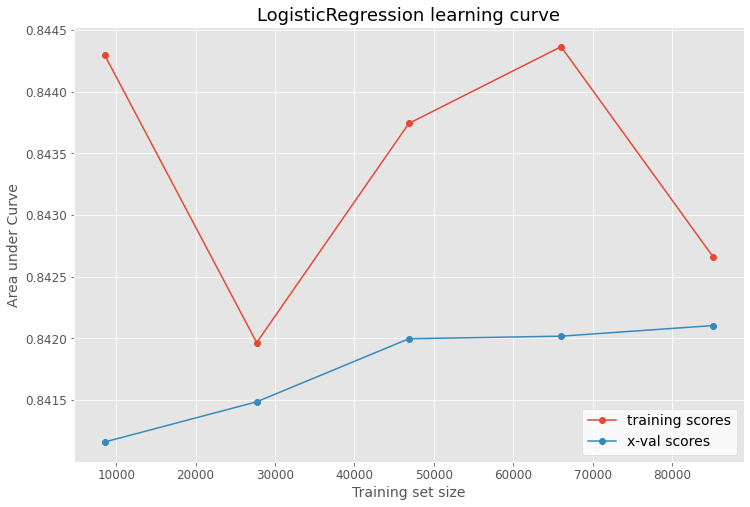

In [34]:
plot_learning_curves(lr_clf, data_train_X, data_train['Threemonthmortality'])

Looks like the logistic regression model would benefit from additional data.

# Logistic Regression model-ROC

In [35]:
# Import model and retrain
with open('E:/R code-LMX/R code for SEER-Bone metastasis-LYS/Models/lr_clf_final_round.pkl', 'rb') as f:
    lr_clf = pickle.load(f)
lr_clf.fit(data_train_X, data_train['Threemonthmortality'])

LogisticRegression(C=0.01, random_state=42)

Accuracy scores

In [36]:
accu_lr = accuracy_score(data_test['Threemonthmortality'], lr_clf.predict(data_test_X))

In [37]:
round(accu_lr,3)

0.806

In [38]:
pd.crosstab(data_test['Threemonthmortality'], lr_clf.predict(data_test_X))

col_0                   0     1
Threemonthmortality            
0                    6620   851
1                    1424  2840

In [39]:
pred_proba_lr = lr_clf.predict_proba(data_test_X)

In [40]:
fpr, tpr, _ = roc_curve(data_test['Threemonthmortality'], pred_proba_lr[:, 1])
auc_lr = roc_auc_score(data_test['Threemonthmortality'], pred_proba_lr[:, 1])

In [41]:
round(auc_lr,3)

0.845

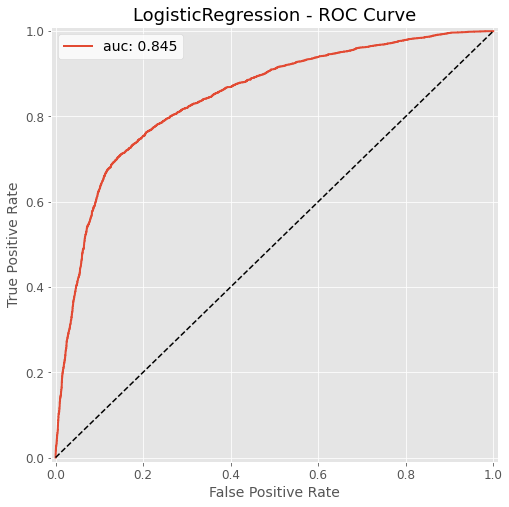

In [42]:
plot_roc_curve(fpr, tpr, round(auc_lr,3), lr_clf)

In [43]:
data_test['lr_pred_proba'] = pred_proba_lr[:, 1]

In [44]:
data_test.to_csv('E:/R code-LMX/R code for SEER-Bone metastasis-LYS/Models/test_set_with_predictions-lr.csv'.format(len(data_train)), index=False)

# XGboot

In [45]:
from xgboost.sklearn import XGBClassifier

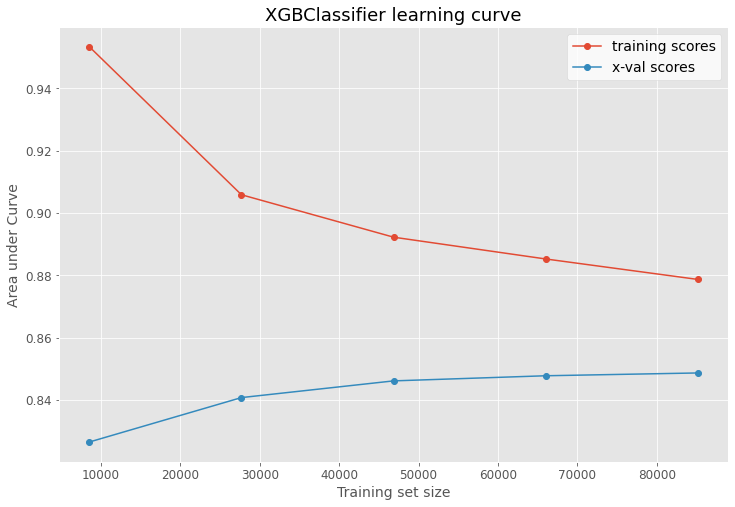

In [46]:
Xgbc_clf=XGBClassifier(random_state=42)  #Xgbc
plot_learning_curves(Xgbc_clf, data_train_X, data_train['Threemonthmortality'])

max_depth = 5 ：这应该在3-10之间。我从5开始，但你也可以选择不同的数字。4-6可以是很好的起点。
min_child_weight = 1 ：选择较小的值是因为它是高度不平衡的类问题，并且叶节点可以具有较小的大小组。
gamma = 0.1 ：也可以选择较小的值，如0.1-0.2来启动。无论如何，这将在以后进行调整。
subsample，colsample_bytree = 0.8：这是一个常用的使用起始值。典型值介于0.5-0.9之间。
scale_pos_weight = 1：由于高级别的不平衡。
colsample_bytree = 0.5,gamma=0.2

In [48]:
param_distribs = {
     'n_estimators': stats.randint(low=60, high=120),      
    'max_depth': stats.randint(low=1, high=10),
    'min_child_weight': stats.randint(low=1, high=10)
    }
Xgbc_clf=XGBClassifier(random_state=42,learning_rate=0.125,use_label_encoder=False)
Xgbc_search = RandomizedSearchCV(Xgbc_clf, param_distributions=param_distribs, return_train_score=True,
                                n_iter=100, cv=5, scoring='roc_auc', random_state=42, n_jobs=-1)
Xgbc_gs=Xgbc_search.fit(data_train_X, data_train['Threemonthmortality'])

[23:31:52] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [49]:
print(Xgbc_gs.best_score_)

0.8531454792414715


In [50]:
print(Xgbc_gs.best_params_)

{'max_depth': 4, 'min_child_weight': 9, 'n_estimators': 119}


In [51]:
cv_rlt = Xgbc_search.cv_results_
pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['mean_train_score'], cv_rlt["params"])), 
                    key=lambda x: x[0], reverse=True), columns=['X-val scores', 'Train scores', 'Params'])

X-val scores  Train scores  \
0       0.853145      0.859249   
1       0.853114      0.859298   
2       0.853099      0.859127   
3       0.853035      0.858287   
4       0.852982      0.858258   
..           ...           ...   
95      0.841871      0.842461   
96      0.841739      0.842355   
97      0.840552      0.841120   
98      0.839915      0.840587   
99      0.839381      0.840250   

                                                          Params  
0   {'max_depth': 4, 'min_child_weight': 9, 'n_estimators': 119}  
1   {'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 118}  
2   {'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 108}  
3    {'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 89}  
4    {'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 88}  
..                                                           ...  
95   {'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 78}  
96   {'max_depth': 1, 'min_child_weight': 8, 'n_estimators': 76}  
97   {'max_depth': 1, 'min_child_weight': 9, 'n_estimators': 66}  
98   {'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 61}  
99   {'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 60}  

[100 rows x 3 columns]

In [57]:
rf_clf = Xgbc_search.best_estimator_
rf_clf.fit(data_train_X, data_train['Threemonthmortality'])
with open('E:/R code-LMX/R code for SEER-Bone metastasis-LYS/Models/Xgbc_clf_final_round.pkl', 'wb') as f:
    pickle.dump(rf_clf, f)

[23:35:11] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [58]:
rf_clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.125, max_delta_step=0,
              max_depth=4, min_child_weight=9, missing=nan,
              monotone_constraints='()', n_estimators=119, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

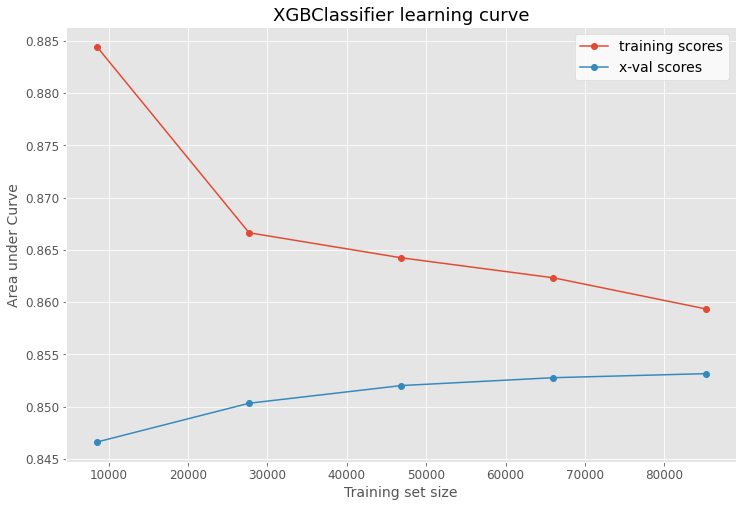

In [59]:
plot_learning_curves(rf_clf, data_train_X, data_train['Threemonthmortality'])

In [60]:
# Import model and retrain
with open('E:/R code-LMX/R code for SEER-Bone metastasis-LYS/Models/Xgbc_clf_final_round.pkl', 'rb') as f:
    Xgbc_clf = pickle.load(f)
Xgbc_clf.fit(data_train_X, data_train['Threemonthmortality'])

[23:36:06] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.125, max_delta_step=0,
              max_depth=4, min_child_weight=9, missing=nan,
              monotone_constraints='()', n_estimators=119, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [62]:
accu_Xgbc = accuracy_score(data_test['Threemonthmortality'], Xgbc_clf.predict(data_test_X))
round(accu_Xgbc,3)

0.808

In [63]:
pd.crosstab(data_test['Threemonthmortality'], Xgbc_clf.predict(data_test_X))

col_0                   0     1
Threemonthmortality            
0                    6597   874
1                    1378  2886

In [64]:
pred_proba_Xgbc = Xgbc_clf.predict_proba(data_test_X)

In [65]:
fpr, tpr, _ = roc_curve(data_test['Threemonthmortality'], pred_proba_Xgbc[:, 1])
auc_Xgbc = roc_auc_score(data_test['Threemonthmortality'], pred_proba_Xgbc[:, 1])
round(auc_Xgbc,3)

0.858

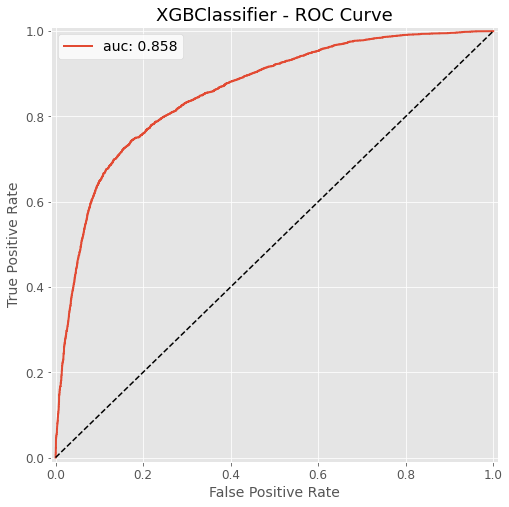

In [66]:
plot_roc_curve(fpr, tpr, round(auc_Xgbc,3), Xgbc_clf)

In [67]:
data_test['lr_pred_proba'] = pred_proba_Xgbc[:, 1]
data_test.to_csv('E:/R code-LMX/R code for SEER-Bone metastasis-LYS/Models/test_set_with_predictions-Xgbc.csv'.format(len(data_train)), index=False)

# DecisionTreeClassifier

In [68]:
from sklearn.tree import DecisionTreeClassifier

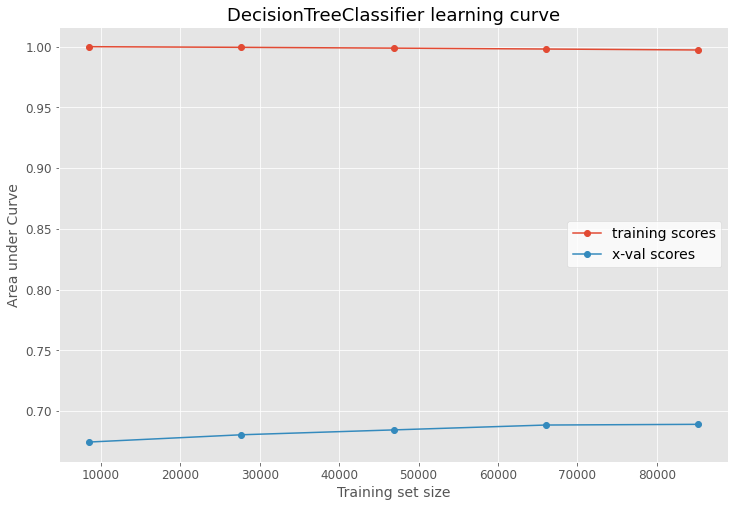

In [70]:
tr_clf=DecisionTreeClassifier(random_state=42)  # 决策树模型
plot_learning_curves(tr_clf, data_train_X, data_train['Threemonthmortality'])

In [79]:
param_distribs = {
         'max_features': ['auto', 'log2'],
        'max_depth': stats.randint(low=1, high=50),
        'min_samples_split': stats.randint(low=2, high=200), 
        'min_samples_leaf': stats.randint(low=2, high=200)
    }
dt_clf = DecisionTreeClassifier(random_state=42,criterion='gini', splitter='best')
rnd_search = RandomizedSearchCV(dt_clf, param_distributions=param_distribs, return_train_score=True,
                                n_iter=100, cv=5, scoring='roc_auc', random_state=42, n_jobs=-1)
gsdt=rnd_search.fit(data_train_X, data_train['Threemonthmortality'])

In [80]:
print(gsdt.best_score_)

0.8395005818988455


In [81]:
print(gsdt.best_params_)

{'max_depth': 42, 'max_features': 'log2', 'min_samples_leaf': 55, 'min_samples_split': 192}


In [82]:
cv_rlt = rnd_search.cv_results_
pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['mean_train_score'], cv_rlt["params"])), 
                    key=lambda x: x[0], reverse=True), columns=['X-val scores', 'Train scores', 'Params'])

X-val scores  Train scores  \
0       0.839501      0.850279   
1       0.838912      0.846383   
2       0.838843      0.852002   
3       0.838806      0.855844   
4       0.838308      0.847658   
..           ...           ...   
95      0.773667      0.774444   
96      0.773667      0.774444   
97      0.768222      0.768334   
98      0.651306      0.651253   
99      0.572290      0.572290   

                                                                                         Params  
0   {'max_depth': 42, 'max_features': 'log2', 'min_samples_leaf': 55, 'min_samples_split': 192}  
1   {'max_depth': 33, 'max_features': 'auto', 'min_samples_leaf': 122, 'min_samples_split': 28}  
2   {'max_depth': 44, 'max_features': 'log2', 'min_samples_leaf': 31, 'min_samples_split': 191}  
3    {'max_depth': 43, 'max_features': 'auto', 'min_samples_leaf': 37, 'min_samples_split': 14}  
4   {'max_depth': 35, 'max_features': 'log2', 'min_samples_leaf': 82, 'min_samples_split': 165}  
..                                                                                          ...  
95    {'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 61, 'min_samples_split': 15}  
96  {'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 152, 'min_samples_split': 144}  
97   {'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 52, 'min_samples_split': 136}  
98  {'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 173, 'min_samples_split': 161}  
99  {'max_depth': 1, 'max_features': 'auto', 'min_samples_leaf': 143, 'min_samples_split': 104}  

[100 rows x 3 columns]

In [83]:
dt_clf = rnd_search.best_estimator_
dt_clf.fit(data_train_X, data_train['Threemonthmortality'])
with open('E:/R code-LMX/R code for SEER-Bone metastasis-LYS/Models/dt_clf_final_round.pkl', 'wb') as f:
    pickle.dump(dt_clf, f)

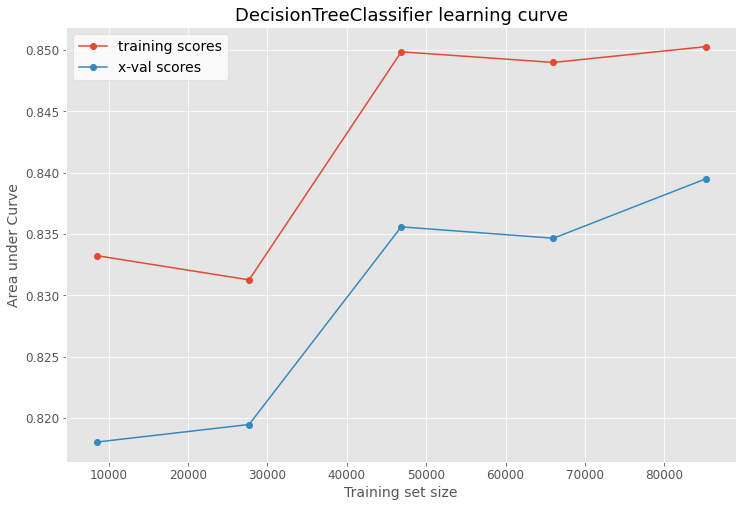

In [84]:
plot_learning_curves(dt_clf, data_train_X, data_train['Threemonthmortality'])

In [86]:
# Import model and retrain
with open('E:/R code-LMX/R code for SEER-Bone metastasis-LYS/Models/dt_clf_final_round.pkl', 'rb') as f:
    dt_clf = pickle.load(f)
dt_clf.fit(data_train_X, data_train['Threemonthmortality'])

DecisionTreeClassifier(max_depth=42, max_features='log2', min_samples_leaf=55,
                       min_samples_split=192, random_state=42)

In [87]:
accu_dt = accuracy_score(data_test['Threemonthmortality'], dt_clf.predict(data_test_X))
round(accu_dt,3)

0.775

In [89]:
pd.crosstab(data_test['Threemonthmortality'], dt_clf.predict(data_test_X))

col_0                   0     1
Threemonthmortality            
0                    6431  1040
1                    1600  2664

In [90]:
pred_proba_dt = dt_clf.predict_proba(data_test_X)
fpr, tpr, _ = roc_curve(data_test['Threemonthmortality'], pred_proba_dt[:, 1])
auc_dt = roc_auc_score(data_test['Threemonthmortality'], pred_proba_dt[:, 1])
round(auc_dt,3)

0.83

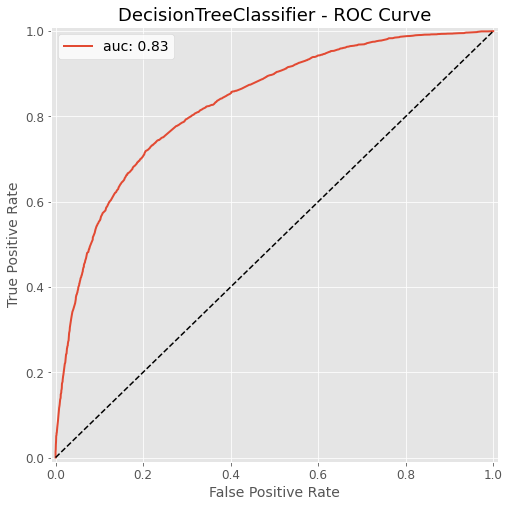

In [91]:
plot_roc_curve(fpr, tpr, round(auc_dt,3), dt_clf)

In [92]:
data_test['lr_pred_proba'] = pred_proba_dt[:, 1]

In [93]:
data_test.to_csv('E:/R code-LMX/R code for SEER-Bone metastasis-LYS/Models/test_set_with_predictions-decision tree.csv'.format(len(data_train)), index=False)

# Random Forests classifier---随机搜索模型调参RandomizedSearchCV
Random forests classifier is an ensemble tree-based model that reduces the variance of the predictors.

plot the learning curve to find out where the default model is at

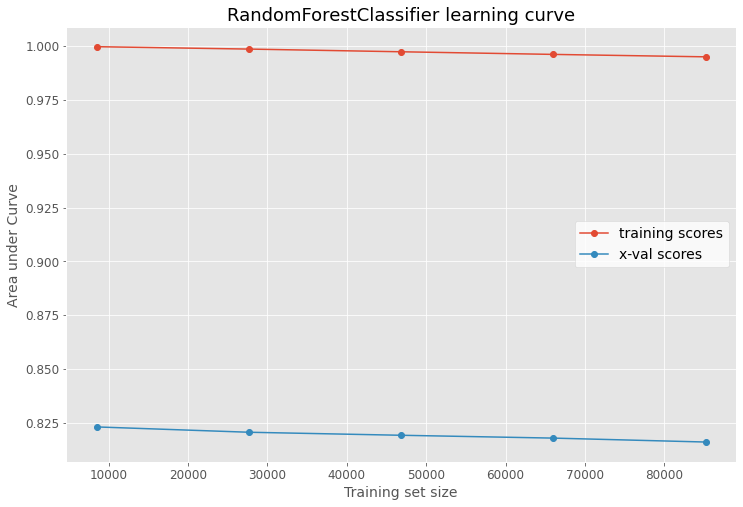

In [94]:
rf_clf = RandomForestClassifier(random_state=42)
plot_learning_curves(rf_clf, data_train_X, data_train['Threemonthmortality'])

In [95]:
param_distribs = {
        'n_estimators': stats.randint(low=1, high=50),
         'max_features': ['auto', 'log2'],
        'max_depth': stats.randint(low=1, high=100),
        'min_samples_split': stats.randint(low=2, high=200), 
        'min_samples_leaf': stats.randint(low=2, high=200)
    }
rf_clf = RandomForestClassifier(random_state=42)
rnd_search = RandomizedSearchCV(rf_clf, param_distributions=param_distribs, return_train_score=True,
                                n_iter=100, cv=5, scoring='roc_auc', random_state=42, n_jobs=-1)
gs=rnd_search.fit(data_train_X, data_train['Threemonthmortality'])

In [96]:
print(gs.best_score_)

0.8522737149021322


In [97]:
print(gs.best_params_)

{'max_depth': 51, 'max_features': 'auto', 'min_samples_leaf': 22, 'min_samples_split': 74, 'n_estimators': 39}


In [98]:
cv_rlt = rnd_search.cv_results_
pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['mean_train_score'], cv_rlt["params"])), 
                    key=lambda x: x[0], reverse=True), columns=['X-val scores', 'Train scores', 'Params'])

X-val scores  Train scores  \
0       0.852274      0.869549   
1       0.851906      0.861830   
2       0.851850      0.861640   
3       0.851812      0.860952   
4       0.851652      0.871738   
..           ...           ...   
95      0.838063      0.842978   
96      0.835710      0.838936   
97      0.833987      0.834348   
98      0.827200      0.843968   
99      0.818837      0.841336   

                                                                                                             Params  
0    {'max_depth': 51, 'max_features': 'auto', 'min_samples_leaf': 22, 'min_samples_split': 74, 'n_estimators': 39}  
1   {'max_depth': 19, 'max_features': 'log2', 'min_samples_leaf': 36, 'min_samples_split': 193, 'n_estimators': 49}  
2    {'max_depth': 97, 'max_features': 'log2', 'min_samples_leaf': 54, 'min_samples_split': 61, 'n_estimators': 44}  
3   {'max_depth': 96, 'max_features': 'auto', 'min_samples_leaf': 53, 'min_samples_split': 162, 'n_estimators': 40}  
4    {'max_depth': 27, 'max_features': 'auto', 'min_samples_leaf': 22, 'min_samples_split': 31, 'n_estimators': 33}  
..                                                                                                              ...  
95  {'max_depth': 96, 'max_features': 'auto', 'min_samples_leaf': 130, 'min_samples_split': 148, 'n_estimators': 2}  
96  {'max_depth': 56, 'max_features': 'auto', 'min_samples_leaf': 188, 'min_samples_split': 114, 'n_estimators': 2}  
97  {'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 141, 'min_samples_split': 198, 'n_estimators': 37}  
98    {'max_depth': 89, 'max_features': 'auto', 'min_samples_leaf': 10, 'min_samples_split': 89, 'n_estimators': 1}  
99    {'max_depth': 41, 'max_features': 'auto', 'min_samples_leaf': 16, 'min_samples_split': 46, 'n_estimators': 1}  

[100 rows x 3 columns]

In [99]:
rf_clf = rnd_search.best_estimator_
rf_clf.fit(data_train_X, data_train['Threemonthmortality'])
with open('E:/R code-LMX/R code for SEER-Bone metastasis-LYS/Models/rf_clf_final_round.pkl', 'wb') as f:
    pickle.dump(rf_clf, f)

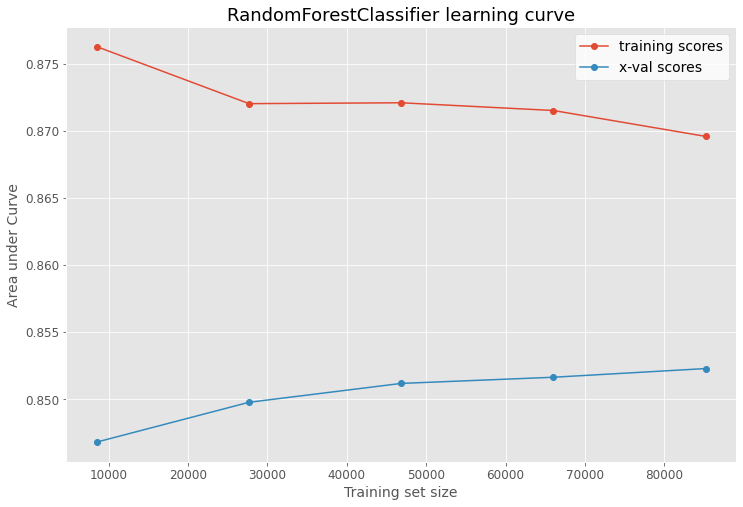

In [101]:
plot_learning_curves(rf_clf, data_train_X, data_train['Threemonthmortality'])

# Random forests model-ROC

In [102]:
# Import model and retrain
with open('E:/R code-LMX/R code for SEER-Bone metastasis-LYS/Models/rf_clf_final_round.pkl', 'rb') as f:
    rf_clf = pickle.load(f)
rf_clf.fit(data_train_X, data_train['Threemonthmortality'])

RandomForestClassifier(max_depth=51, min_samples_leaf=22, min_samples_split=74,
                       n_estimators=39, random_state=42)

Accuracy scores

In [103]:
accu_rf = accuracy_score(data_test['Threemonthmortality'], rf_clf.predict(data_test_X))

In [104]:
round(accu_rf,3)

0.808

In [105]:
pd.crosstab(data_test['Threemonthmortality'], rf_clf.predict(data_test_X))

col_0                   0     1
Threemonthmortality            
0                    6604   867
1                    1381  2883

ROC and AUC

In [106]:
pred_proba_rf = rf_clf.predict_proba(data_test_X)

In [107]:
fpr, tpr, _ = roc_curve(data_test['Threemonthmortality'], pred_proba_rf[:, 1])
auc_rf = roc_auc_score(data_test['Threemonthmortality'], pred_proba_rf[:, 1])

In [108]:
round(auc_rf,3)

0.856

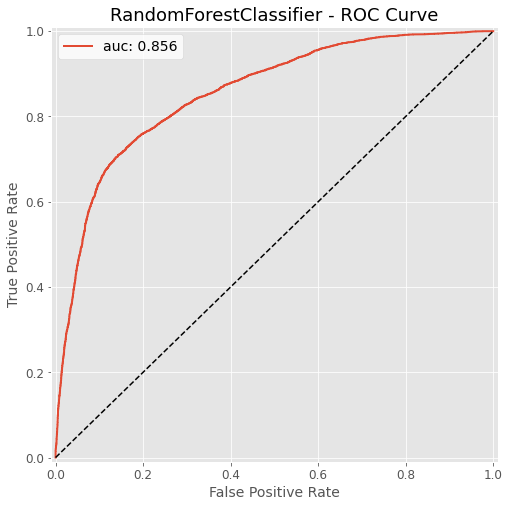

In [109]:
plot_roc_curve(fpr, tpr, round(auc_rf,3), rf_clf)

In [110]:
data_test['lr_pred_proba'] = pred_proba_rf[:, 1]

In [111]:
data_test.to_csv('E:/R code-LMX/R code for SEER-Bone metastasis-LYS/Models/test_set_with_predictions-Random forests model.csv'.format(len(data_train)), index=False)

# Neural Network

In [112]:
from sklearn.neural_network import MLPClassifier

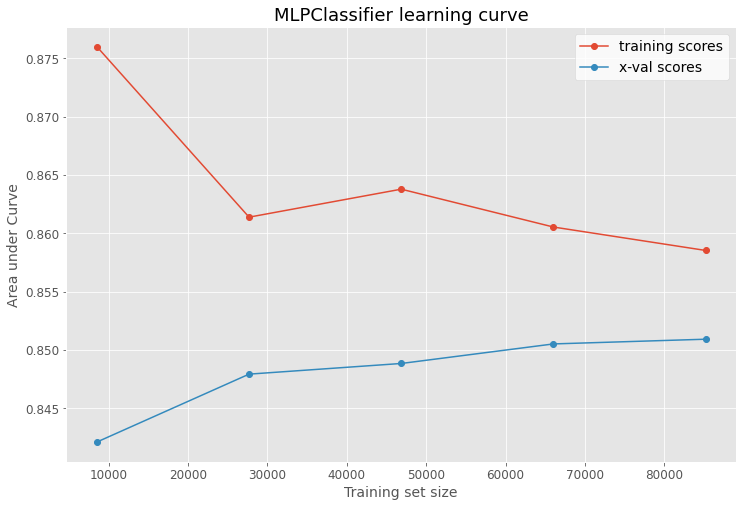

In [113]:
nn_clf = MLPClassifier(random_state=42)
plot_learning_curves(nn_clf, data_train_X, data_train['Threemonthmortality'])

In [114]:
nn_clf = MLPClassifier(random_state=42,activation='relu',alpha=0.0001,batch_size='auto',beta_1=0.9, beta_2=0.999, 
                       early_stopping=False,epsilon=1e-08,hidden_layer_sizes=(100),
                       learning_rate='constant', learning_rate_init=0.001,max_iter=200, momentum=0.9, 
                       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,shuffle=True,  
                       tol=0.0001, validation_fraction=0.1,verbose=False, warm_start=False)

In [115]:
nn_clf.fit(data_train_X, data_train['Threemonthmortality'])
nn_clf_y_pre=nn_clf.predict(data_test_X)
nn_clf_y_proba=nn_clf.predict_proba(data_test_X)

In [116]:
from sklearn.metrics import f1_score,precision_score,recall_score,roc_auc_score,accuracy_score,roc_curve

In [117]:
nn_clf_accuracy_score=accuracy_score(data_test['Threemonthmortality'],nn_clf_y_pre)
nn_clf_preci_score=precision_score(data_test['Threemonthmortality'],nn_clf_y_pre)
nn_clf_recall_score=recall_score(data_test['Threemonthmortality'],nn_clf_y_pre)
nn_clf_f1_score=f1_score(data_test['Threemonthmortality'],nn_clf_y_pre)
nn_clf_auc=roc_auc_score(data_test['Threemonthmortality'],nn_clf_y_proba[:,1])
print('nn_clf_accuracy_score: %f,nn_clf_preci_score: %f,nn_clf_recall_score: %f,nn_clf_f1_score: %f,nn_clf_auc: %f'
      %(nn_clf_accuracy_score,nn_clf_preci_score,nn_clf_recall_score,nn_clf_f1_score,nn_clf_auc))

nn_clf_accuracy_score: 0.808607,nn_clf_preci_score: 0.769210,nn_clf_recall_score: 0.676126,nn_clf_f1_score: 0.719670,nn_clf_auc: 0.856121


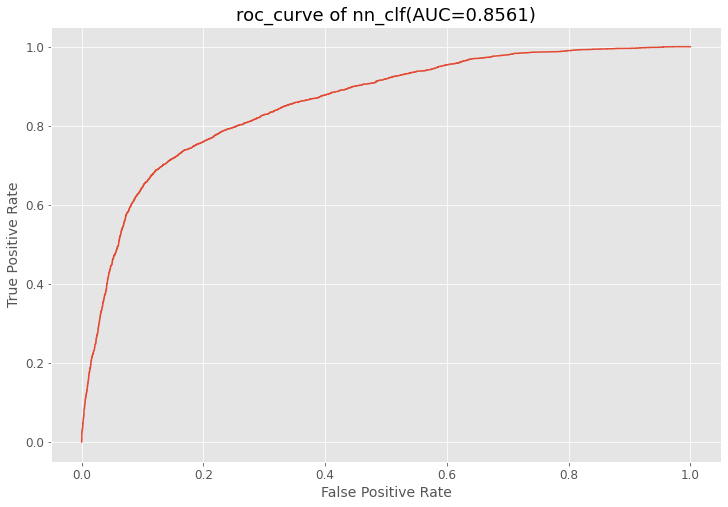

In [118]:
nn_clf_fpr,nn_clf_tpr,nn_clf_threasholds=roc_curve(data_test['Threemonthmortality'],nn_clf_y_proba[:,1]) # 计算ROC的值,svm_threasholds为阈值
plt.title("roc_curve of %s(AUC=%.4f)" %('nn_clf',nn_clf_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(nn_clf_fpr,nn_clf_tpr)
plt.show()

In [122]:
data_test['lr_pred_proba'] = nn_clf_y_proba[:,1]

In [123]:
data_test.to_csv('E:/R code-LMX/R code for SEER-Bone metastasis-LYS/Models/test_set_with_predictions-nn.csv'.format(len(data_train)), index=False)

In [124]:
fpr, tpr, _ = roc_curve(data_test['Threemonthmortality'], nn_clf_y_proba[:,1])
auc_nn = roc_auc_score(data_test['Threemonthmortality'], nn_clf_y_proba[:,1])

In [125]:
round(auc_nn,3)

0.856

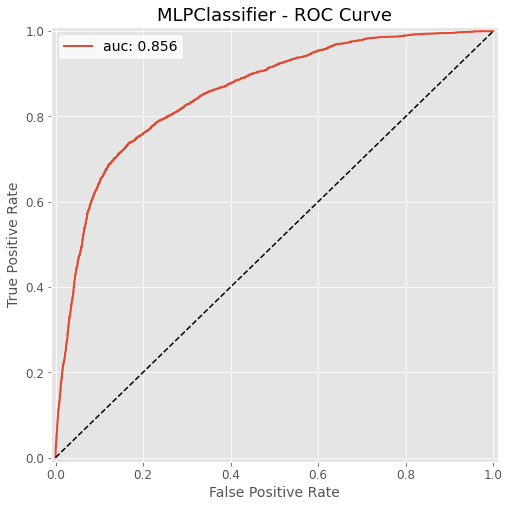

In [126]:
plot_roc_curve(fpr, tpr, round(auc_nn,3), nn_clf)

# Gradient boosting classifier---随机搜索模型调参RandomizedSearchCV
Gradient boosting classifier is an ensemble tree-based model that reduces the bias of the predictors.

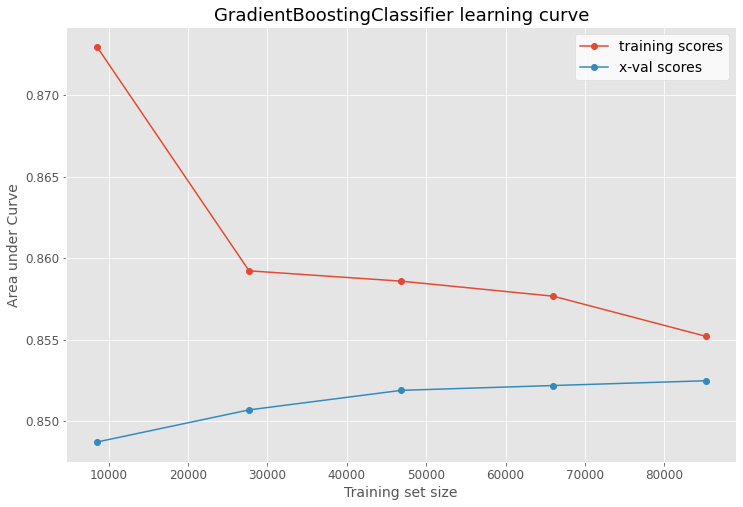

In [127]:
plot_learning_curves(GradientBoostingClassifier(random_state=42), data_train_X, data_train['Threemonthmortality'])

In [129]:

param_distribs = {
        'n_estimators': stats.randint(low=80, high=200),
         'max_features': ['auto', 'log2'],
        'max_depth': stats.randint(low=1, high=100),
        'min_samples_split': stats.randint(low=2, high=200), 
        'min_samples_leaf': stats.randint(low=2, high=200),
    }

rnd_search = RandomizedSearchCV(GradientBoostingClassifier(random_state=42), 
                                param_distributions=param_distribs, return_train_score=True,
                                n_iter=100, cv=5, scoring='roc_auc', random_state=42, n_jobs=-1)
# this will take a long time
gsgbm = rnd_search.fit(data_train_X, data_train['Threemonthmortality'])

In [130]:
print(gsgbm.best_score_)

0.8533125543286175


In [131]:
print(gsgbm.best_params_)

{'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 135, 'min_samples_split': 55, 'n_estimators': 185}


In [132]:
cv_rlt = rnd_search.cv_results_
pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['mean_train_score'], cv_rlt["params"])), 
                    key=lambda x: x[0], reverse=True), columns=['X-val scores', 'Train scores', 'Params'])

X-val scores  Train scores  \
0       0.853313      0.858130   
1       0.853282      0.857681   
2       0.853080      0.856681   
3       0.853028      0.858343   
4       0.853027      0.857689   
..           ...           ...   
95      0.825352      0.982128   
96      0.824060      0.983332   
97      0.817422      0.994115   
98      0.817083      0.994641   
99      0.799149      0.997189   

                                                                                                              Params  
0    {'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 135, 'min_samples_split': 55, 'n_estimators': 185}  
1   {'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 192, 'min_samples_split': 147, 'n_estimators': 169}  
2   {'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 152, 'min_samples_split': 144, 'n_estimators': 122}  
3      {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 42, 'min_samples_split': 29, 'n_estimators': 86}  
4     {'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 193, 'min_samples_split': 50, 'n_estimators': 96}  
..                                                                                                               ...  
95   {'max_depth': 51, 'max_features': 'auto', 'min_samples_leaf': 22, 'min_samples_split': 74, 'n_estimators': 118}  
96  {'max_depth': 52, 'max_features': 'auto', 'min_samples_leaf': 16, 'min_samples_split': 108, 'n_estimators': 151}  
97   {'max_depth': 41, 'max_features': 'auto', 'min_samples_leaf': 16, 'min_samples_split': 46, 'n_estimators': 144}  
98    {'max_depth': 60, 'max_features': 'auto', 'min_samples_leaf': 9, 'min_samples_split': 54, 'n_estimators': 139}  
99     {'max_depth': 78, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 169}  

[100 rows x 3 columns]

In [133]:
gbm_clf = rnd_search.best_estimator_
gbm_clf.fit(data_train_X, data_train['Threemonthmortality'])
with open('E:/R code-LMX/R code for SEER-Bone metastasis-LYS/Models/gbm_clf_final_round.pkl', 'wb') as f:
    pickle.dump(gbm_clf, f)

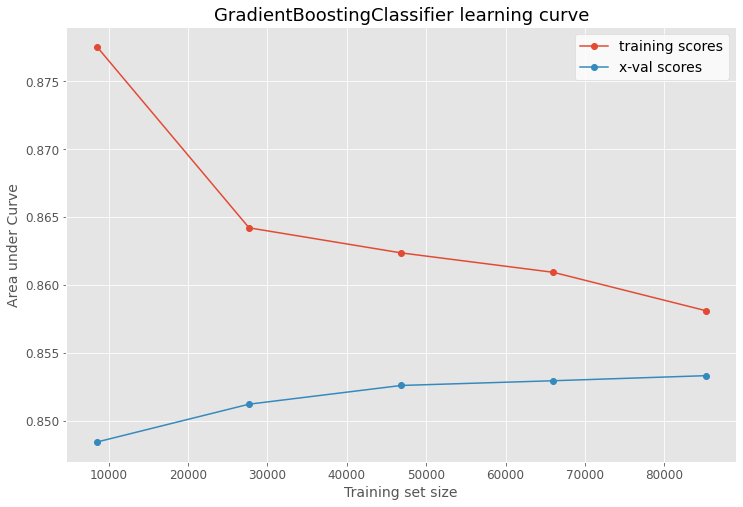

In [134]:
plot_learning_curves(gbm_clf, data_train_X, data_train['Threemonthmortality'])

# Gradient boosting machine model-ROC

In [135]:
# Import model and retrain
with open('E:/R code-LMX/R code for SEER-Bone metastasis-LYS/Models/gbm_clf_final_round.pkl', 'rb') as f:
    gbm_clf = pickle.load(f)
gbm_clf.fit(data_train_X, data_train['Threemonthmortality'])

GradientBoostingClassifier(max_depth=4, max_features='log2',
                           min_samples_leaf=135, min_samples_split=55,
                           n_estimators=185, random_state=42)

Accuracy scores

In [136]:
accu_gbm = accuracy_score(data_test['Threemonthmortality'], gbm_clf.predict(data_test_X))

In [137]:
round(accu_gbm,3)

0.808

In [138]:
pd.crosstab(data_test['Threemonthmortality'], gbm_clf.predict(data_test_X))

col_0                   0     1
Threemonthmortality            
0                    6580   891
1                    1367  2897

ROC and AUC

In [144]:
pred_proba_gbm = gbm_clf.predict_proba(data_train_X)
fpr, tpr, _ = roc_curve(data_train['Threemonthmortality'], pred_proba_gbm[:, 1])
auc_gbm = roc_auc_score(data_train['Threemonthmortality'], pred_proba_gbm[:, 1])

In [146]:
pred_proba_gbm = gbm_clf.predict_proba(data_test_X)

In [147]:
fpr, tpr, _ = roc_curve(data_test['Threemonthmortality'], pred_proba_gbm[:, 1])
auc_gbm = roc_auc_score(data_test['Threemonthmortality'], pred_proba_gbm[:, 1])

In [148]:
round(auc_gbm,3)

0.858

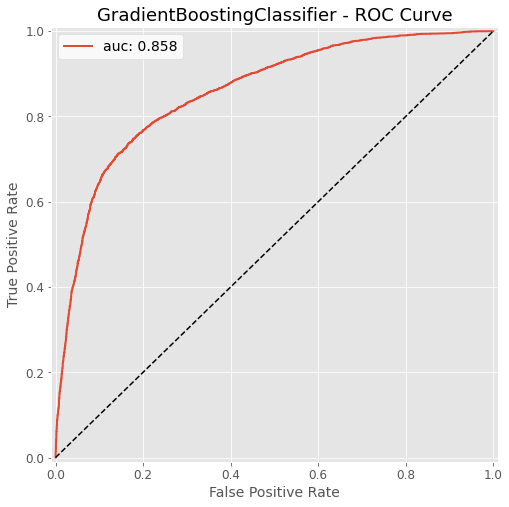

In [149]:
plot_roc_curve(fpr, tpr, round(auc_gbm,3), gbm_clf)

In [150]:
data_test['lr_pred_proba'] = pred_proba_gbm[:, 1]

In [151]:
data_test.to_csv('E:/R code-LMX/R code for SEER-Bone metastasis-LYS/Models/test_set_with_predictions-Gradient boosting machine model.csv'.format(len(data_train)), index=False)

# Support vector machine classifier---网格搜索模型调参GridSearchCV
Support vector machine classifier is a powerful classifier that works best on small to medium size complex data set. Our training set is medium size to SVMs.

plot the learning curve to find out where the default model is at

Try Linear SVC fist

In [1]:
plot_learning_curves(LinearSVC(loss='hinge', random_state=42), data_train_X, data_train['anxietyanddepression'])

NameError: name 'plot_learning_curves' is not defined

Try Polynomial kernel

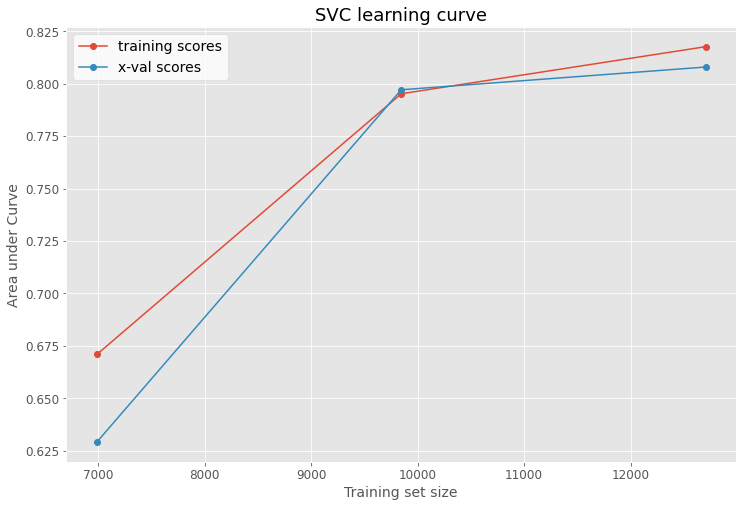

In [38]:
plot_learning_curves(SVC(kernel='poly', random_state=42), data_train_X, data_train['anxietyanddepression'])

Try Gaussian RBF kernel

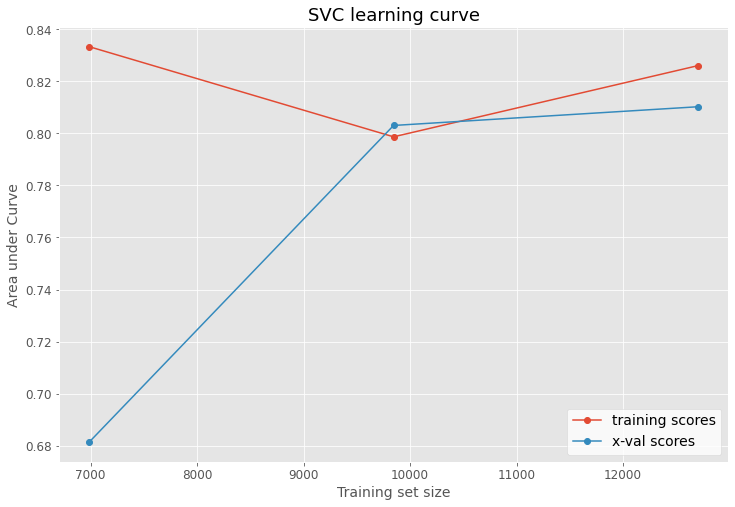

In [22]:
plot_learning_curves(SVC(random_state=42), data_train_X, data_train['anxietyanddepression'])

In [1]:
rbf_gamma = [1/len(data_train_X.columns) * x for x in range(1, 15, 5)]
param_grid = [
    # first try Poly kernel
    ## coef0 hyper-parameter was also tested originally, however, it is taking too long
    {'kernel':['poly'], 'degree': [3, 9, 15], 'C': [1, 3, 9]},
    # then try RBF kernel
    {'gamma': rbf_gamma, 'C': [1, 3, 9]},
  ]

grid_search = GridSearchCV(SVC(probability=True, random_state=42), param_grid, cv=5,
                           scoring='roc_auc', n_jobs=-1)

# this will take a long time
grid_search.fit(data_train_X, data_train['Threemonthmortality'])

NameError: name 'data_train_X' is not defined

In [ ]:
#cv_rlt = grid_search.cv_results_
#pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['mean_train_score'], cv_rlt["params"])), 
#                   key=lambda x: x[0], reverse=True), columns=['X-val scores', 'Train scores', 'Params'])

In [ ]:
svc_clf = grid_search.best_estimator_
svc_clf.fit(data_train_X, data_train['anxietyanddepression'])
with open('E:/R code-LMX/R code for SEER for publishing paper/Data/svc_clf_final_round.pkl', 'wb') as f:
    pickle.dump(svc_clf, f)

In [ ]:
# best model is the default RBF kernal SVM
plot_learning_curves(svc_clf, data_train_X, data_train['anxietyanddepression']) 

0. 不调参数(seer-lung cancer使用)

In [ ]:
svm = SVC(kernel='poly',probability=True,random_state=2018,tol=1e-6)  # SVM模型
svm.fit(data_train_X, data_train['Threemonthmortality'])
svm_y_pre=svm.predict(data_test_X)
svm_y_proba=svm.predict_proba(data_test_X)

In [172]:
from sklearn.metrics import f1_score,precision_score,recall_score,roc_auc_score,accuracy_score,roc_curve

In [173]:
svm_accuracy_score=accuracy_score(data_test['anxietyanddepression'],svm_y_pre)
svm_preci_score=precision_score(data_test['anxietyanddepression'],svm_y_pre)
svm_recall_score=recall_score(data_test['anxietyanddepression'],svm_y_pre)
svm_f1_score=f1_score(data_test['anxietyanddepression'],svm_y_pre)
svm_auc=roc_auc_score(data_test['anxietyanddepression'],svm_y_proba[:,1])
print('svm_accuracy_score: %f,svm_preci_score: %f,svm_recall_score: %f,svm_f1_score: %f,svm_auc: %f'
      %(svm_accuracy_score,svm_preci_score,svm_recall_score,svm_f1_score,svm_auc))

svm_accuracy_score: 0.845675,svm_preci_score: 0.725490,svm_recall_score: 0.251701,svm_f1_score: 0.373737,svm_auc: 0.740021


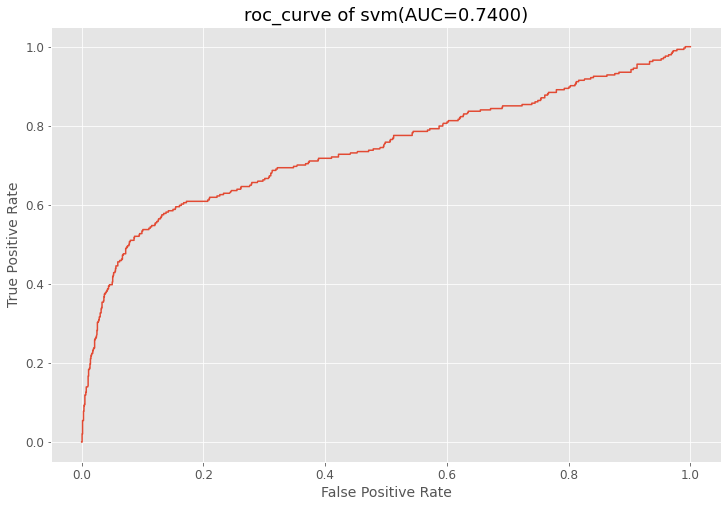

In [174]:
svm_fpr,svm_tpr,svm_threasholds=roc_curve(data_test['anxietyanddepression'],svm_y_proba[:,1]) # 计算ROC的值,svm_threasholds为阈值
plt.title("roc_curve of %s(AUC=%.4f)" %('svm',svm_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(svm_fpr,svm_tpr)
plt.show()

In [31]:
data_test['lr_pred_proba'] = svm_y_proba[:,1]

In [32]:
data_test.to_csv('E:/R code-LMX/R code for SEER for publishing paper/Data/test_set_with_predictions-Support vector machine model2.csv'.format(len(data_train)), index=False)

In [ ]:
svc_clf = grid.best_estimator_
#svc_clf.fit(data_train_X, data_train['anxietyanddepression'])
with open('E:/R code-LMX/R code for SEER for publishing paper/Data/svc_clf_final_round.pkl', 'wb') as f:
    pickle.dump(svc_clf, f)

第一调参

In [ ]:
hyperparameters = {
 'C': [0.1, 1, 100, 1000],
 'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5],
 'kernel': ('linear', 'rbf')
}
grid = GridSearchCV(
 estimator=SVC(probability=True),
 param_grid=hyperparameters,
 cv=5, return_train_score=True,
scoring='f1_micro', 
n_jobs=-1)
gssvm = grid.fit(data_train_X, data_train['anxietyanddepression'])

In [202]:
print(gssvm.best_score_)

NameError: name 'gssvm' is not defined

In [128]:
print(gssvm.best_params_)

{'C': 1, 'gamma': 3, 'kernel': 'rbf'}


In [129]:
cv_rlt = grid.cv_results_
pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['mean_train_score'], cv_rlt["params"])), 
                    key=lambda x: x[0], reverse=True), columns=['X-val scores', 'Train scores', 'Params'])

X-val scores  Train scores  \
0       0.921360      0.968478   
1       0.921360      0.968478   
2       0.921360      0.968478   
3       0.921360      0.968478   
4       0.921360      0.968478   
5       0.921360      0.968478   
6       0.919210      0.968478   
7       0.919210      0.968478   
8       0.915984      0.968478   
9       0.908416      0.966862   
10      0.901976      0.965784   
11      0.872787      0.883077   
12      0.872787      0.883077   
13      0.872787      0.883077   
14      0.872787      0.883077   
15      0.872787      0.883077   
16      0.872787      0.883077   
17      0.872787      0.883077   
18      0.853444      0.883613   
19      0.848056      0.901934   
20      0.845917      0.883074   
21      0.831921      0.886577   
22      0.824342      0.886579   
23      0.823319      0.886313   
24      0.823319      0.886313   
25      0.823319      0.886313   
26      0.823319      0.886313   
27      0.823319      0.886313   
28      0.823319      0.886313   
29      0.823319      0.886313   
30      0.822238      0.881463   
31      0.822238      0.881463   
32      0.822238      0.881463   
33      0.822238      0.881463   
34      0.822238      0.881463   
35      0.822238      0.881463   
36      0.822238      0.881463   
37      0.822185      0.849142   
38      0.819018      0.884690   
39      0.816856      0.877421   
40      0.816856      0.877421   
41      0.816856      0.877421   
42      0.816856      0.877421   
43      0.816856      0.877421   
44      0.816856      0.877421   
45      0.816856      0.877421   
46      0.815734      0.882006   
47      0.814688      0.902749   
48      0.814659      0.871230   
49      0.790950      0.790948   
50      0.790950      0.790948   
51      0.790950      0.790948   
52      0.790950      0.790948   
53      0.790950      0.790948   
54      0.784505      0.799033   
55      0.783435      0.812228   

                                              Params  
0              {'C': 1, 'gamma': 3, 'kernel': 'rbf'}  
1              {'C': 1, 'gamma': 5, 'kernel': 'rbf'}  
2            {'C': 100, 'gamma': 3, 'kernel': 'rbf'}  
3            {'C': 100, 'gamma': 5, 'kernel': 'rbf'}  
4           {'C': 1000, 'gamma': 3, 'kernel': 'rbf'}  
5           {'C': 1000, 'gamma': 5, 'kernel': 'rbf'}  
6            {'C': 100, 'gamma': 1, 'kernel': 'rbf'}  
7           {'C': 1000, 'gamma': 1, 'kernel': 'rbf'}  
8         {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}  
9              {'C': 1, 'gamma': 1, 'kernel': 'rbf'}  
10         {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}  
11   {'C': 0.1, 'gamma': 0.0001, 'kernel': 'linear'}  
12    {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}  
13    {'C': 0.1, 'gamma': 0.005, 'kernel': 'linear'}  
14      {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}  
15        {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}  
16        {'C': 0.1, 'gamma': 3, 'kernel': 'linear'}  
17        {'C': 0.1, 'gamma': 5, 'kernel': 'linear'}  
18     {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}  
19           {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}  
20       {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}  
21       {'C': 100, 'gamma': 0.005, 'kernel': 'rbf'}  
22           {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}  
23     {'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}  
24      {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}  
25      {'C': 1, 'gamma': 0.005, 'kernel': 'linear'}  
26        {'C': 1, 'gamma': 0.1, 'kernel': 'linear'}  
27          {'C': 1, 'gamma': 1, 'kernel': 'linear'}  
28          {'C': 1, 'gamma': 3, 'kernel': 'linear'}  
29          {'C': 1, 'gamma': 5, 'kernel': 'linear'}  
30   {'C': 100, 'gamma': 0.0001, 'kernel': 'linear'}  
31    {'C': 100, 'gamma': 0.001, 'kernel': 'linear'}  
32    {'C': 100, 'gamma': 0.005, 'kernel': 'linear'}  
33      {'C': 100, 'gamma': 0.1, 'kernel': 'linear'}  
34        {'C': 100, 'gamma': 1, 'kernel': 'linear'}  
35        {'C': 100, 'gamma': 3, 'kernel': 'linear'}  
36        {'C': 100, 'gamma': 

In [130]:
svc_clf = grid.best_estimator_
#svc_clf.fit(data_train_X, data_train['anxietyanddepression'])
with open('E:/R code-LMX/R code for SEER for publishing paper/Data/svc_clf_final_round.pkl', 'wb') as f:
    pickle.dump(svc_clf, f)

In [131]:
svc_clf

SVC(C=1, gamma=3, probability=True)

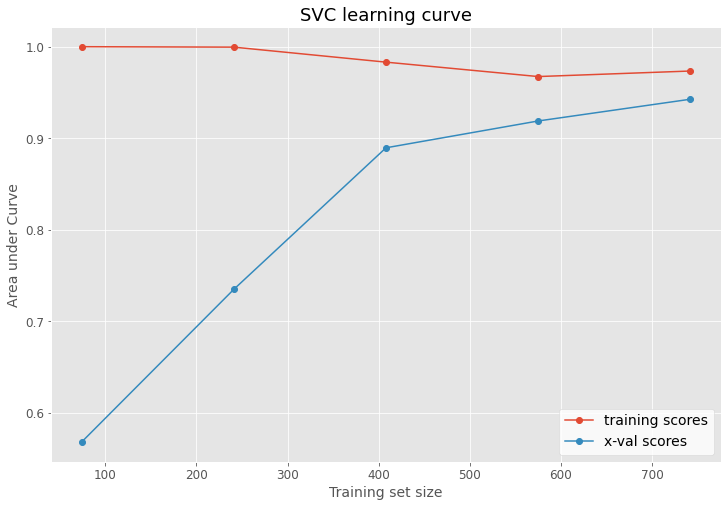

In [132]:
# best model is the default RBF kernal SVM
plot_learning_curves(svc_clf, data_train_X, data_train['anxietyanddepression']) 

第二调参

In [530]:
hyperparameters = {
 "C": stats.uniform(0.001, 0.1),
 "gamma": stats.uniform(0, 0.5),
 'kernel': ('linear', 'rbf')
}
random = RandomizedSearchCV(estimator = SVC(probability=True), param_distributions = hyperparameters, n_iter = 100, 
                            cv = 5, return_train_score=True, random_state=42, n_jobs = -1)
gssvm = random.fit(data_train_X, data_train['anxietyanddepression'])

In [531]:
print(gssvm.best_score_)

0.7833246516008877


In [532]:
print(gssvm.best_params_)

{'C': 0.03845401188473625, 'gamma': 0.4753571532049581, 'kernel': 'linear'}


In [533]:
cv_rlt = random.cv_results_
pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['mean_train_score'], cv_rlt["params"])), 
                    key=lambda x: x[0], reverse=True), columns=['X-val scores', 'Train scores', 'Params'])

X-val scores  Train scores  \
0       0.783325      0.783326   
1       0.783325      0.783216   
2       0.783325      0.783326   
3       0.783325      0.783326   
4       0.783325      0.783468   
..           ...           ...   
95      0.531957      0.537545   
96      0.517222      0.517222   
97      0.517222      0.517222   
98      0.517222      0.517222   
99      0.517222      0.517222   

                                                                             Params  
0       {'C': 0.03845401188473625, 'gamma': 0.4753571532049581, 'kernel': 'linear'}  
1        {'C': 0.016599452033620267, 'gamma': 0.02904180608409973, 'kernel': 'rbf'}  
2      {'C': 0.03437086111390219, 'gamma': 0.07143340896097039, 'kernel': 'linear'}  
3   {'C': 0.0017066305219717408, 'gamma': 0.011531212520707879, 'kernel': 'linear'}  
4         {'C': 0.06218528947223795, 'gamma': 0.06974693032602092, 'kernel': 'rbf'}  
..                                                                              ...  
95      {'C': 0.0024079822715084454, 'gamma': 0.09942120204440258, 'kernel': 'rbf'}  
96      {'C': 0.0030584494295802446, 'gamma': 0.48495492608099716, 'kernel': 'rbf'}  
97        {'C': 0.002326496115986653, 'gamma': 0.4711008778424264, 'kernel': 'rbf'}  
98        {'C': 0.004142918568673425, 'gamma': 0.3182052056318902, 'kernel': 'rbf'}  
99         {'C': 0.00468869473545328, 'gamma': 0.3047821669899484, 'kernel': 'rbf'}  

[100 rows x 3 columns]

In [536]:
svc_clf = random.best_estimator_
#svc_clf.fit(data_train_X, data_train['anxietyanddepression'])
with open('E:/R code-LMX/R code for SEER for publishing paper/Data/svc_clf_final_round.pkl', 'wb') as f:
    pickle.dump(svc_clf, f)

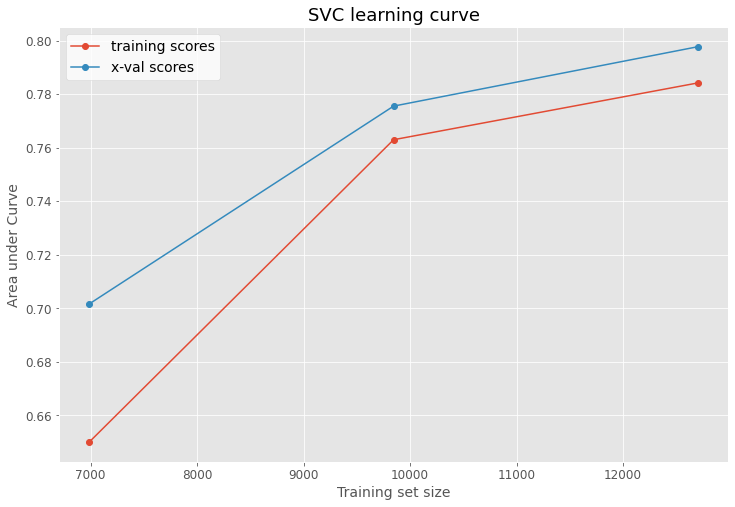

In [535]:
# best model is the default RBF kernal SVM
plot_learning_curves(svc_clf, data_train_X, data_train['anxietyanddepression']) 

第三调参--不用

In [94]:
rbf_gamma = [1/len(data_train_X.columns) * x for x in range(1, 15, 5)]
param_grid = [
    # first try Poly kernel
    ## coef0 hyper-parameter was also tested originally, however, it is taking too long
    {'kernel':['poly'], 'degree': [3, 9, 15], 'C': [1, 3, 9]},
    # then try RBF kernel
    {'gamma': rbf_gamma, 'C': [1, 3, 9]},
  ]

grid_search = GridSearchCV(SVC(probability=True, random_state=42), param_grid, cv=5,
                           scoring='roc_auc', n_jobs=-1)

# this will take a long time
grid_search.fit(data_train_X, data_train['anxietyanddepression'])

GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid=[{'C': [1, 3, 9], 'degree': [3, 9, 15],
                          'kernel': ['poly']},
                         {'C': [1, 3, 9], 'gamma': [0.125, 0.75, 1.375]}],
             scoring='roc_auc')

In [95]:
cv_rlt = grid_search.cv_results_
pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['mean_train_score'], cv_rlt["params"])), 
                    key=lambda x: x[0], reverse=True), columns=['X-val scores', 'Train scores', 'Params'])

KeyError: 'mean_train_score'

In [96]:
cv_rlt = grid_search.cv_results_
pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"],  cv_rlt["params"])), 
                    key=lambda x: x[0], reverse=True), columns=['X-val scores',  'Params'])

X-val scores                                    Params
0       0.961052                   {'C': 1, 'gamma': 0.75}
1       0.956496                   {'C': 9, 'gamma': 0.75}
2       0.949324                   {'C': 3, 'gamma': 0.75}
3       0.938164                  {'C': 3, 'gamma': 1.375}
4       0.933895                  {'C': 9, 'gamma': 1.375}
5       0.933816                  {'C': 1, 'gamma': 1.375}
6       0.923271                  {'C': 9, 'gamma': 0.125}
7       0.920932  {'C': 3, 'degree': 15, 'kernel': 'poly'}
8       0.916793                  {'C': 3, 'gamma': 0.125}
9       0.911861  {'C': 1, 'degree': 15, 'kernel': 'poly'}
10      0.906979  {'C': 9, 'degree': 15, 'kernel': 'poly'}
11      0.899773   {'C': 9, 'degree': 9, 'kernel': 'poly'}
12      0.898281                  {'C': 1, 'gamma': 0.125}
13      0.898042   {'C': 3, 'degree': 9, 'kernel': 'poly'}
14      0.894175   {'C': 1, 'degree': 3, 'kernel': 'poly'}
15      0.892699   {'C': 1, 'degree': 9, 'kernel': 'poly'}
16      0.890164   {'C': 9, 'degree': 3, 'kernel': 'poly'}
17      0.885599   {'C': 3, 'degree': 3, 'kernel': 'poly'}

In [97]:
svc_clf = grid_search.best_estimator_
svc_clf.fit(data_train_X, data_train['anxietyanddepression'])
with open('E:/svc_clf_final_round.pkl', 'wb') as f:
    pickle.dump(svc_clf, f)

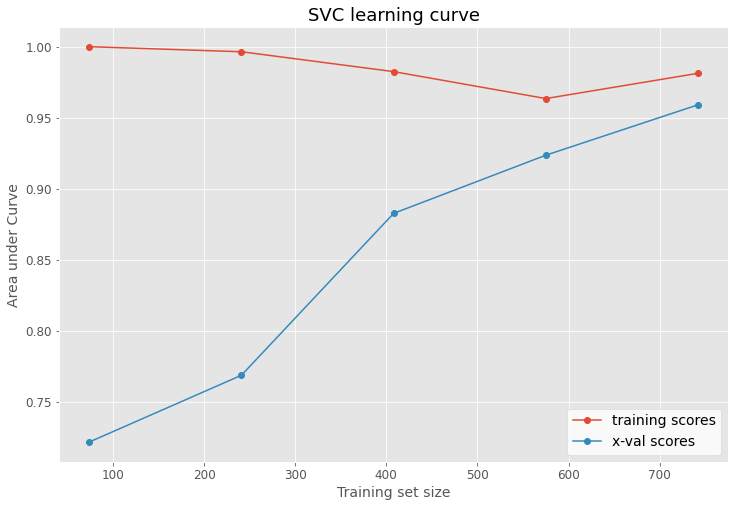

In [98]:
# best model is the default RBF kernal SVM
plot_learning_curves(svc_clf, data_train_X, data_train['anxietyanddepression']) 

# Ensemble classifier
Scikit-learn offers a voting classifier which aggregates the prediction of multiple predictors and is a flexible ensemble technique that allows an ensemble of different models.
For the final classifier, simply aggregate the predictions of the three best models, i.e., random forests, gradien boosting machine and the support vector machine.

In [548]:
ensemble_clf = VotingClassifier(estimators=[('rf', rf_clf), ('gbm', gbm_clf), ('svc', svc_clf),('dt',dt_clf)],
                             voting='soft')
ensemble_clf.fit(data_train_X, data_train['anxietyanddepression'])

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=3,
                                                     max_features='log2',
                                                     min_samples_leaf=67,
                                                     min_samples_split=20,
                                                     n_estimators=16,
                                                     random_state=42)),
                             ('gbm',
                              GradientBoostingClassifier(max_features='auto',
                                                         min_samples_leaf=4,
                                                         min_samples_split=8,
                                                         random_state=42)),
                             ('svc',
                              SVC(C=0.03845401188473625,
                                  gamma=0.4753571532049581, kernel='linear',
                

Check out its learning curve.

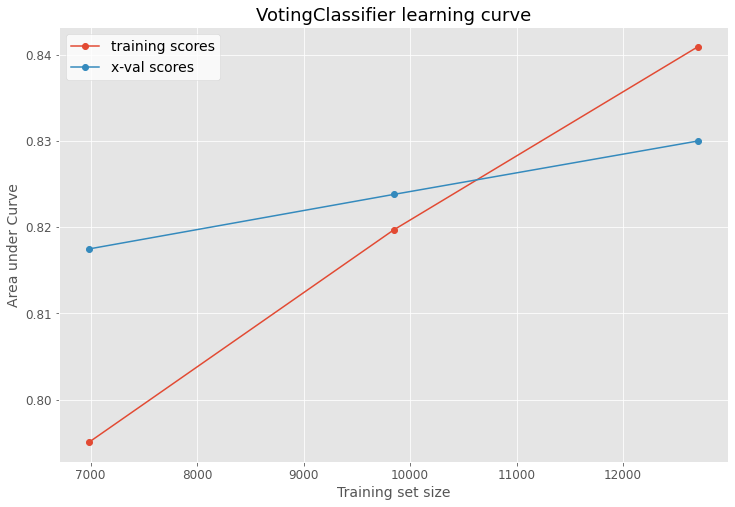

In [549]:
plot_learning_curves(ensemble_clf, data_train_X, data_train['anxietyanddepression'])

In [550]:
with open('E:/R code-LMX/R code for SEER for publishing paper/Data/ensemble_clf_final_round.pkl', 'wb') as f:
    pickle.dump(ensemble_clf, f)

# h2o AutoML

In [2]:
import h2o
from h2o.automl import H2OAutoML

In [3]:
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [4]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM JBR-11.0.13.7-1751.21-jcef (build 11.0.13+7-b1751.21, mixed mode)
  Starting server from C:\Users\63276\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\63276\AppData\Local\Temp\tmp_ob4l6yy
  JVM stdout: C:\Users\63276\AppData\Local\Temp\tmp_ob4l6yy\h2o_63276_started_from_python.out
  JVM stderr: C:\Users\63276\AppData\Local\Temp\tmp_ob4l6yy\h2o_63276_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  -----------------------------
H2O_cluster_uptime:         02 secs
H2O_cluster_timezone:       Asia/Shanghai
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.36.1.1
H2O_cluster_version_age:    2 months and 1 day
H2O_cluster_name:           H2O_from_python_63276_cbjexu
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.939 Gb
H2O_cluster_total_cores:    8
H2O_cluster_allowed_cores:  8
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.9.7 final
--------------------------  -----------------------------

In [14]:
data_train = h2o.import_file(r'E:/R code-LMX/R code for SEER-Bone metastasis-LYS/Data/start0.9.csv')##只能是csv文件，excle文件还不行哦！！！
data_test = h2o.import_file(r'E:/R code-LMX/R code for SEER-Bone metastasis-LYS/Data/starv0.1.csv')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [15]:
##airlines = h2o.import_file('https://s3.amazonaws.com/h2o-public-test-data/smalldata/airlines/allyears2k_headers.zip')

In [16]:
data_train.head()

C1 X Rural.urban Patient.ID Marital.status Age Race Sequence.number Total.number.of.in.situ.malignant.tumors.for.patient Total.number.of.benign.borderline.tumors.for.patient SEER.cause.specific.death.classification SEER.other.cause.of.death.classification Survival.months Threemonthmortality Censor Survival.months.flag Vital.status.recode..study.cutoff.used. EOD.Primary.Tumor..2018.. Tumor.Size.Summary..2016.. SEER.Combined.Mets.at.DX.bone..2010.. Brain.m Liver.m Lung.m Regional.nodes.positive..1988.. Mets.at.DX.Distant.LN..2016.. Breast.Subtype..2010.. ER.Status.Recode.Breast.Cancer..1990.. PR.Status.Recode.Breast.Cancer..1990.. Derived.HER2.Recode..2010.. Visceral.and.Parietal.Pleural.Invasion.Recode..2010.. Cancer.directed.surgery Radiation Chemotherapy Months.from.diagnosis.to.treatment Derived.EOD.2018.T..2018.. Tstage Derived.EOD.2018.N..2018.. Nstage Derived.EOD.2018.M..2018.. Derived.AJCC.M..7th.ed..2010.2015. Derived.SEER.Combined.T..2016.2017. Derived.SEER.Combined.N..2016.2017. Derived.SEER.Combined.M..2016.2017. Primary.siteyuan Primary.site Response.to.Neoadjuvant.Therapy.Recode..2010.. ER.Status.Recode.Breast.Cancer..1990...1 Response.to.Neoadjuvant.Therapy.Recode..2010...2 PR.Status.Recode.Breast.Cancer..1990...1 Primary.Site Histologic.Type.ICD.O.3 Grade Laterality Sex Year.of.diagnosis Response.to.Neoadjuvant.Therapy.Recode..2010...1 Pleural.Effusion.Recode..2010.. Perineural.Invasion.Recode..2010.. Peripheral.Blood.Involvement.Recode..2010.. Behavior.code.ICD.O.2 Group 
 
 
 2 113150 Metropolitan counties 2557 Married (including common law) 72 Other 2nd of 2 or more primaries 2 0 Dead (attributable to this cancer dx) Alive or dead due to cancer 7 0 1 Complete dates are available and there are more than 0 days of survival Dead Blank(s) Blank(s) Yes No No No 98 Blank(s) Recode not available Recode not available Recode not available Recode not available Not documented; No resection of primary; Not assessed or unknown if assessed No Yes Yes 0 Blank(s) T4 Blank(s) N2 Blank(s) M1NOS Blank(s) Blank(s) Blank(s) Lung and Bronchus Rapid Blank(s) Recode not available Blank(s) Recode not available 341 8046 Poorly differentiated; Grade III Right - origin of primary Female 2011 Blank(s) Blank(s) Blank(s) Blank(s) Malignant t 
 3 51311 Metropolitan counties 3273 Single (never married) 61 Black 2nd of 2 or more primaries 2 0 Dead (attributable to this cancer dx) Alive or dead due to cancer 10 0 1 Complete dates are available and there are more than 0 days of survival Dead Blank(s) Blank(s) Yes Yes Yes No 0 Blank(s) Recode not available Recode not available Recode not available Recode not available Not documented; No resection of primary; Not assessed or unknown if assessed No Yes Yes 0 Blank(s) T4 Blank(s) N2 Blank(s) M1b Blank(s) Blank(s) Blank(s) Lung and Bronchus Rapid Blank(s) Recode not available Blank(s) Recode not available 340 8041 Poorly differentiated; Grade III Left - origin of primary Male 2014 Blank(s) Blank(s) Blank(s) Blank(s) Malignant t 
 4 147754 Metropolitan counties 3391 Divorced 79 White 3rd of 3 or more primaries 3 0 Dead (attributable to this cancer dx) Alive or dead due to cancer 1 1 1 Complete dates are available and there are more than 0 days of survival Dead Blank(s) Blank(s) Yes No No No 98 Blank(s) Recode not available Recode not available Recode not available Recode not available Not documented; No resection of primary; Not assessed or unknown if assessed No None/Unknown No/Unknown nan Blank(s) T3 Blank(s) N3 Blank(s) M1b Blank(s) Blank(s) Blank(s) Lung and Bronchus Rapid Blank(s) Recode not available Blank(s) Recode not available 341 8010 Unknown Right - origin of primary Male 2010 Blank(s) Blank(s) Blank(s) Blank(s) Malignant t 
 7 174575 Metropolitan counties 5086 Married (including common law) 87 White 4th of 4 or more primaries 4 0 Dead (attributable to this cancer dx) Alive or dead due to cancer 4 0 1 Complete dates are available and there are more than 0 days of survival Dead Blank(s) Blan

In [17]:
data_train["Marital.status"] = data_train["Marital.status"].asfactor()
data_train["Rural.urban"] = data_train["Rural.urban"].asfactor()
data_train["Brain.m"] = data_train["Brain.m"].asfactor()
data_train["Liver.m"] = data_train["Liver.m"].asfactor()
data_train["Lung.m"] = data_train["Lung.m"].asfactor()
data_train["Primary.site"] = data_train["Primary.site"].asfactor()
data_train["Race"] = data_train["Race"].asfactor()
data_train["Tstage"] = data_train["Tstage"].asfactor()
data_train["Nstage"] = data_train["Nstage"].asfactor()
data_train["Cancer.directed.surgery"] = data_train["Cancer.directed.surgery"].asfactor()
data_train['Radiation'] = data_train['Radiation'].asfactor()
data_train['Chemotherapy'] = data_train['Chemotherapy'].asfactor()
data_train['Sex'] = data_train['Sex'].asfactor()

In [21]:
predictors = ["Rural.urban",
"Marital.status",
"Race",
"Brain.m",
"Liver.m",
"Lung.m",
"Cancer.directed.surgery",
"Radiation",
"Chemotherapy",
"Tstage",
"Nstage",
"Primary.site",
"Sex","Age"]
response = 'Threemonthmortality'

In [22]:
bin_num = [8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]
label = ["8", "16", "32", "64", "128", "256", "512", "1024", "2048", "4096"]

In [23]:
model = H2OGradientBoostingEstimator(seed=1234)
model.train(x=predictors,y=response,training_frame=data_train,validation_frame=data_test)

gbm Model Build progress: |

C:\Users\63276\anaconda3\lib\site-packages\h2o\estimators\estimator_base.py:208: RuntimeWarning: Response is numeric, so the regression model will be trained. However, the cardinality is equaled to two, so if you want to train a classification model, convert the response column to categorical before training.
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1655210293753_2


Model Summary: 


number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0               50.0                      50.0              22860.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0        5.0        5.0         5.0        26.0        32.0        31.72



ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.14286436279442088
RMSE: 0.377974023967813
MAE: 0.29170667090492025
RMSLE: 0.2649532309814337
Mean Residual Deviance: 0.14286436279442088

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 0.14187016539071728
RMSE: 0.3766565615925432
MAE: 0.29065911979657366
RMSLE: 0.264618754940582
Mean Residual Deviance: 0.14187016539071728

Scoring History: 


timestamp    duration  number_of_trees  training_rmse  \
0     2022-06-14 20:41:38   0.003 sec              0.0       0.481879   
1     2022-06-14 20:41:38   0.088 sec              1.0       0.465089   
2     2022-06-14 20:41:38   0.146 sec              2.0       0.451016   
3     2022-06-14 20:41:38   0.189 sec              3.0       0.439259   
4     2022-06-14 20:41:38   0.233 sec              4.0       0.429461   
5     2022-06-14 20:41:38   0.283 sec              5.0       0.421284   
6     2022-06-14 20:41:38   0.330 sec              6.0       0.414483   
7     2022-06-14 20:41:38   0.369 sec              7.0       0.408865   
8     2022-06-14 20:41:38   0.405 sec              8.0       0.404174   
9     2022-06-14 20:41:38   0.444 sec              9.0       0.400319   
10    2022-06-14 20:41:38   0.483 sec             10.0       0.397068   
11    2022-06-14 20:41:38   0.521 sec             11.0       0.394362   
12    2022-06-14 20:41:38   0.549 sec             12.0       0.392121   
13    2022-06-14 20:41:38   0.575 sec             13.0       0.390253   
14    2022-06-14 20:41:38   0.606 sec             14.0       0.388666   
15    2022-06-14 20:41:38   0.635 sec             15.0       0.387308   
16    2022-06-14 20:41:38   0.663 sec             16.0       0.386165   
17    2022-06-14 20:41:38   0.691 sec             17.0       0.385213   
18    2022-06-14 20:41:38   0.721 sec             18.0       0.384368   
19    2022-06-14 20:41:38   0.751 sec             19.0       0.383687   

    training_mae  training_deviance  validation_rmse  validation_mae  \
0       0.464414           0.232207         0.480978        0.463546   
1       0.447678           0.216307         0.464026        0.446687   
2       0.432619           0.203416         0.449751        0.431488   
3       0.419052           0.192948         0.437836        0.417812   
4       0.406840           0.184437         0.427880        0.405520   
5       0.395822           0.177480         0.419551        0.394400   
6       0.385867           0.171796         0.412576        0.384313   
7       0.376913           0.167171         0.406854        0.375288   
8       0.368845           0.163356         0.402016        0.367137   
9       0.361556           0.160255         0.398055        0.359770   
10      0.354950           0.157663         0.394742        0.353143   
11      0.348959           0.155522         0.391963        0.347089   
12      0.343579           0.153759         0.389599        0.341630   
13      0.338710           0.152297         0.387658        0.336704   
14      0.334288           0.151062         0.386047        0.332285   
15      0.330311           0.150008         0.384654        0.328300   
16      0.326703           0.149123         0.383536        0.324713   
17      0.323399           0.148389         0.382525        0.321363   
18      0.320429           0.147739         0.381680        0.318411   
19      0.317701           0.147216         0.381007        0.315679   

    validation_deviance  
0              0.231339  
1              0.215320  
2              0.202276  
3              0.191701  
4              0.183082  
5              0.176023  
6              0.170219  
7              0.165530  
8              0.161617  
9              0.158448  
10             0.155821  
11             0.153635  
12             0.151788  
13             0.150279  
14             0.149032  
15             0.147959  
16             0.147100  
17             0.146326  
18             0.145680  
19             0.145166


See the whole table with table.as_data_frame()

Variable Importances: 


variable  relative_importance  scaled_importance  \
0              Primary.site         26667.812500           1.000000   
1              Chemotherapy         15887.108398           0.595741   
2   Cancer.directed.surgery          1738.354004           0.065185   
3                   Liver.m          1689.341431           0.063348   
4                       Age           875.495056           0.032830   
5                 Radiation           686.048218           0.025726   
6                    Tstage           573.331543           0.021499   
7                    Lung.m           483.759338           0.018140   
8                    Nstage           420.359070           0.015763   
9                   Brain.m           364.061066           0.013652   
10                      Sex           258.174530           0.009681   
11           Marital.status           214.653625           0.008049   
12                     Race           160.267075           0.006010   
13              Rural.urban            56.387054           0.002114   

    percentage  
0     0.532556  
1     0.317265  
2     0.034715  
3     0.033736  
4     0.017484  
5     0.013700  
6     0.011449  
7     0.009661  
8     0.008395  
9     0.007270  
10    0.005156  
11    0.004287  
12    0.003201  
13    0.001126

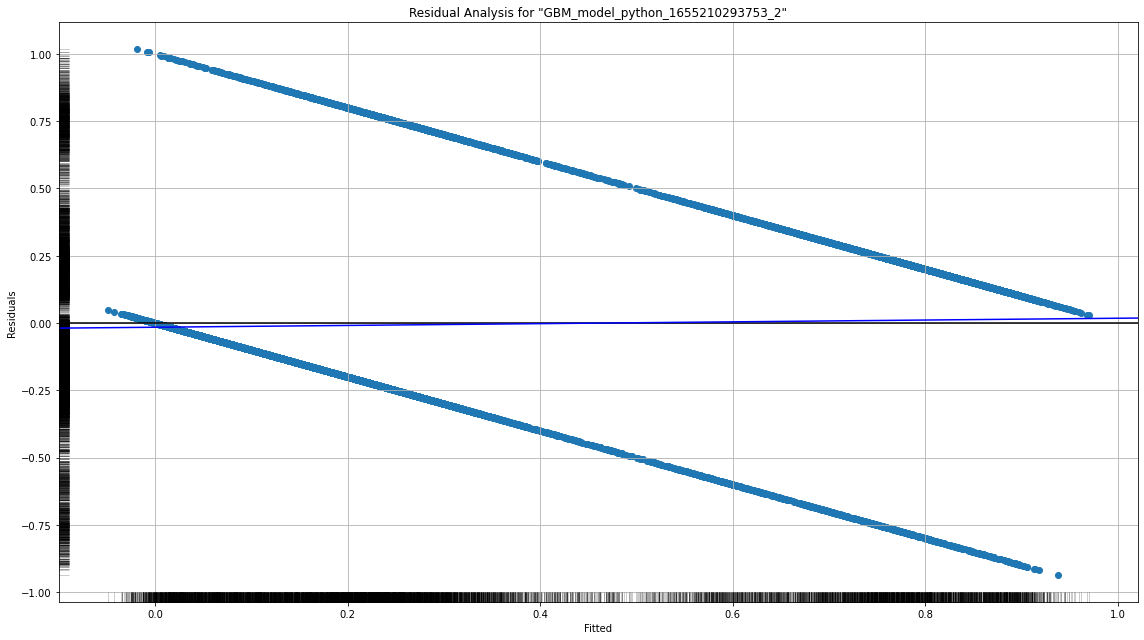

In [24]:
ra_plot = model.residual_analysis_plot(data_test)

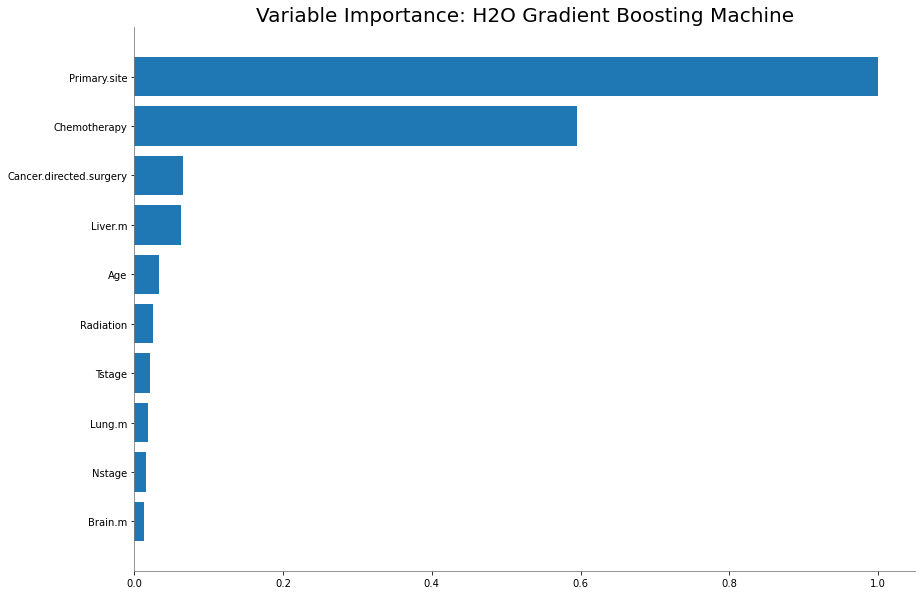

<Figure size 432x288 with 0 Axes>

In [25]:
ra_plot = model.varimp_plot()

In [26]:
aml = H2OAutoML(max_runtime_secs=60, seed=1)
aml.train(x=predictors,y=response, training_frame=data_train)

AutoML progress: |
20:42:07.136: AutoML: XGBoost is not available; skipping it.
20:42:07.167: _response param, Response is numeric, so the regression model will be trained. However, the cardinality is equaled to two, so if you want to train a classification model, convert the response column to categorical before training.


20:42:08.260: _response param, Response is numeric, so the regression model will be trained. However, the cardinality is equaled to two, so if you want to train a classification model, convert the response column to categorical before training.

██
20:42:10.677: _response param, Response is numeric, so the regression model will be trained. However, the cardinality is equaled to two, so if you want to train a classification model, convert the response column to categorical before training.

█
20:42:11.510: _response param, Response is numeric, so the regression model will be trained. However, the cardinality is equaled to two, so if you want to train a classificatio

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id rmse mse mae rmsle mean_residual_deviance training_time_ms predict_time_per_row_ms algo 
 
 
 StackedEnsemble_AllModels_3_AutoML_1_20220614_175910 0.381687 0.145685 0.294009 0.267228 0.145685 3408 0.079656 StackedEnsemble 
 GBM_5_AutoML_1_20220614_175910 0.381696 0.145692 0.291397 0.267197 0.145692 873 0.00628 GBM 
 StackedEnsemble_BestOfFamily_4_AutoML_1_20220614_175910 0.381742 0.145727 0.291841 0.267161 0.145727 536 0.019404 StackedEnsemble 
 StackedEnsemble_AllModels_2_AutoML_1_20220614_175910 0.381805 0.145775 0.2922 0.267113 0.145775 642 0.026217 StackedEnsemble 
 StackedEnsemble_BestOfFamily_3_AutoML_1_20220614_175910 0.381835 0.145798 0.291484 0.26701 0.145798 701 0.017985 StackedEnsemble 
 StackedEnsemble_AllModels_1_AutoML_1_20220614_175910 0.381926 0.145867 0.290342 0.267426 0.145867 663 0.015939 StackedEnsemble 
 StackedEnsemble_BestOfFamily_2_AutoML_1_20220614_175910 0.382101 0.146001 0.292365 0.267626 0.146001 964 0.012975 StackedEnsemble 
 GBM_2_AutoML_1_20220614_175910 0.382253 0.146117 0.29209 0.267643 0.146117 1225 0.005698 GBM 
 GBM_grid_1_AutoML_1_20220614_175910_model_3 0.382383 0.146217 0.295788 0.267845 0.146217 835 0.005535 GBM 
 GBM_grid_1_AutoML_1_20220614_175910_model_6 0.382448 0.146266 0.29723 0.267979 0.146266 882 0.004802 GBM 
 GBM_3_AutoML_1_20220614_175910 0.382525 0.146326 0.292327 0.267895 0.146326 1283 0.004938 GBM 
 GBM_grid_1_AutoML_1_20220614_175910_model_12 0.382568 0.146358 0.29407 0.267805 0.146358 911 0.003267 GBM 
 GBM_grid_1_AutoML_1_20220614_175910_model_2 0.382579 0.146367 0.295218 0.26794 0.146367 872 0.003143 GBM 
 StackedEnsemble_BestOfFamily_1_AutoML_1_20220614_175910 0.382823 0.146554 0.294599 0.26841 0.146554 980 0.00445 StackedEnsemble 
 GBM_grid_1_AutoML_1_20220614_175910_model_9 0.382993 0.146684 0.30182 0.268642 0.146684 657 0.002962 GBM 
 GBM_1_AutoML_1_20220614_175910 0.383053 0.146729 0.29122 0.268324 0.146729 2419 0.004974 GBM 
 GBM_grid_1_AutoML_1_20220614_175910_model_7 0.38396 0.147425 0.304494 0.269388 0.147425 679 0.003381 GBM 
 GBM_4_AutoML_1_20220614_175910 0.384627 0.147938 0.292575 0.269468 0.147938 1364 0.004026 GBM 
 GBM_grid_1_AutoML_1_20220614_175910_model_4 0.385421 0.148549 0.300754 0.270521 0.148549 2897 0.00965 GBM 
 GBM_grid_1_AutoML_1_20220614_175910_model_1 0.385573 0.148667 0.30437 0.270679 0.148667 1806 0.005595 GBM

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

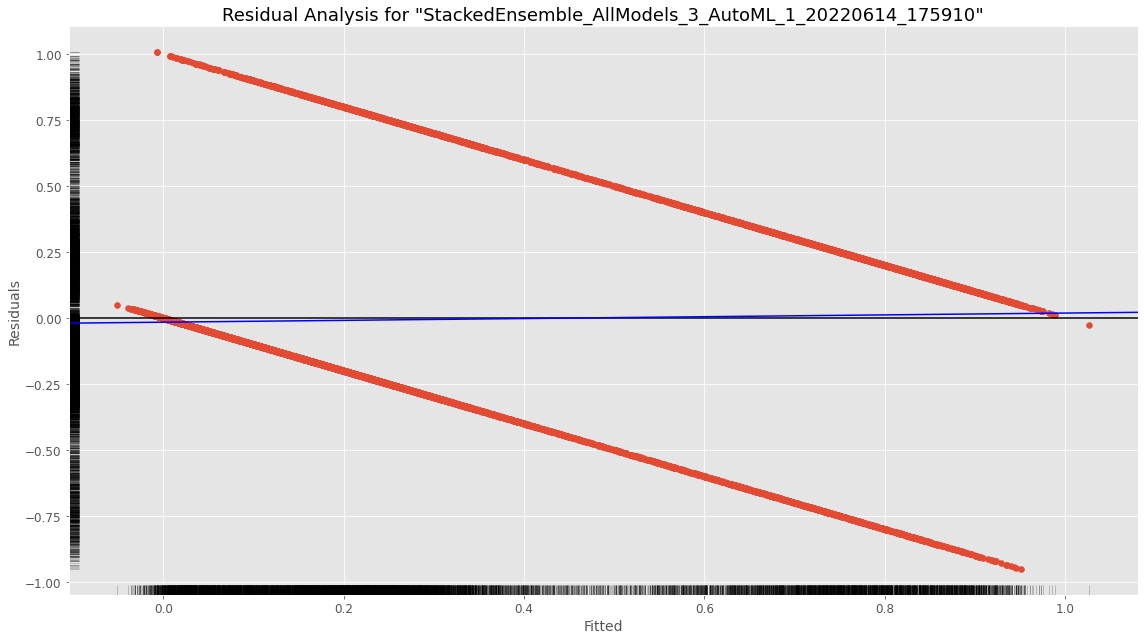

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

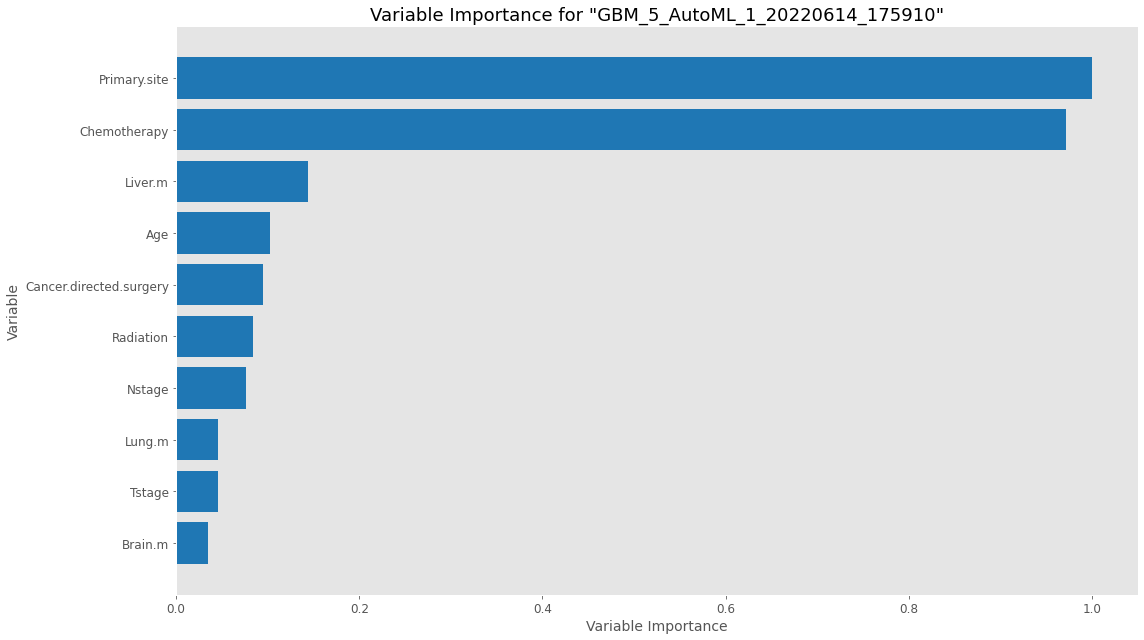

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

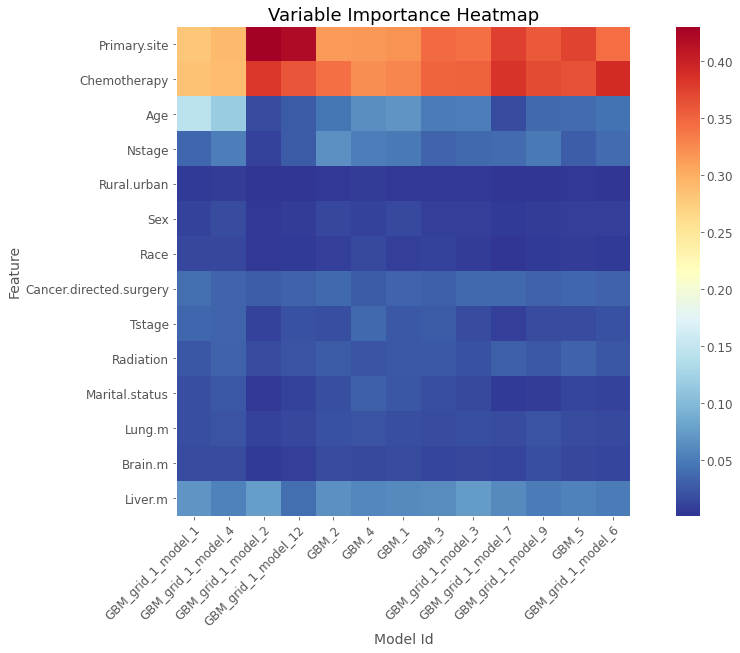

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

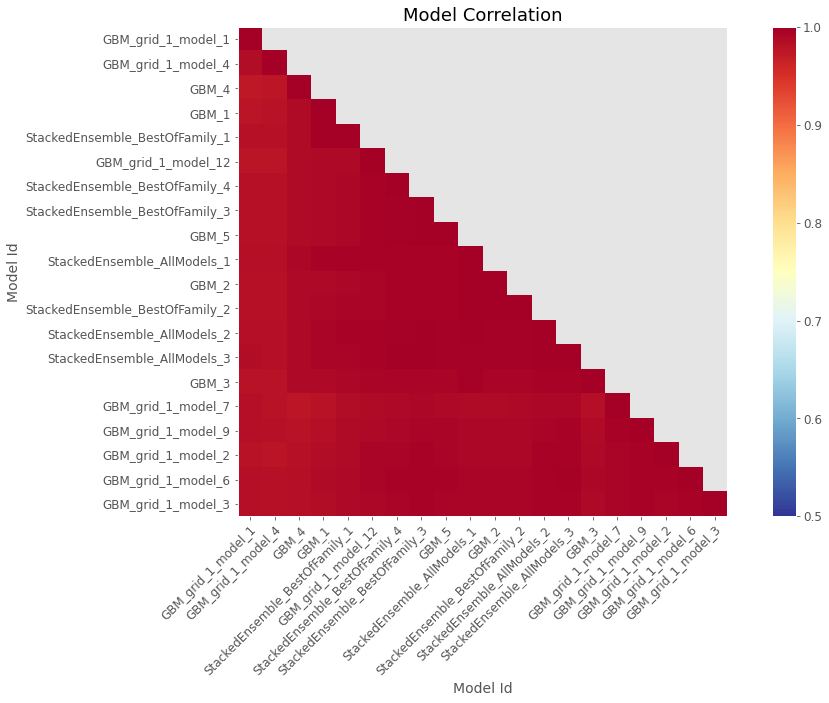

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

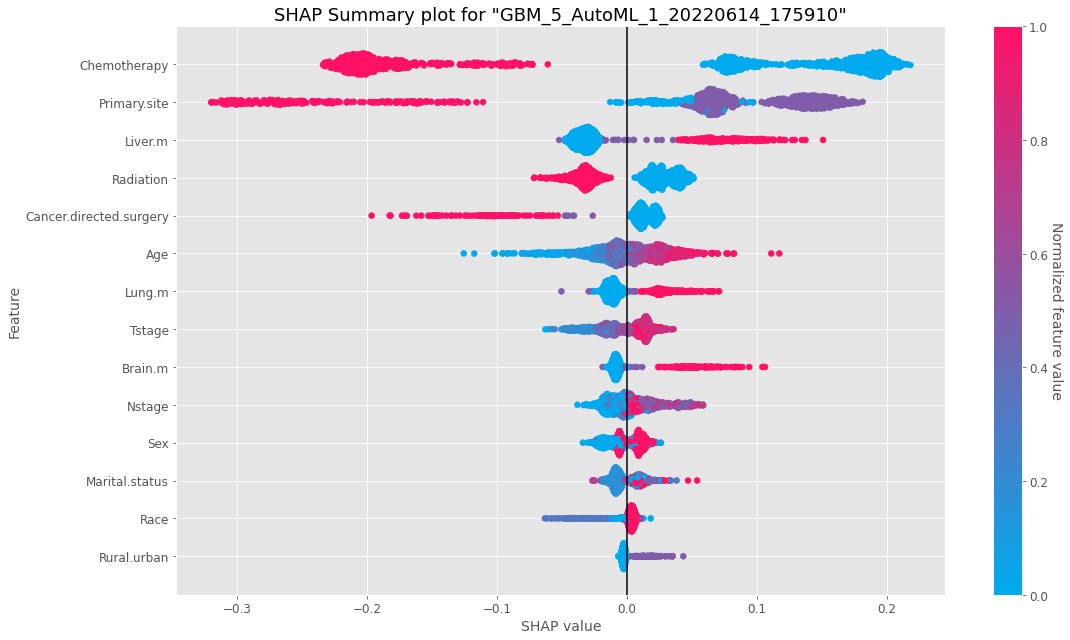

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

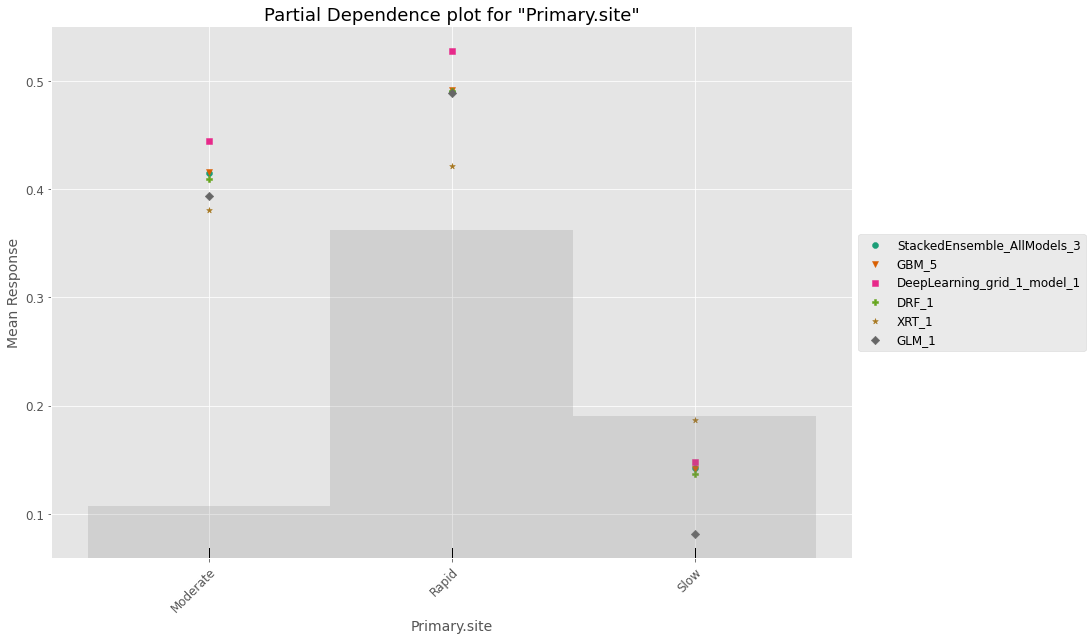

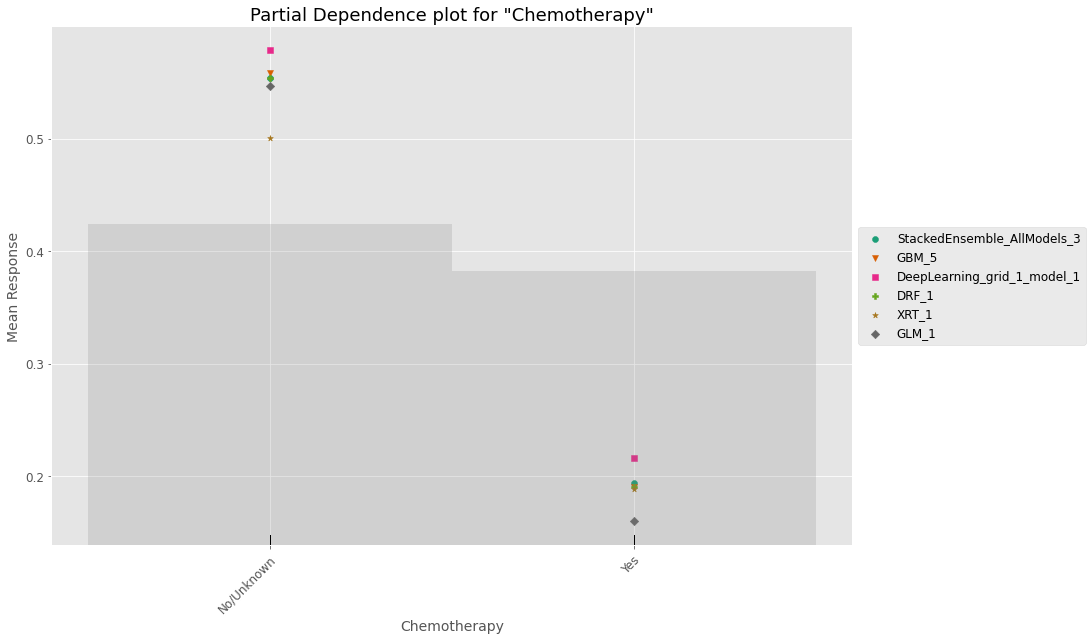

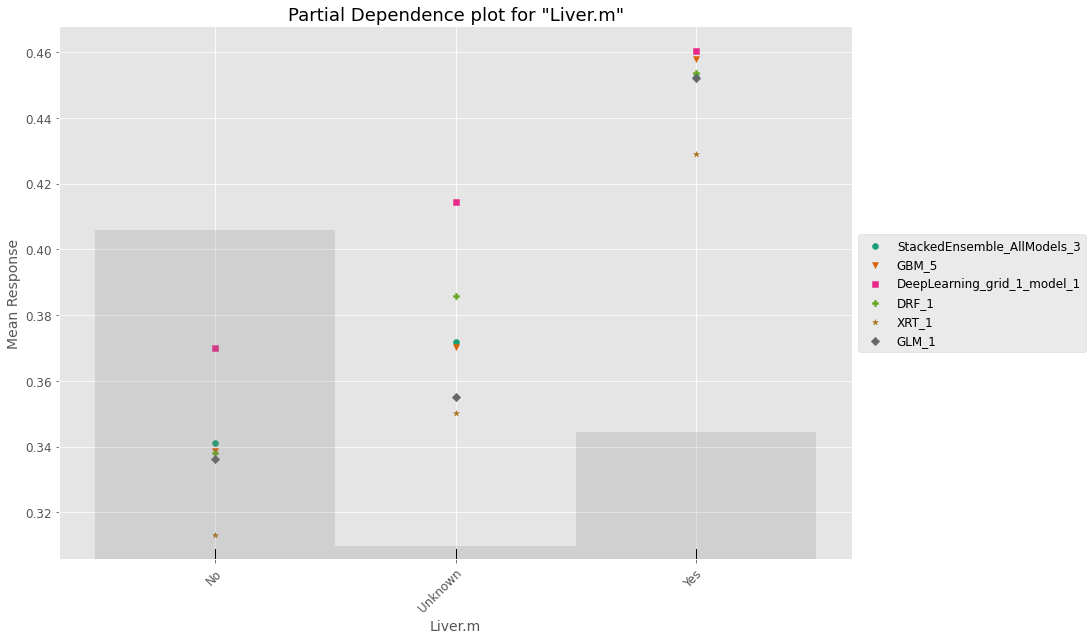

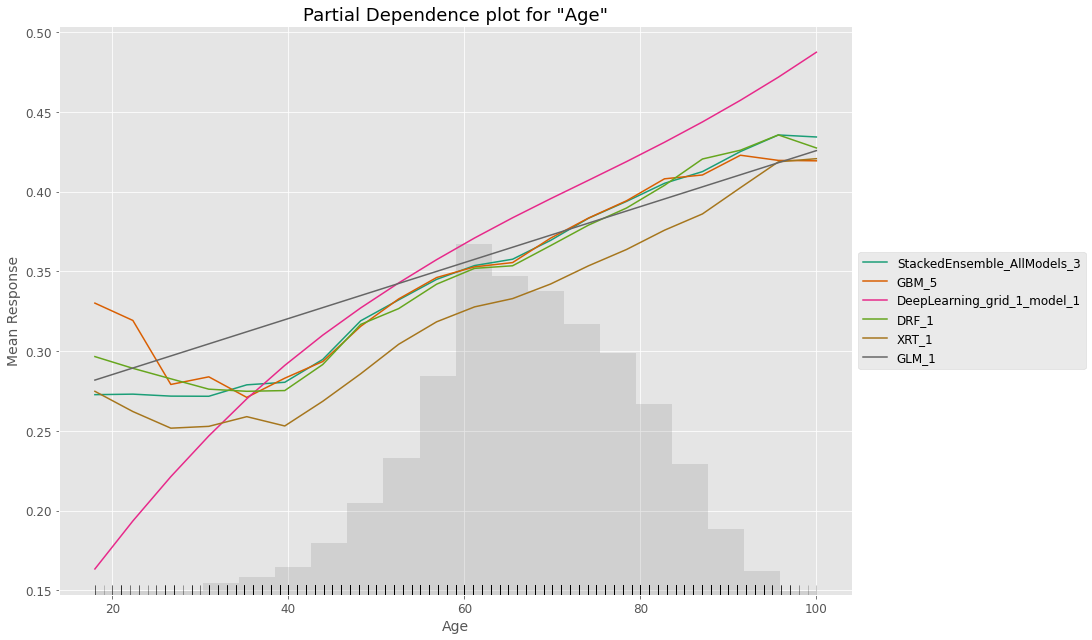

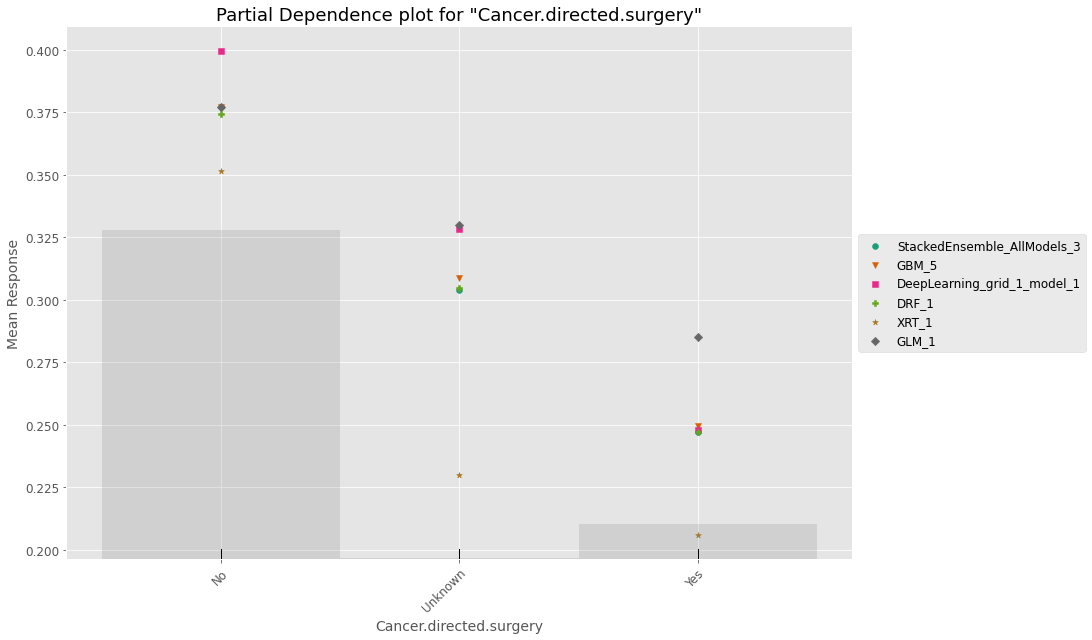

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

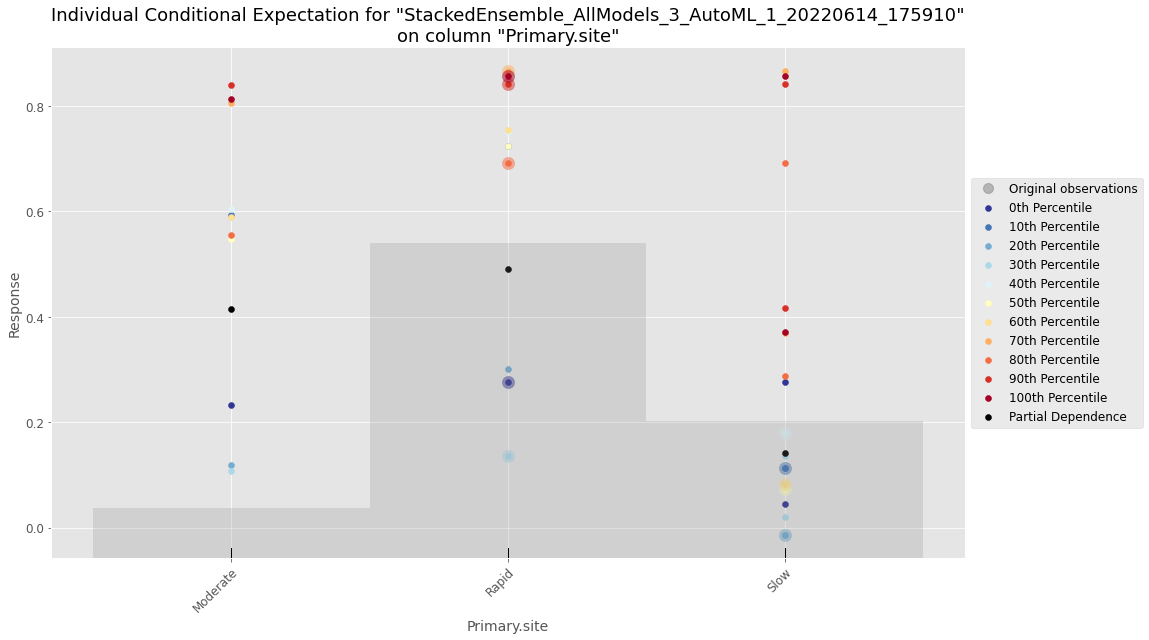

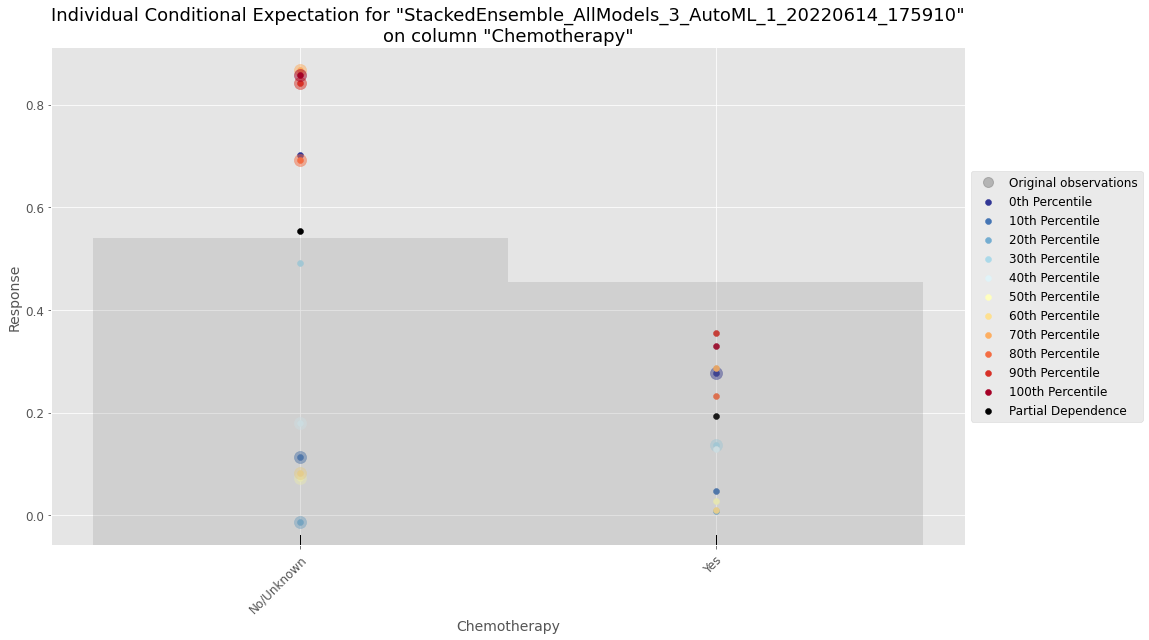

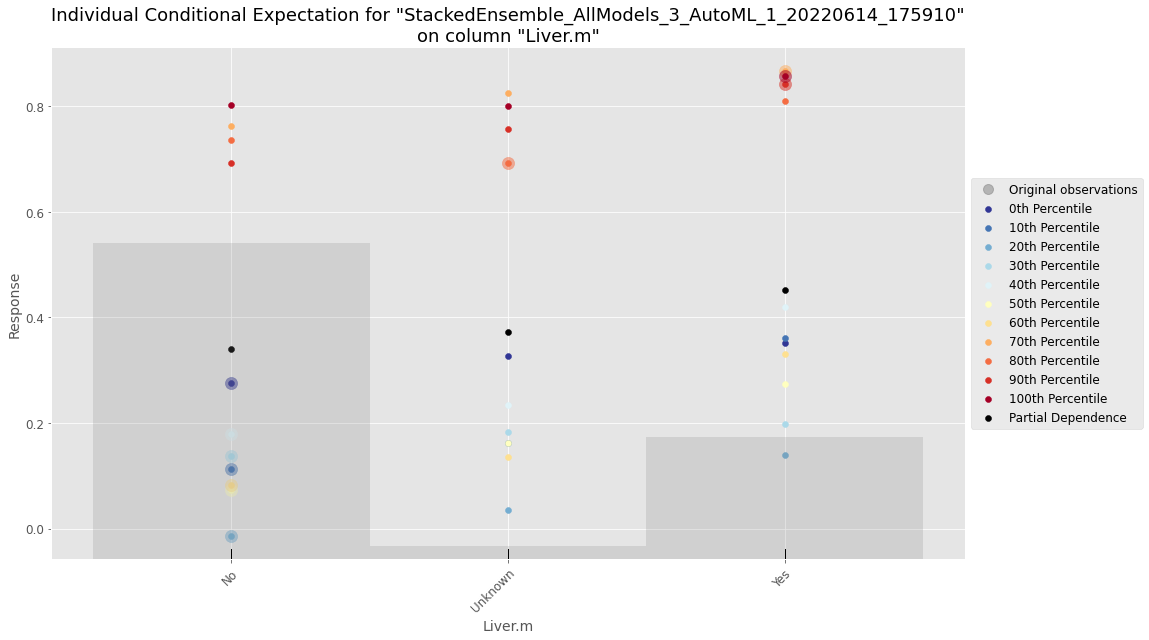

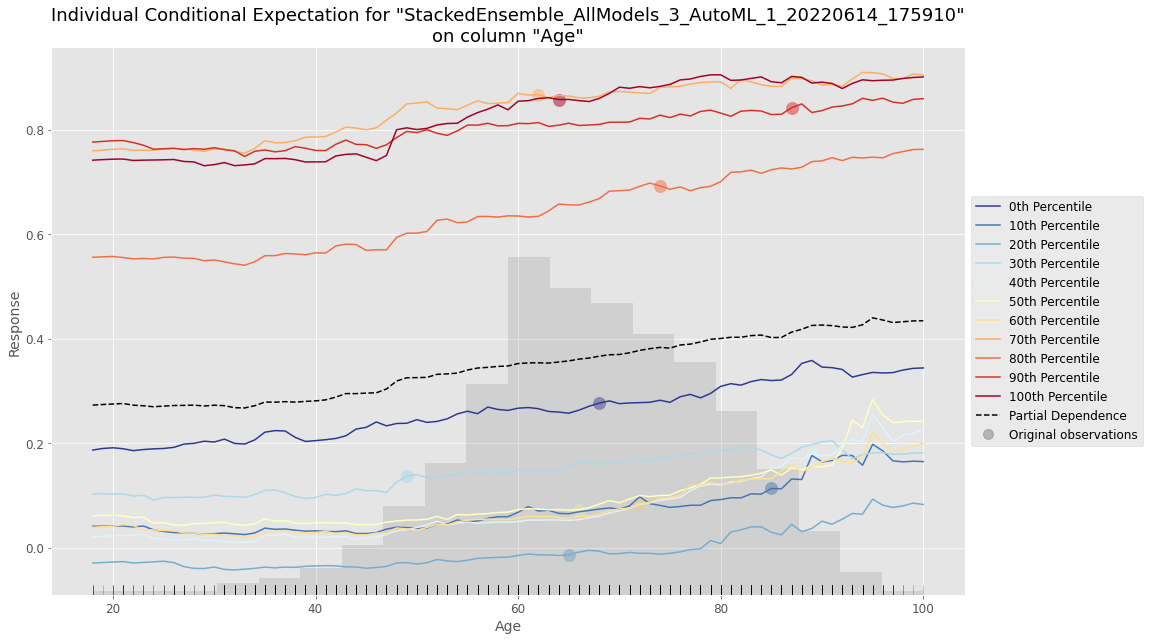

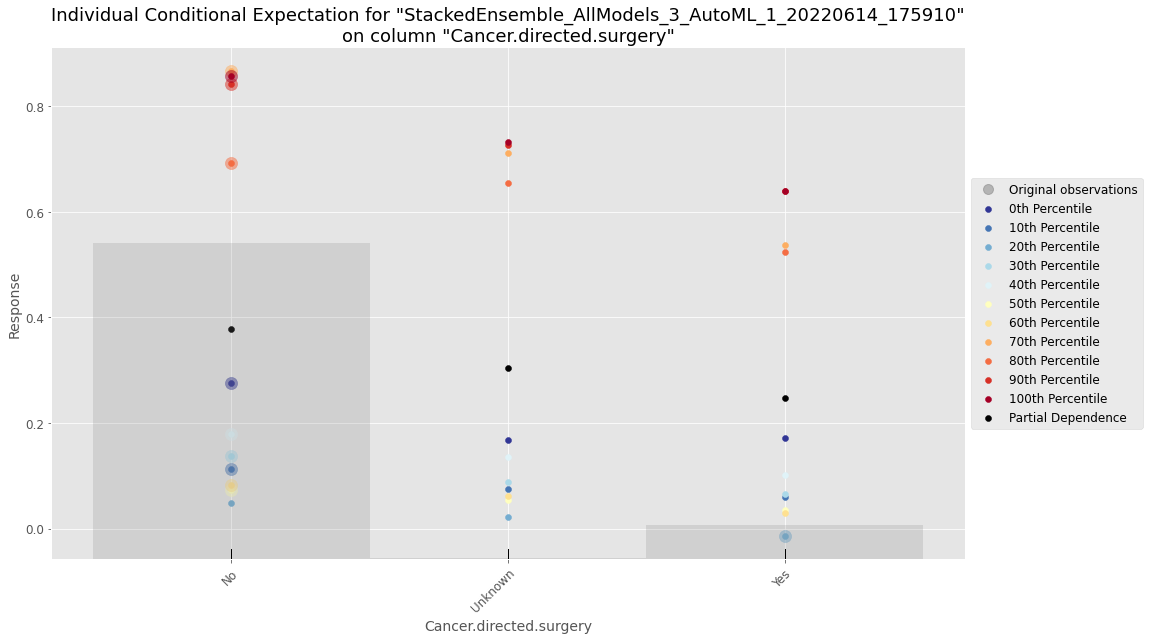

In [15]:
# Explain leader model & compare with all AutoML models
exa = aml.explain(data_test)

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

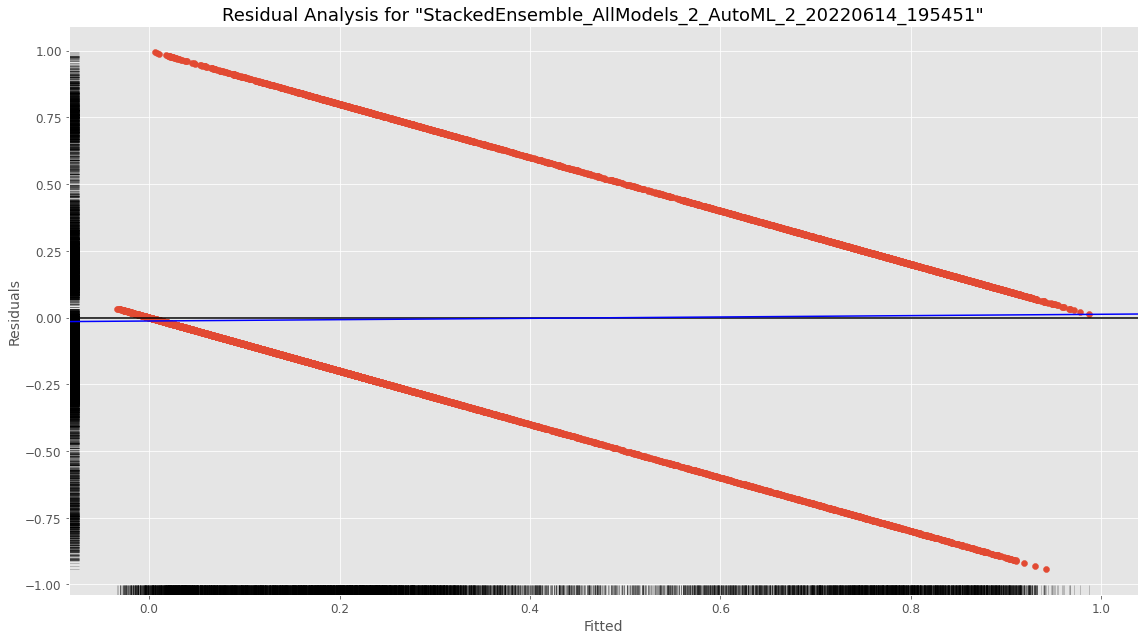

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

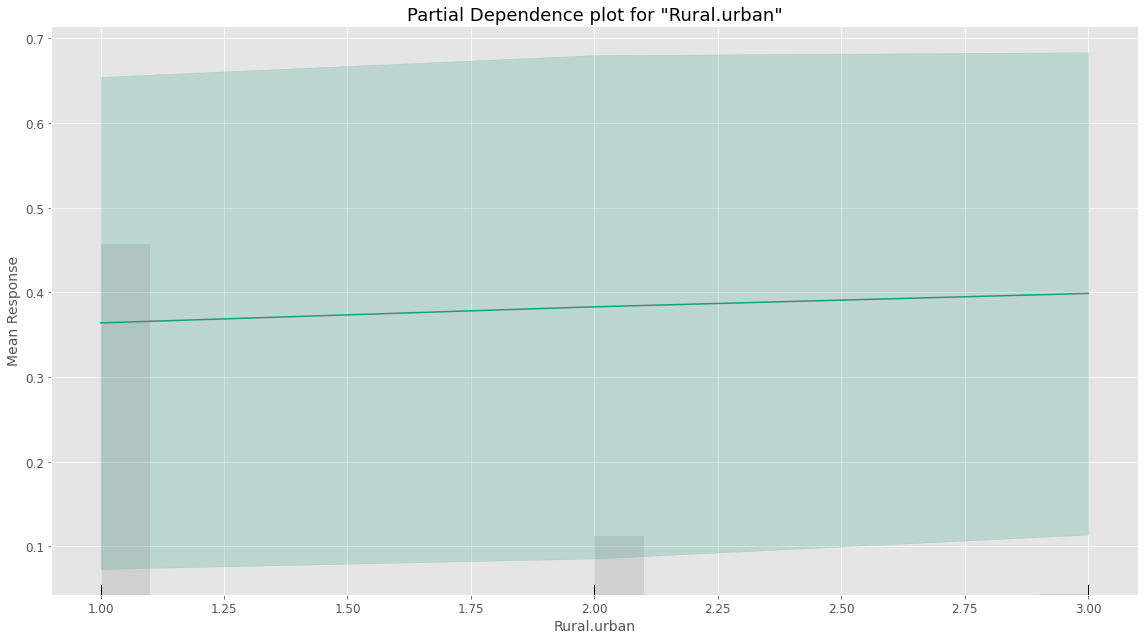

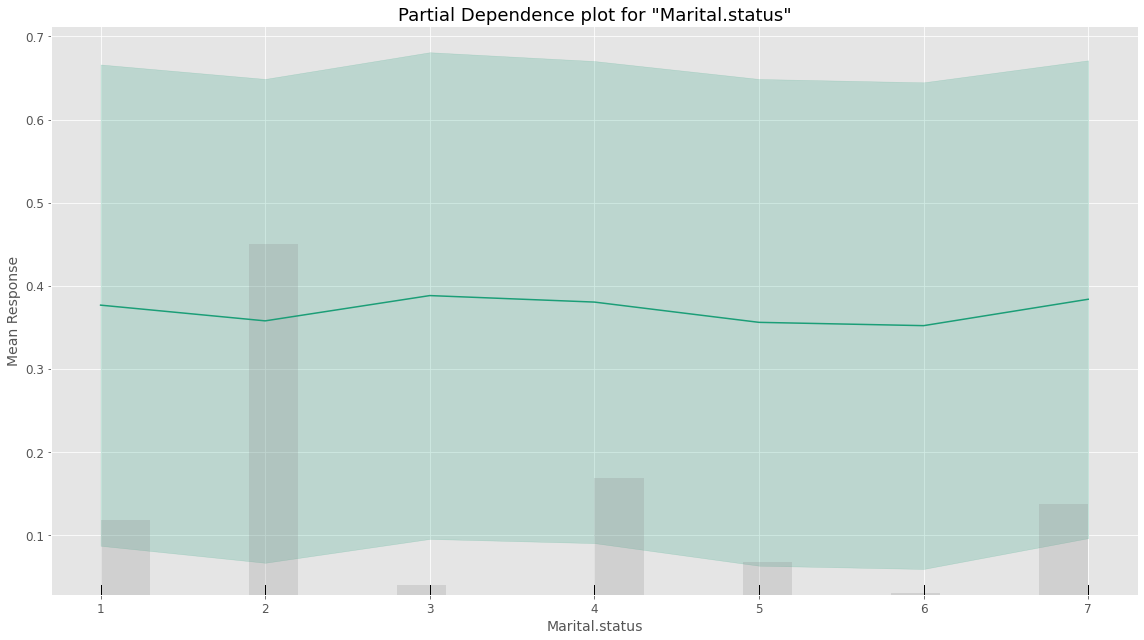

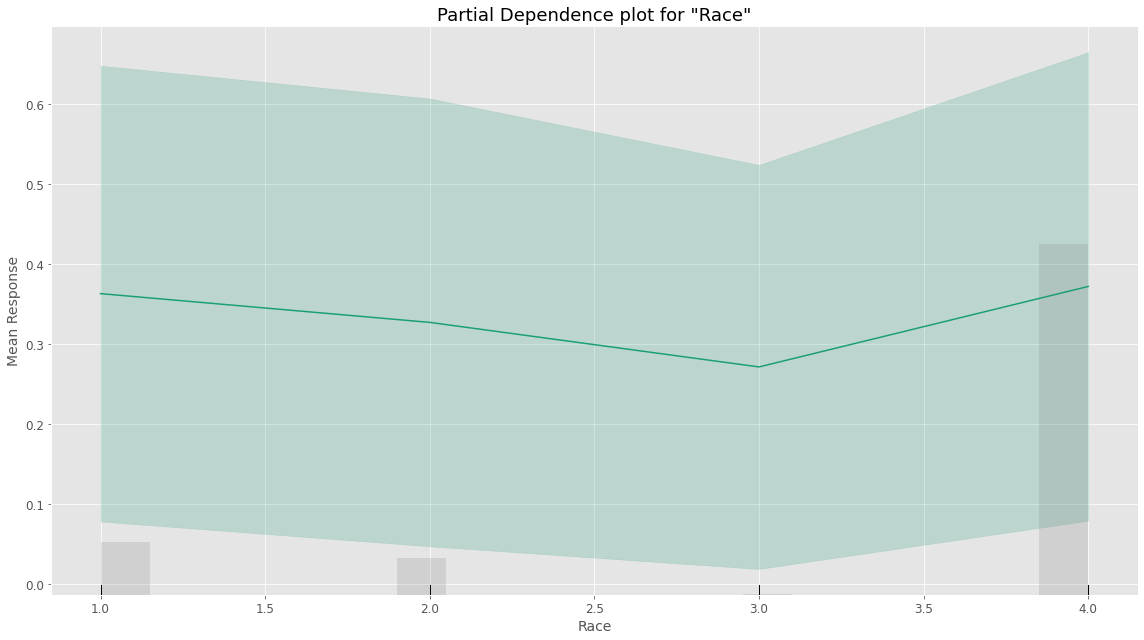

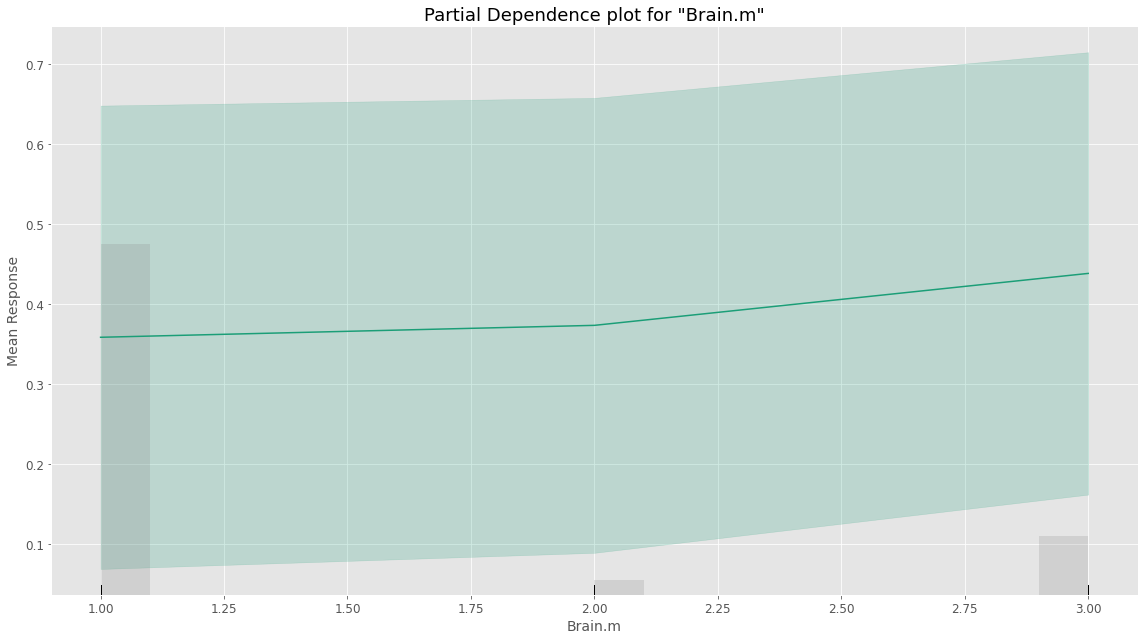

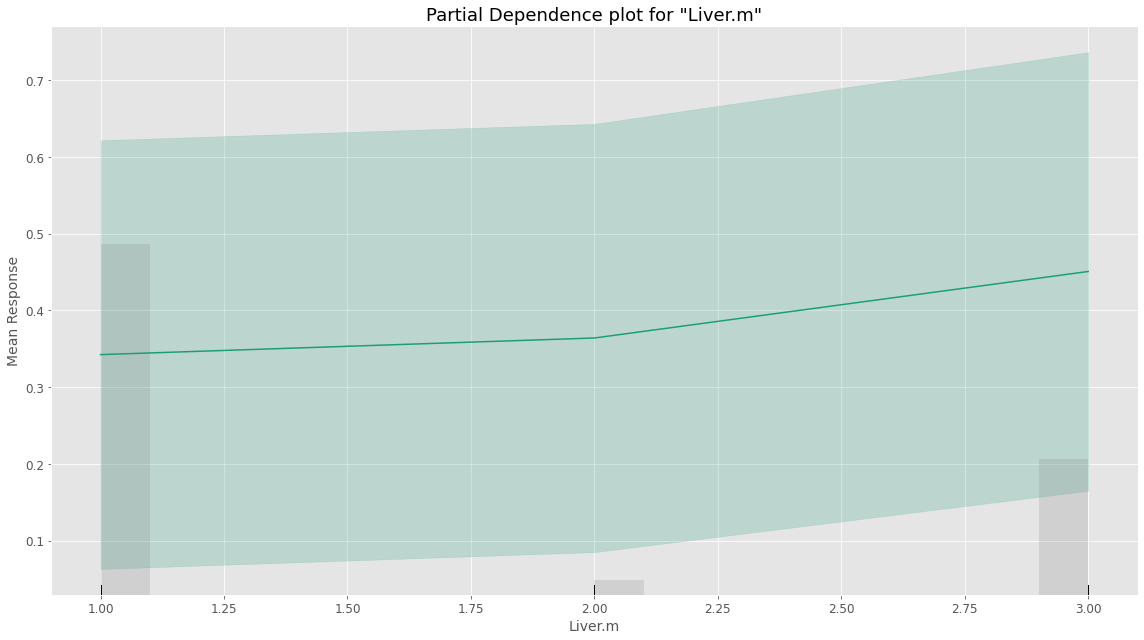

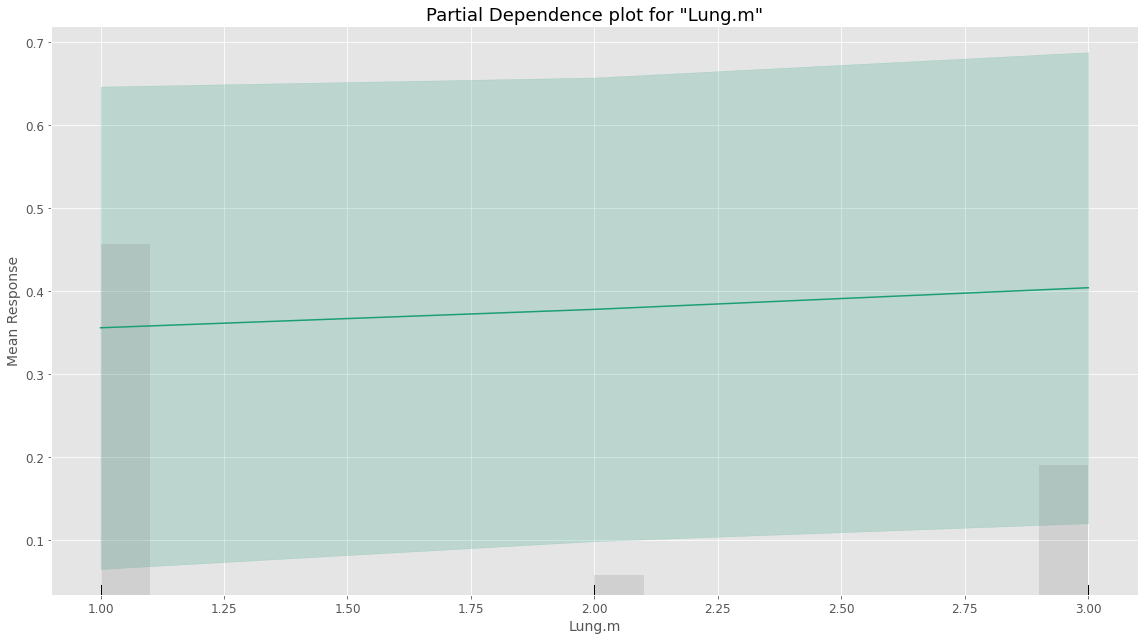

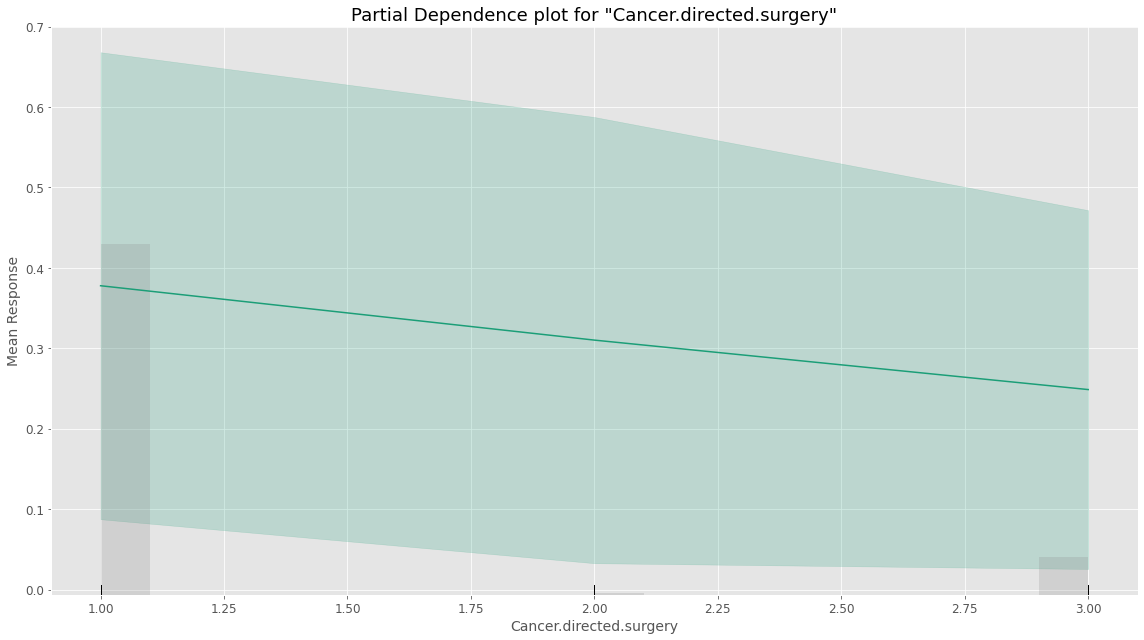

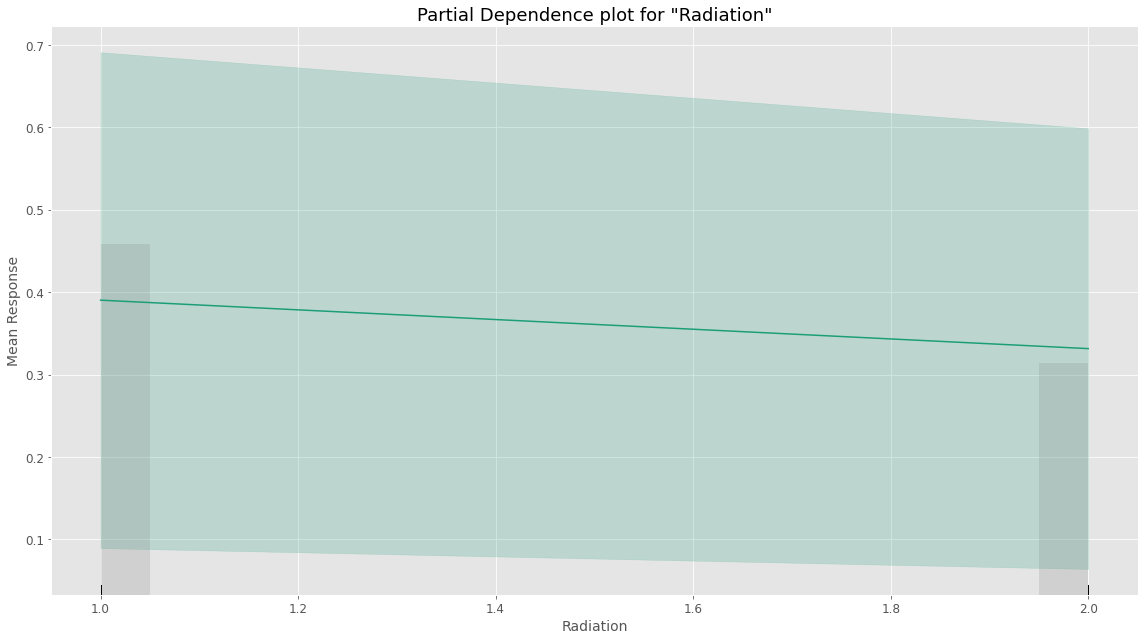

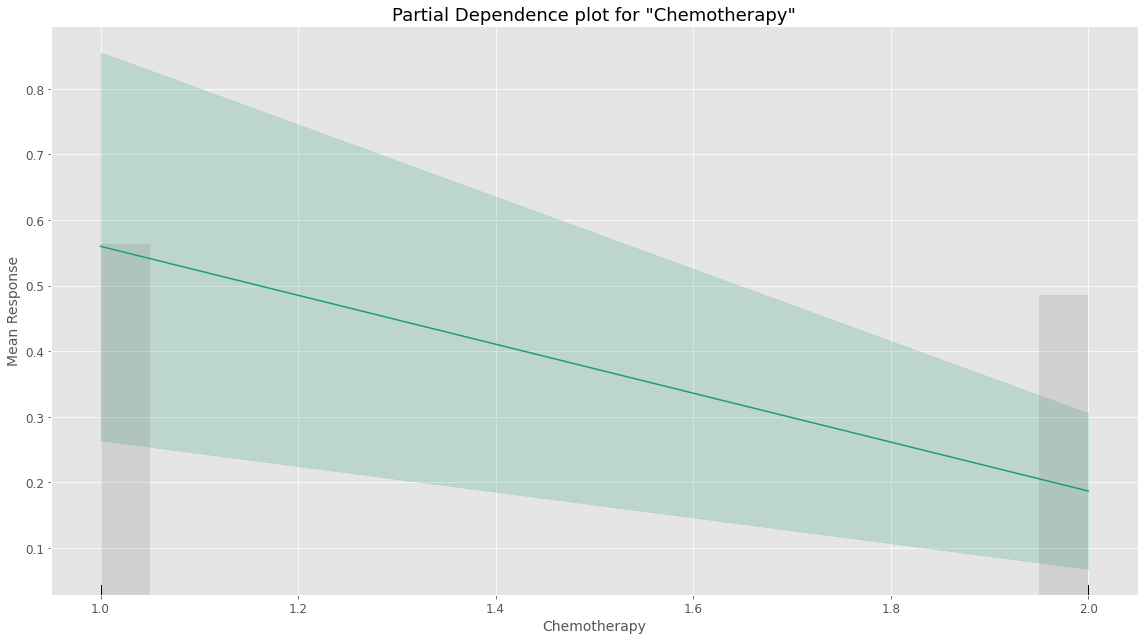

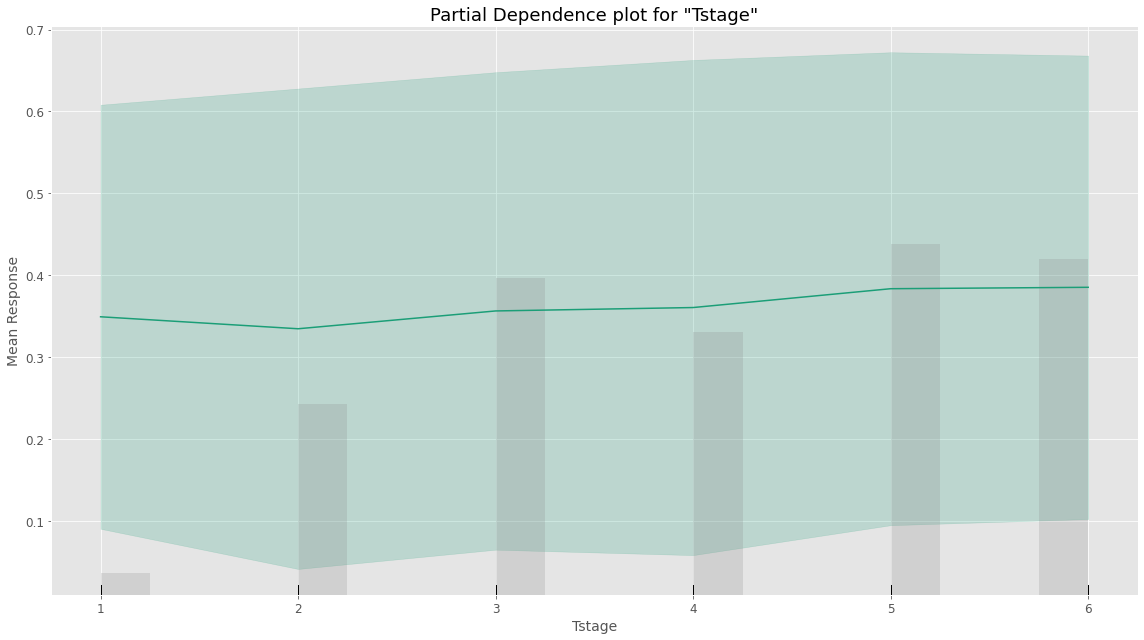

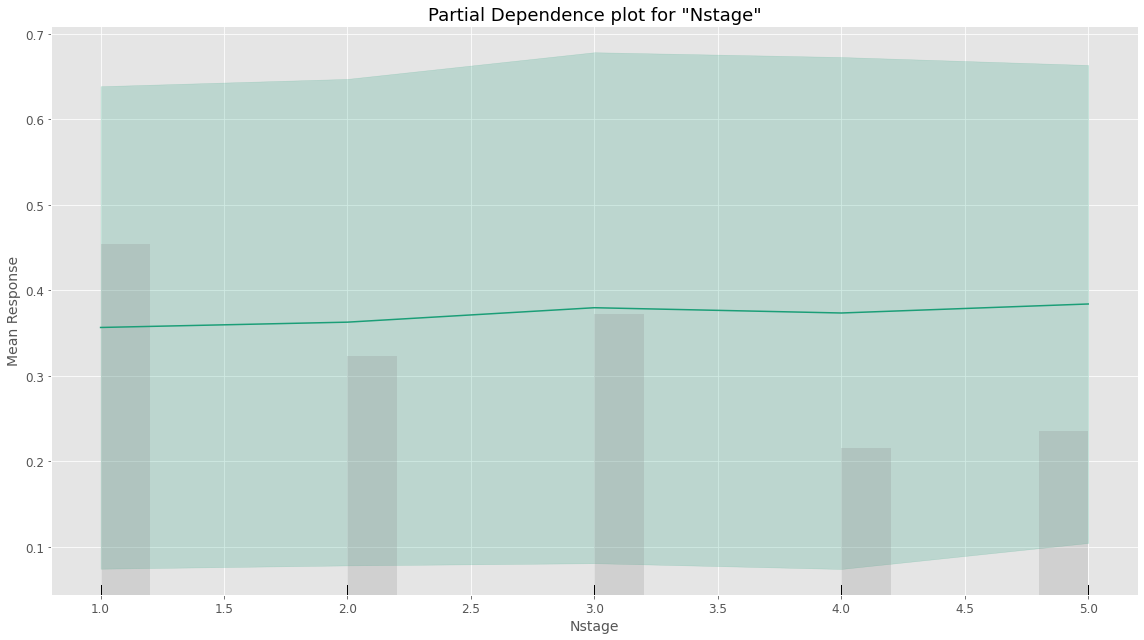

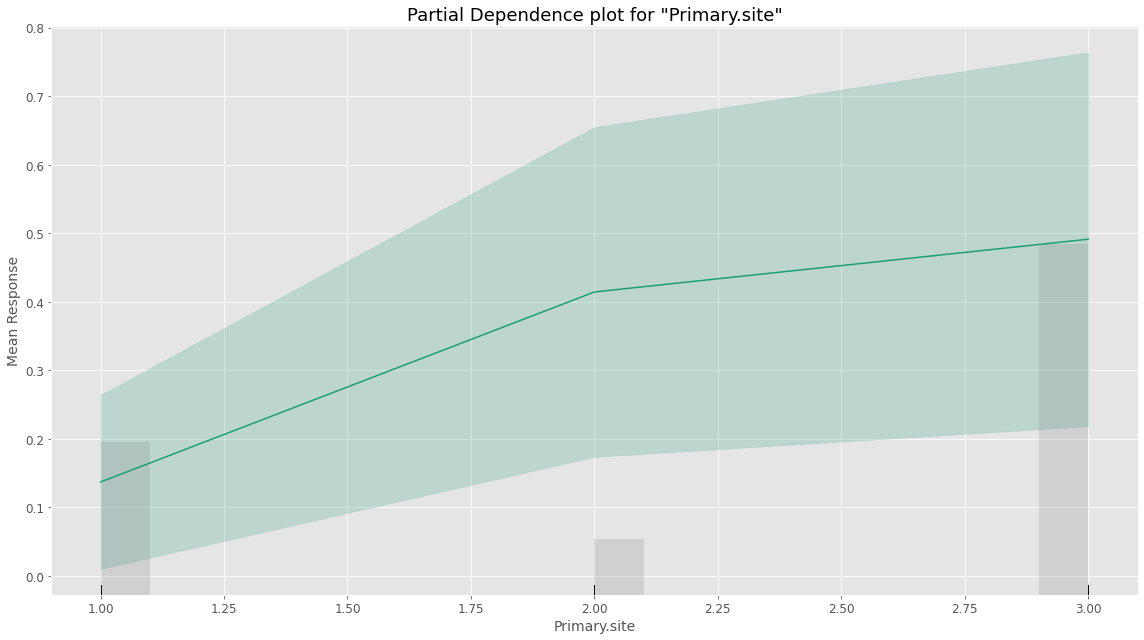

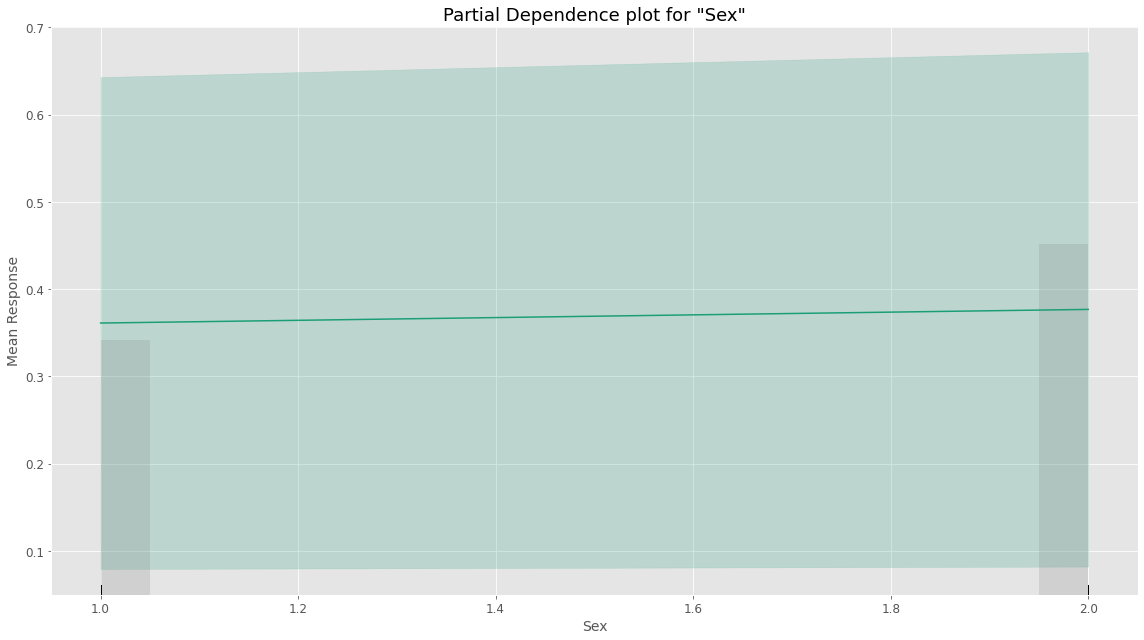

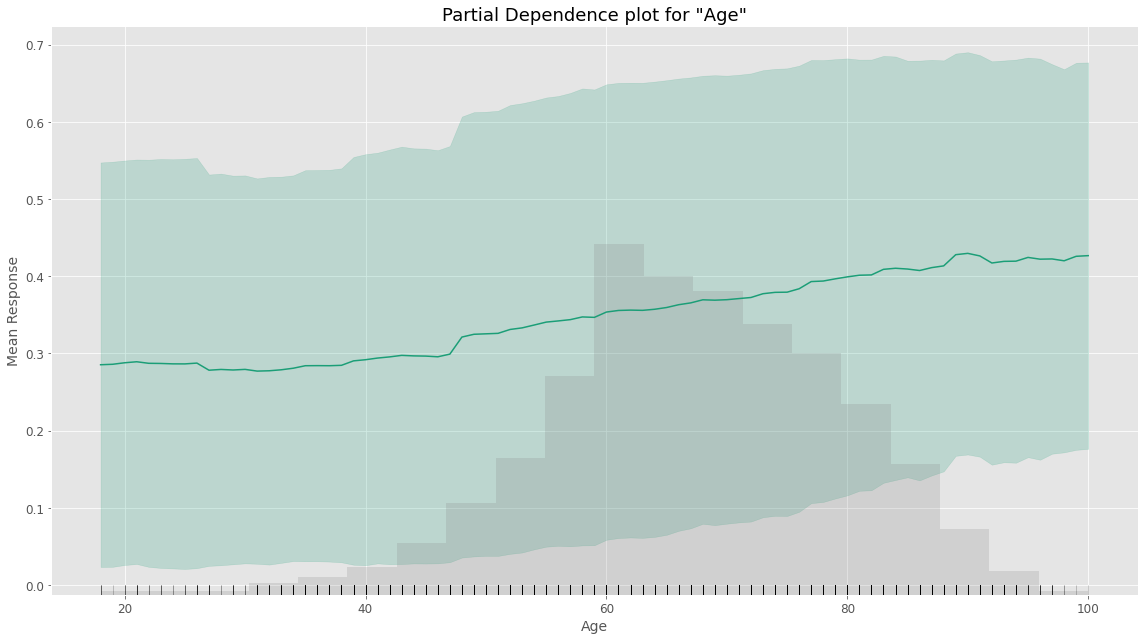

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

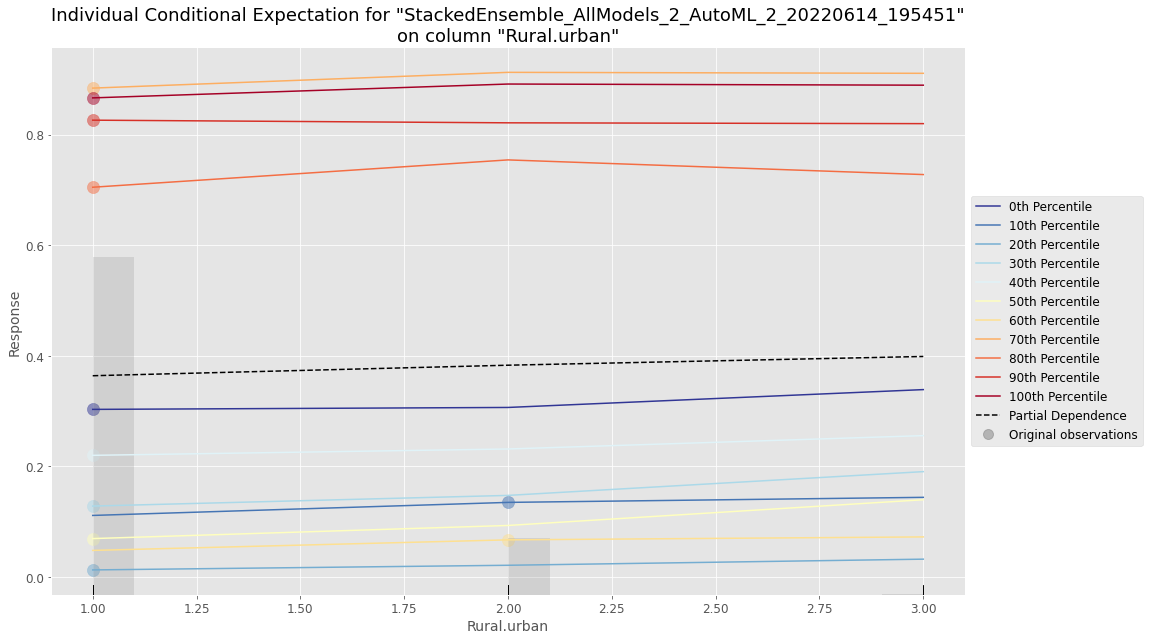

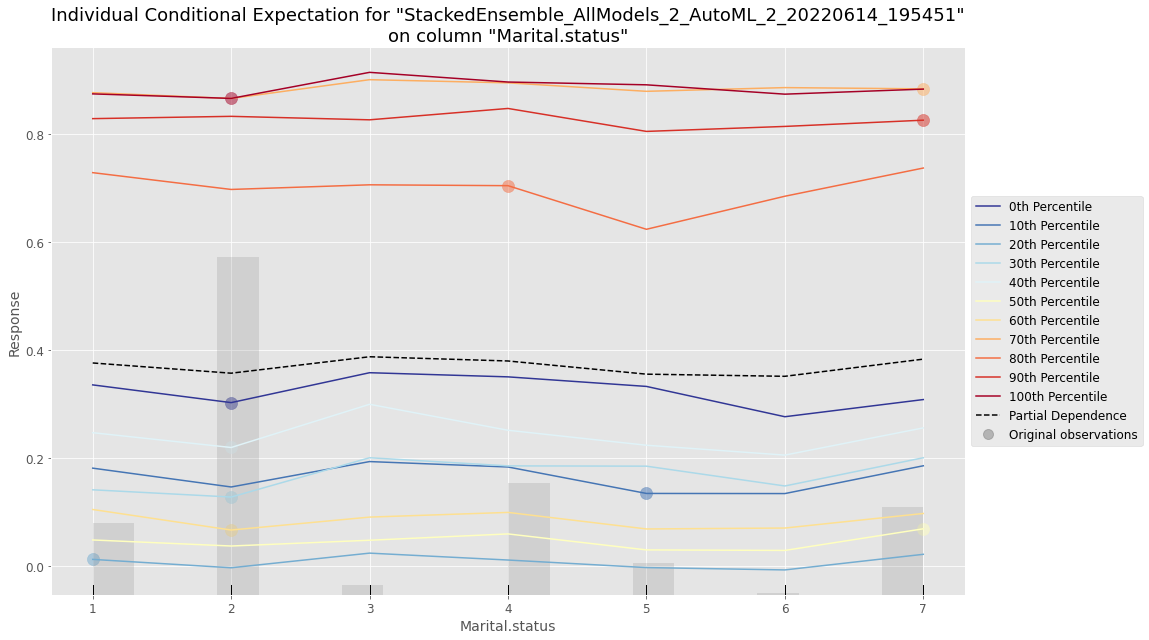

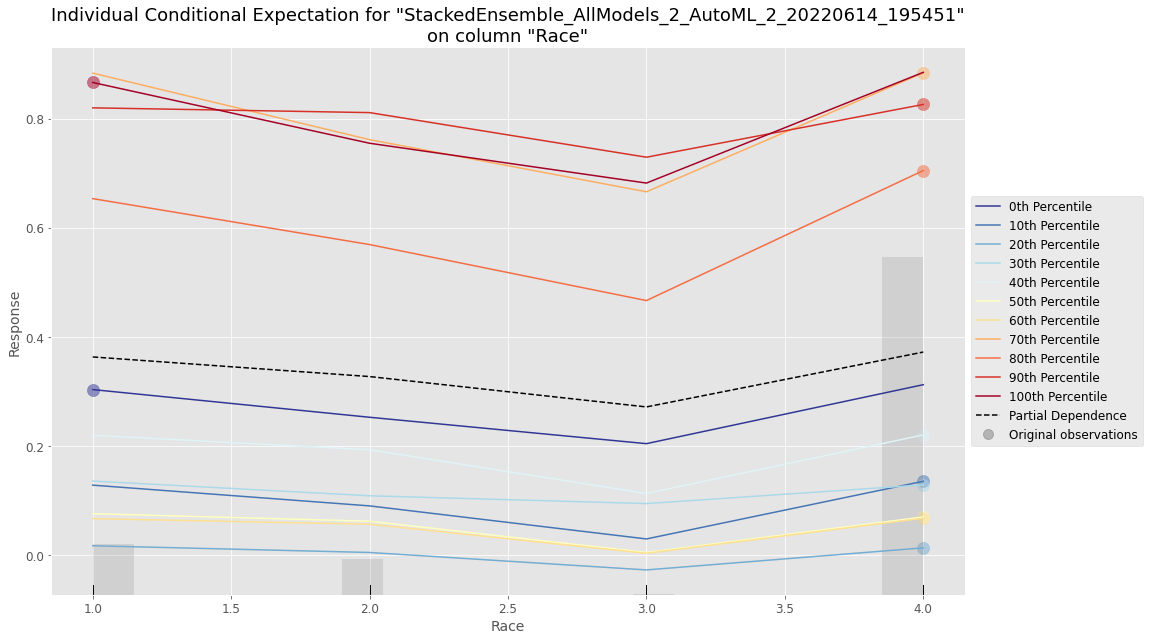

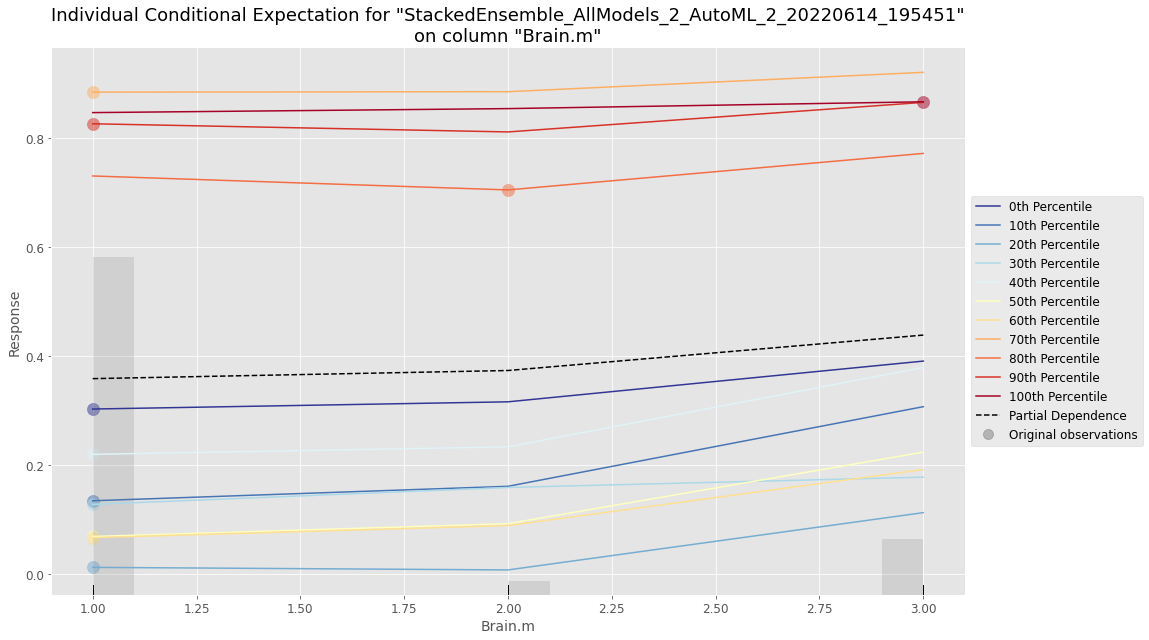

Exception ignored in: <function ExprNode.__del__ at 0x000001F2F9AFA160>
Traceback (most recent call last):
  File "C:\Users\63276\anaconda3\lib\site-packages\h2o\expr.py", line 204, in __del__
    ExprNode.rapids("(rm {})".format(self._cache._id))
  File "C:\Users\63276\anaconda3\lib\site-packages\h2o\expr.py", line 258, in rapids
    return h2o.api("POST /99/Rapids", data={"ast": expr, "session_id": h2o.connection().session_id})
  File "C:\Users\63276\anaconda3\lib\site-packages\h2o\h2o.py", line 124, in api
    return h2oconn.request(endpoint, data=data, json=json, filename=filename, save_to=save_to)
  File "C:\Users\63276\anaconda3\lib\site-packages\h2o\backend\connection.py", line 472, in request
    resp = requests.request(method=method, url=url, data=data, json=json, files=files, params=params,
  File "C:\Users\63276\anaconda3\lib\site-packages\requests\api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "C:\Users\63276\anaconda3\lib\s

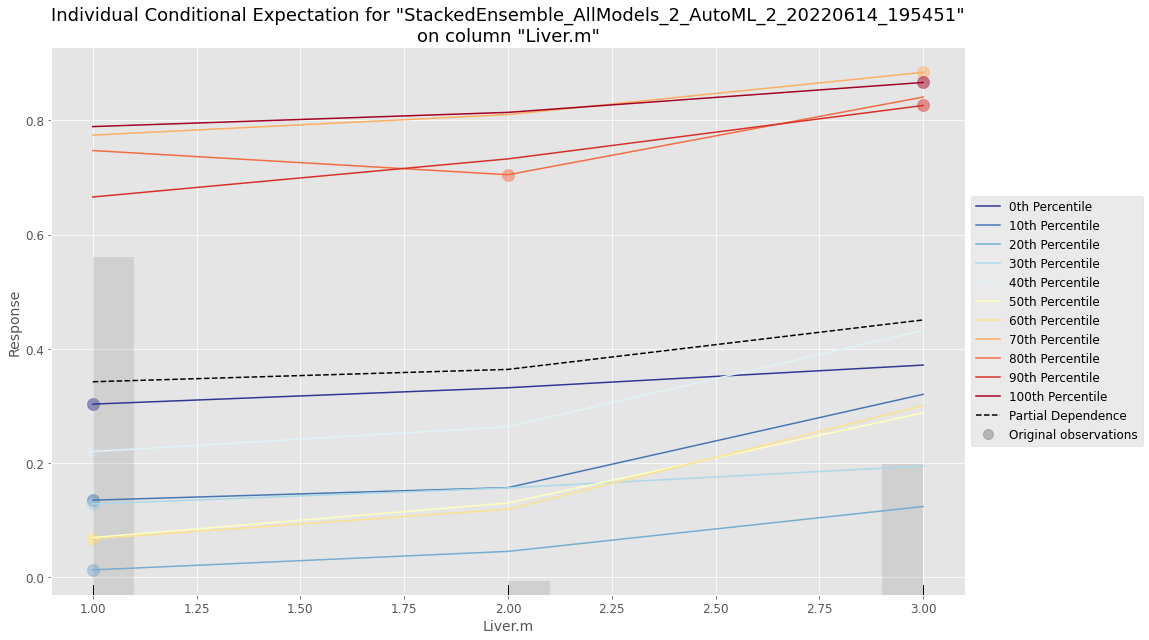

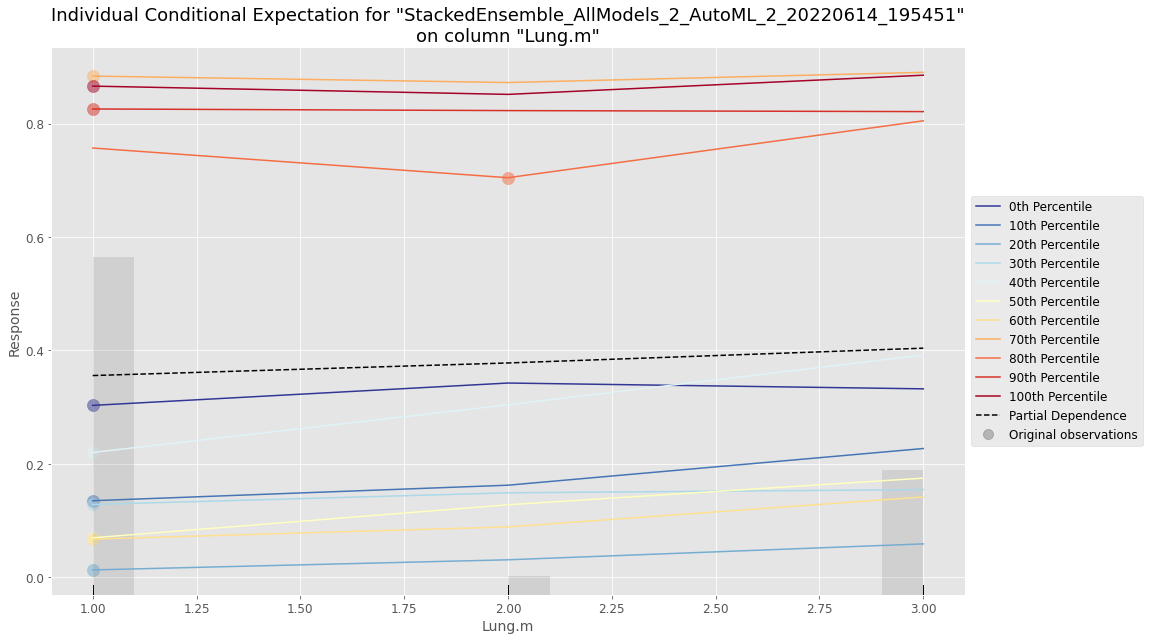

In [ ]:
# Explain a single H2O model (e.g. leader model from AutoML)
exm = aml.leader.explain(data_test)

# Explain a generic list of models
# use h2o.explain as follows:
# exl = h2o.explain(model_list, test)

In [ ]:
va_plot = aml.varimp_heatmap()

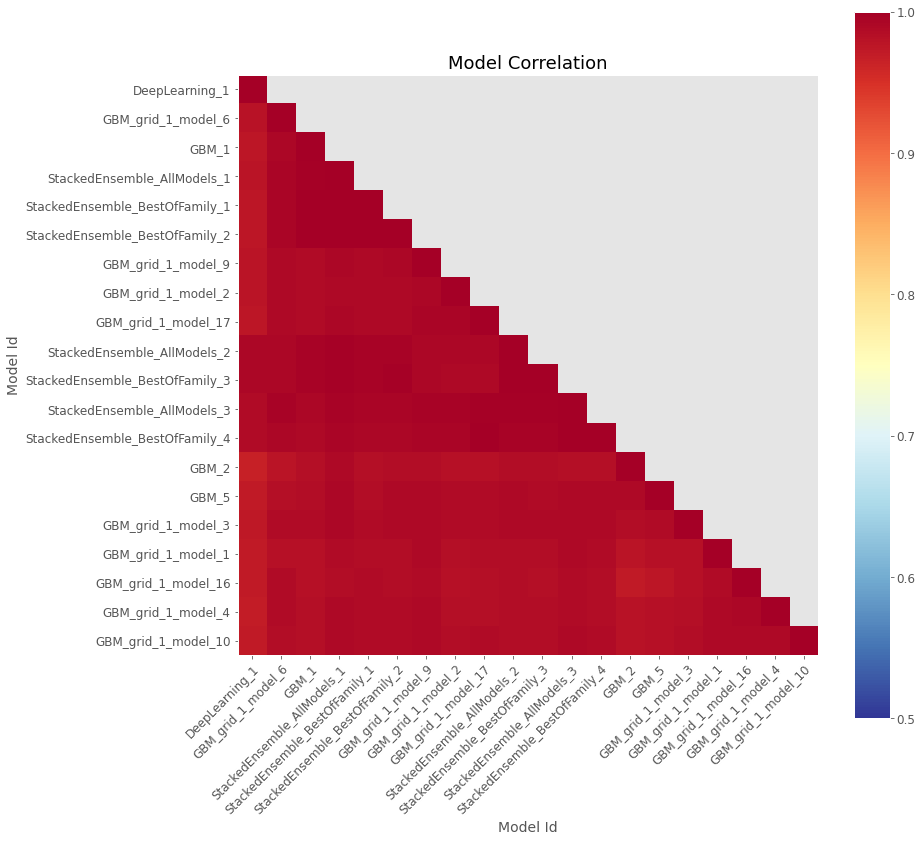

In [52]:
#mc_plot = aml.model_correlation_heatmap(data_test)

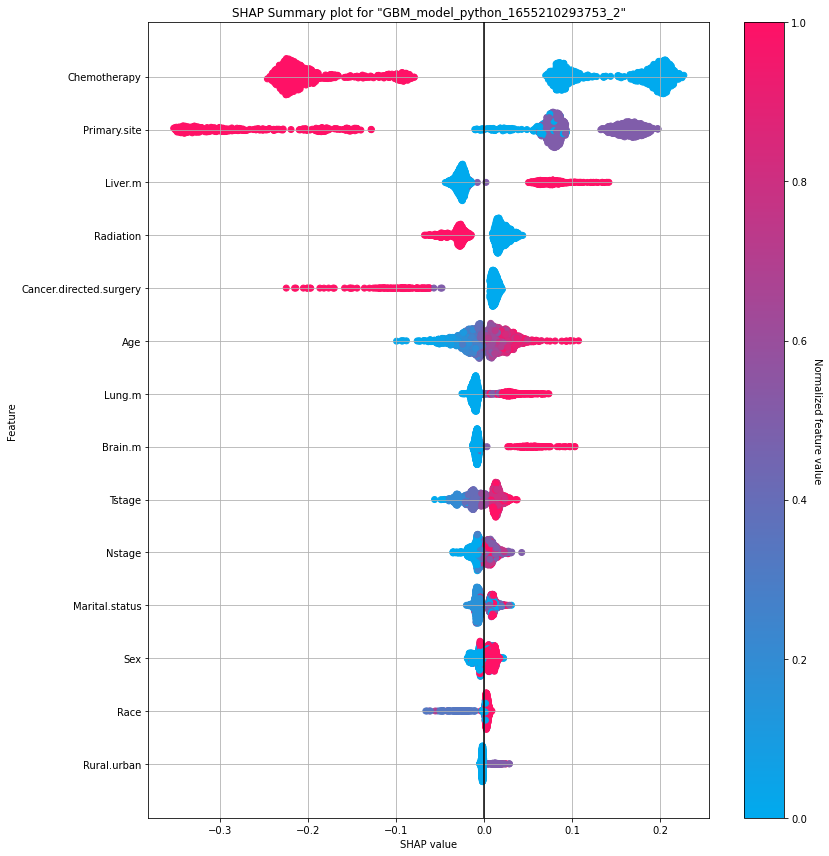

In [27]:
shap_plot = model.shap_summary_plot(data_test)

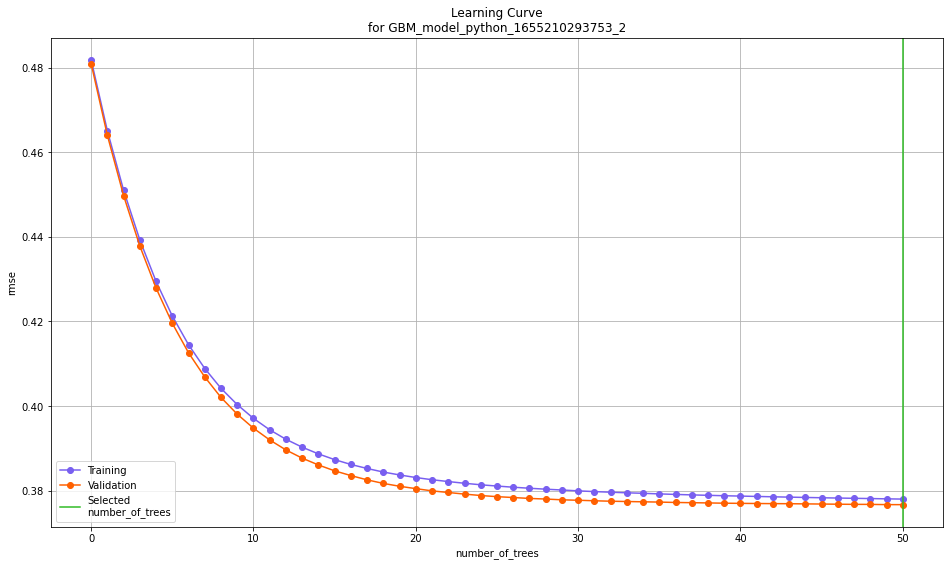

In [28]:
learning_curve_plot = model.learning_curve_plot()

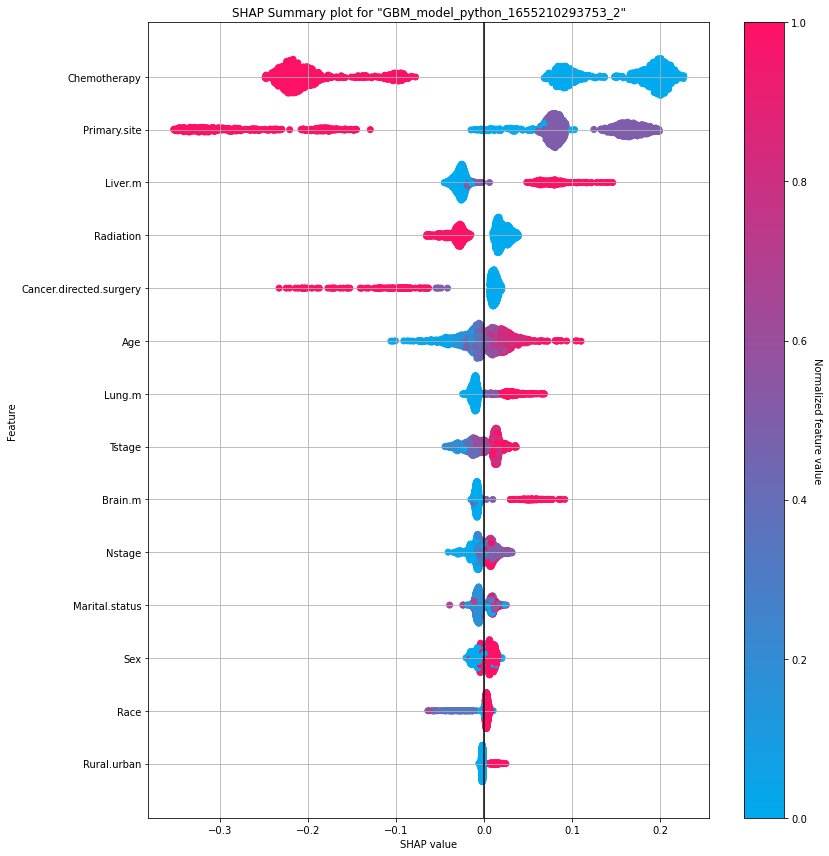

In [29]:
shap_plot = model.shap_summary_plot(data_train)

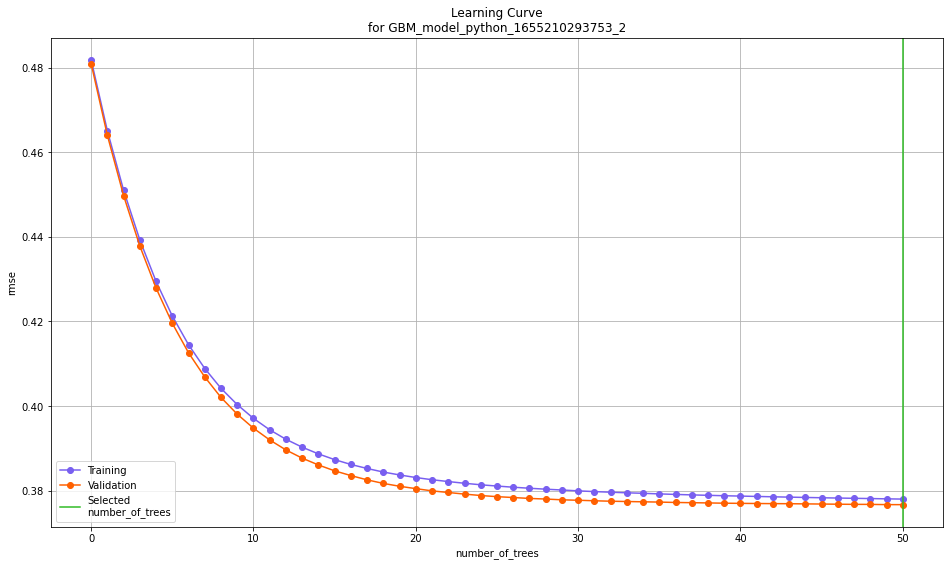

In [30]:
learning_curve_plot = model.learning_curve_plot()

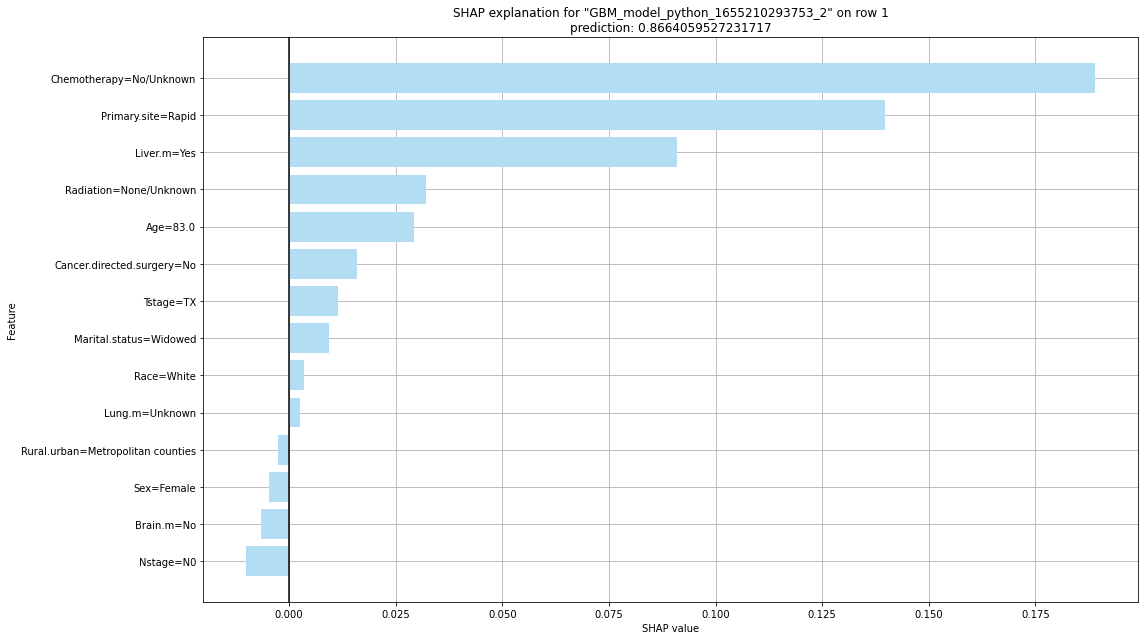

In [31]:
shapr_plot = model.shap_explain_row_plot(data_test, row_index=1)

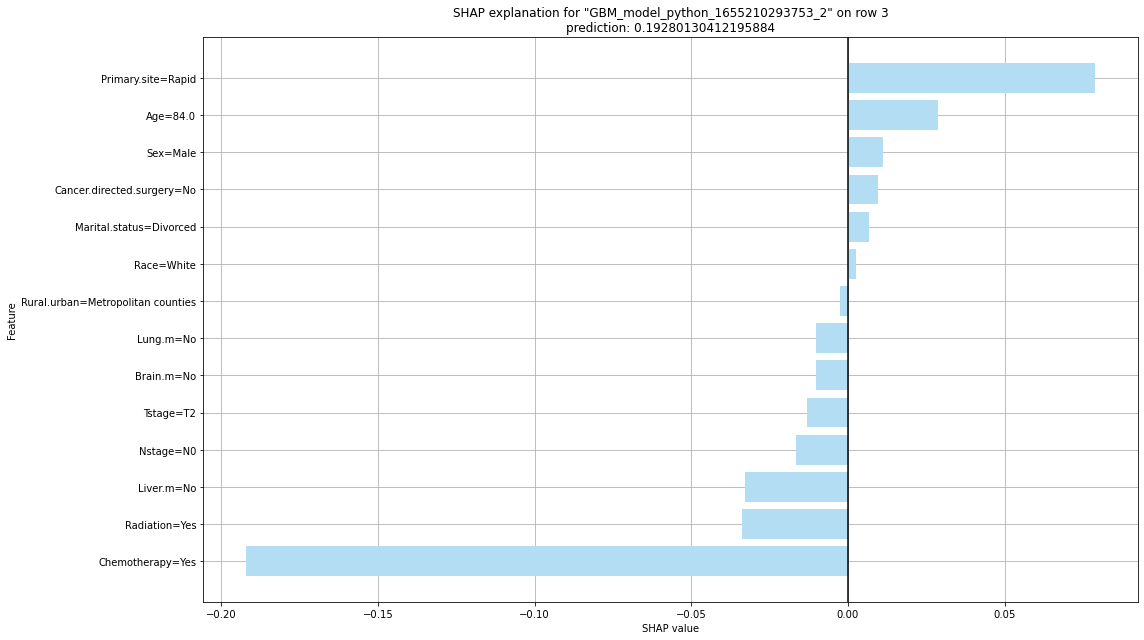

In [32]:
shapr_plot = model.shap_explain_row_plot(data_test, row_index=3)

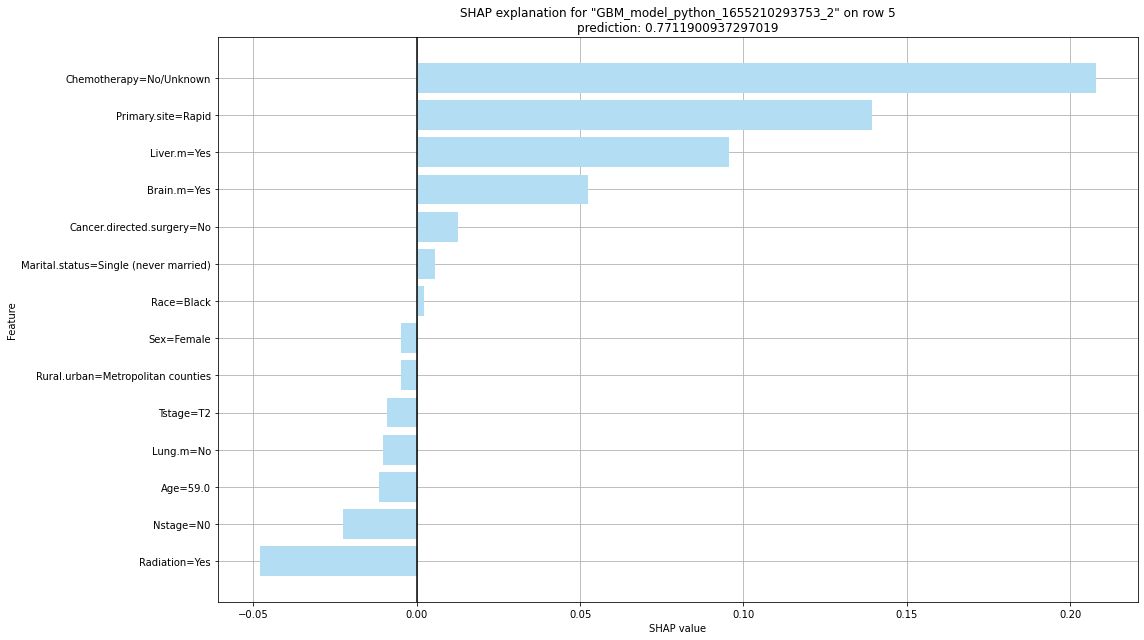

In [33]:
shapr_plot = model.shap_explain_row_plot(data_test, row_index=5)

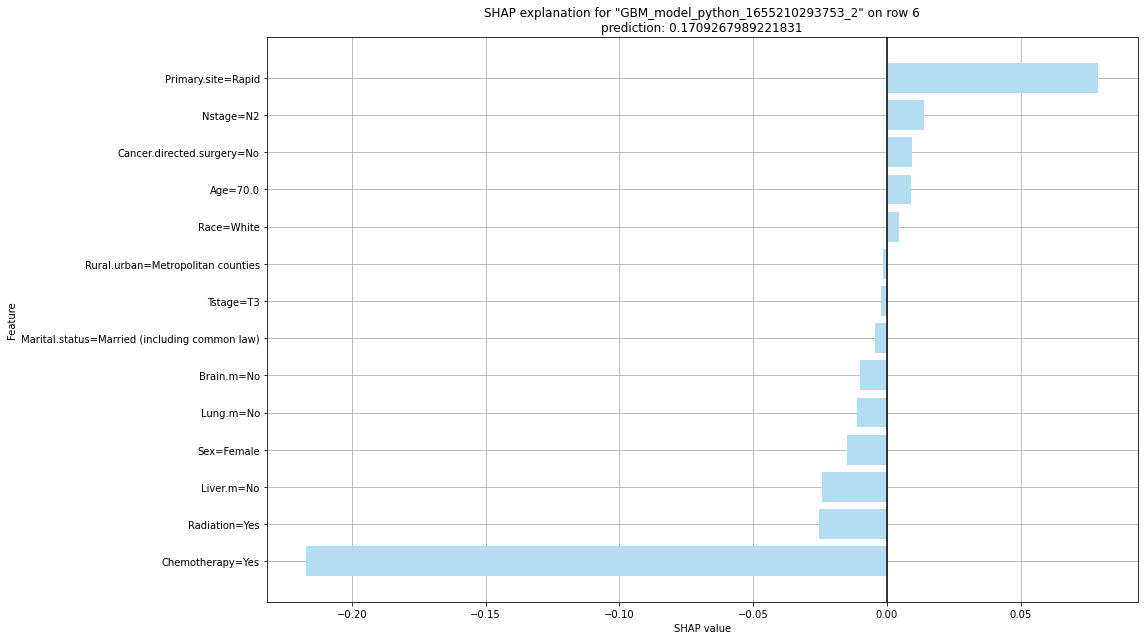

In [34]:
shapr_plot = model.shap_explain_row_plot(data_test, row_index=6)

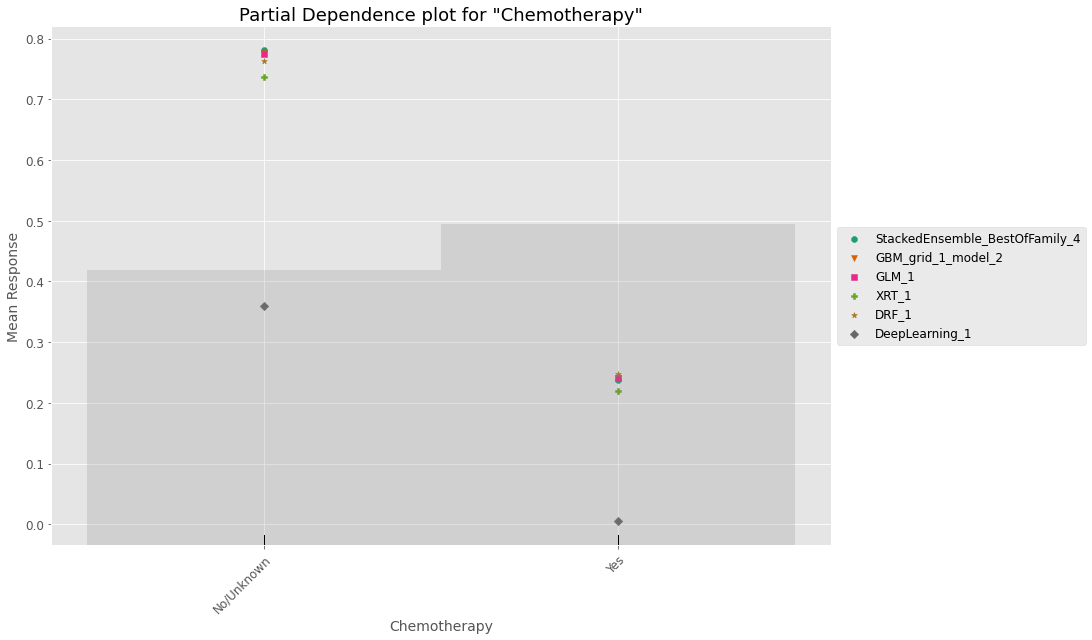

In [157]:
pd_plot = aml.pd_multi_plot(data_test, "Chemotherapy")

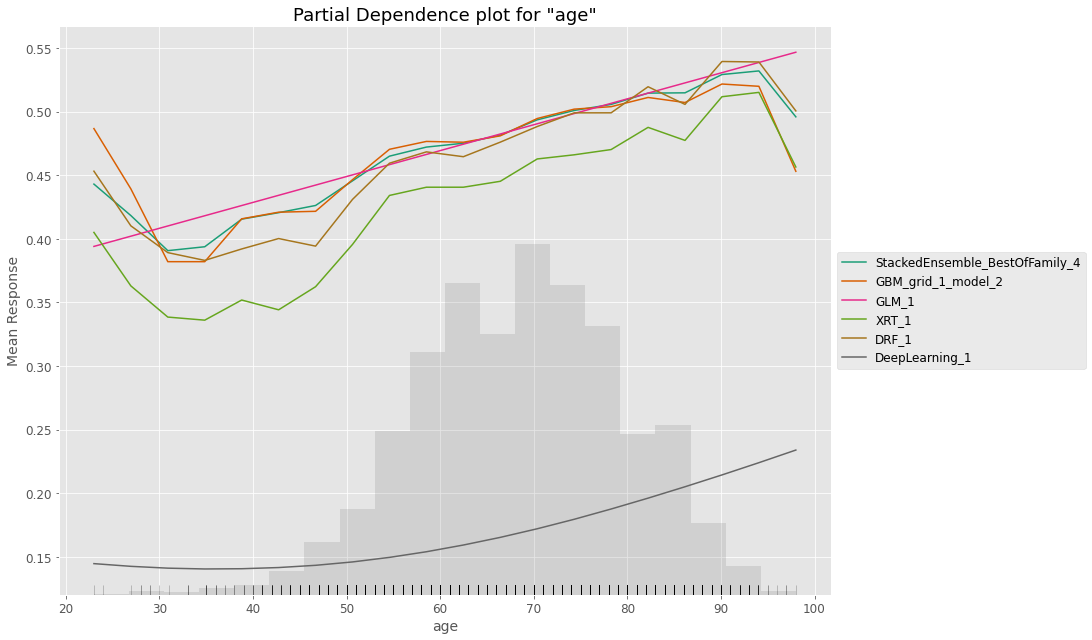

In [158]:
pd_plot = aml.pd_multi_plot(data_test, "age")

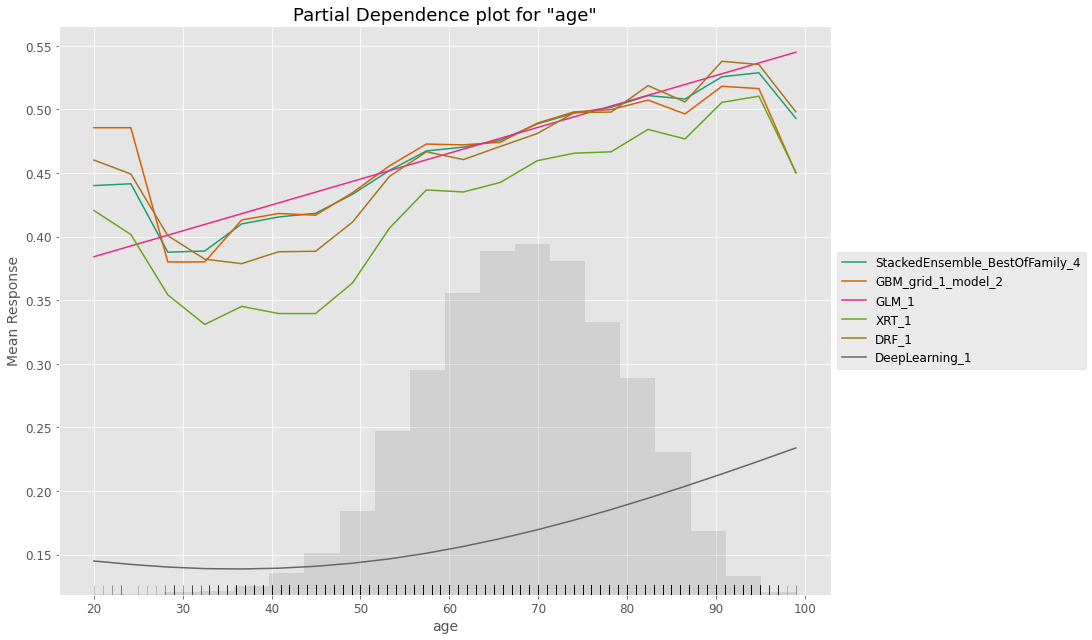

In [159]:
pd_plot = aml.pd_multi_plot(data_train, "age")

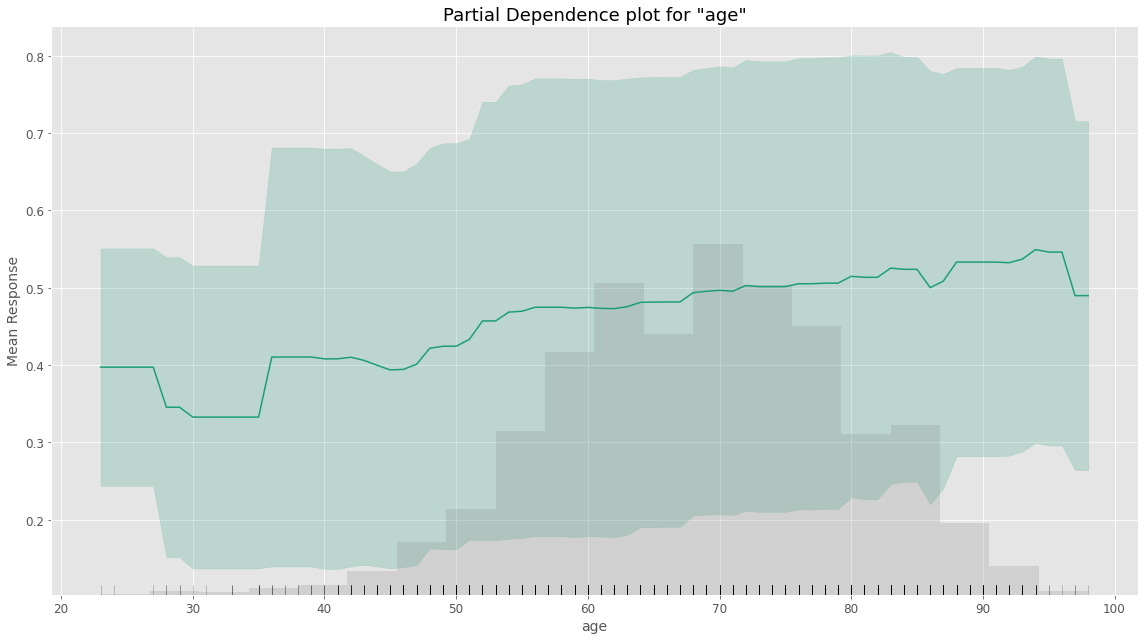

In [160]:
pd_plot = model.pd_plot(data_test, "age")

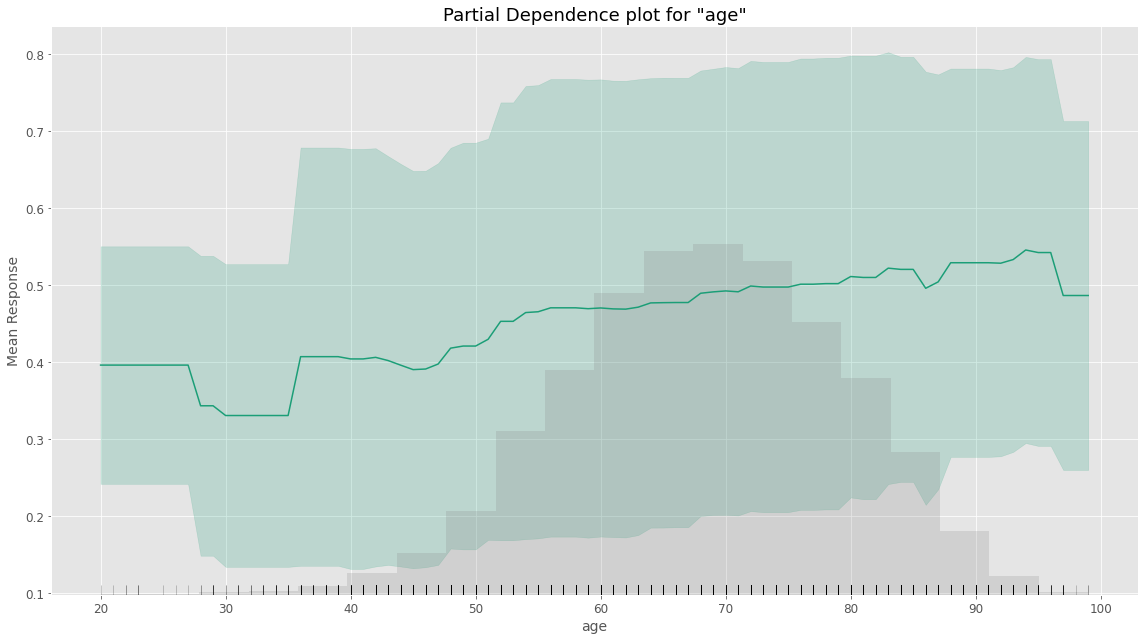

In [161]:
pd_plot = model.pd_plot(data_train, "age")

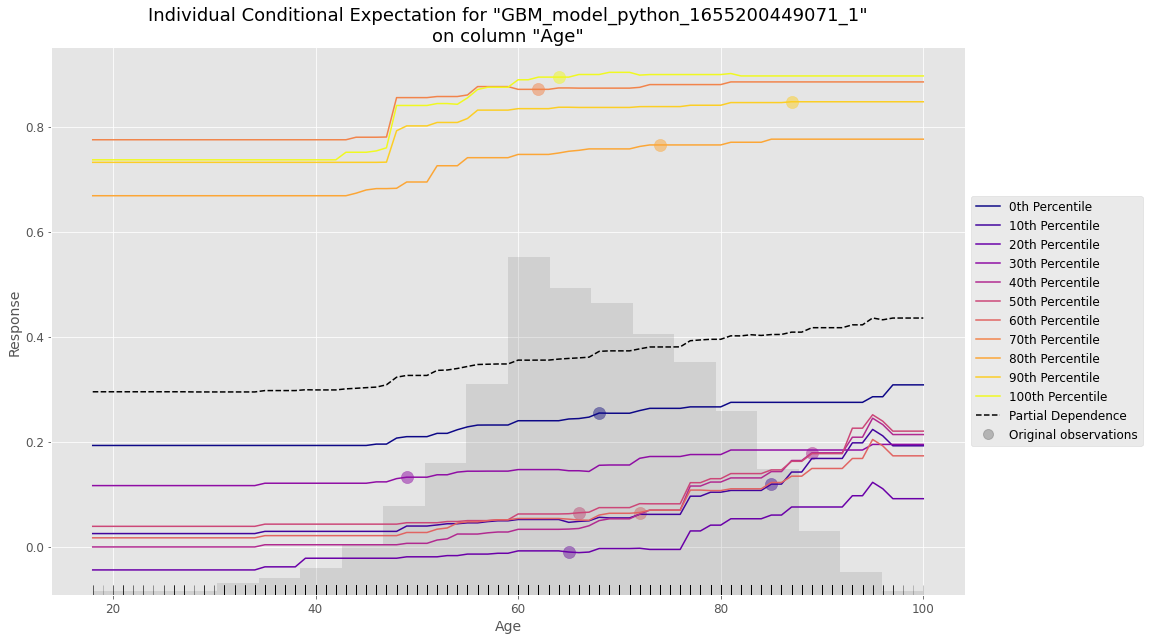

In [27]:
ice_plot = model.ice_plot(data_test, "Age")

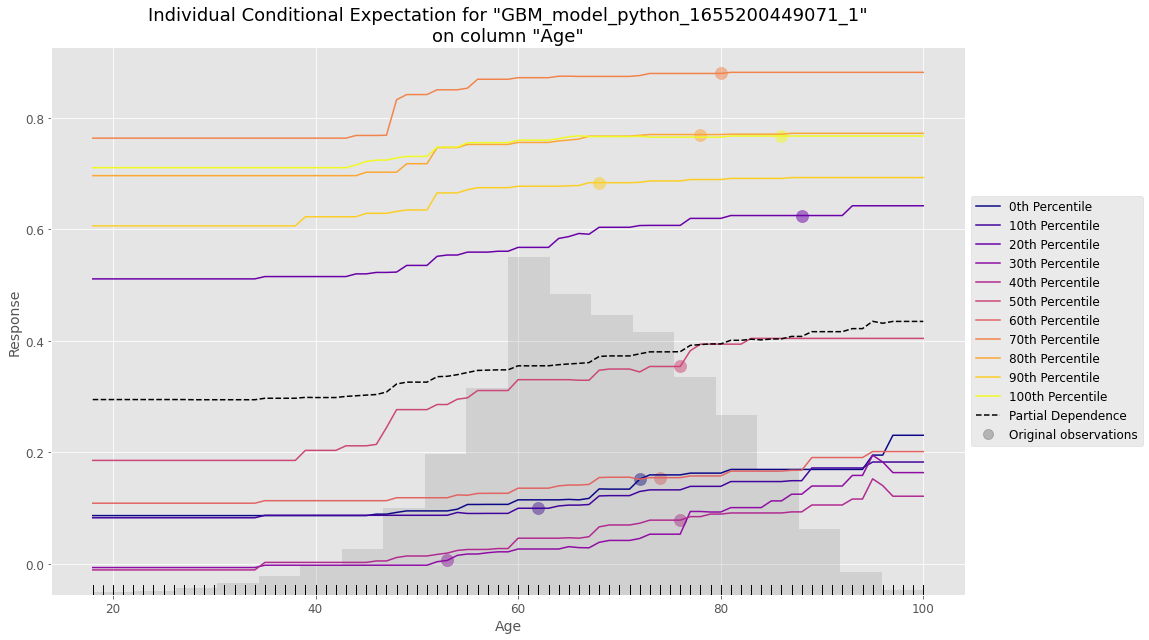

In [28]:
ice_plot = model.ice_plot(data_train, "Age")

In [85]:
# Create h2o dataframes. Make sure to run the "Compute and Compare test metrics" cells to create data_test_X 
# before running these cells##data_test在下方绘制ROC曲线前面有。

htrain = h2o.H2OFrame(pd.concat([data_train_X, data_train['anxietyanddepression']], axis=1))
htest = h2o.H2OFrame(pd.concat([data_test_X, data_test['anxietyanddepression']], axis=1))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [86]:
# define cols
x = htrain.columns
y = 'anxietyanddepression'
x.remove(y)

In [87]:
htrain[y] = htrain[y].asfactor()
htest[y] = htest[y].asfactor()

In [34]:
# Train Deep Learners for 5 hous##确实需要5个小时
aml_gbm_deep = H2OAutoML(max_runtime_secs = 18000, exclude_algos=['GLM','GBM','DRF','StackedEnsemble'])
aml_gbm_deep.train(x=x, y=y, training_frame=htrain, leaderboard_frame=htest)

AutoML progress: |
12:26:15.115: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_2_20220504_122615_model_210


Status of Neuron Layers: predicting anxietyanddepression, 2-class classification, bernoulli distribution, CrossEntropy loss, 222 weights/biases, 6.3 KB, 9,289,280 training samples, mini-batch size 1


layer  units              type dropout   l1   l2 mean_rate  rate_rms  \
0        1      8             Input    20.0                                 
1        2     20  RectifierDropout    10.0  0.0  0.0   0.00323  0.010163   
2        3      2           Softmax          0.0  0.0   0.08771  0.206028   

  momentum mean_weight weight_rms  mean_bias  bias_rms  
0                                                       
1      0.0    0.086401   0.875263  -2.097864  1.429163  
2      0.0   -0.736752   8.430927 -14.894226  0.577911



ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.03626699933733746
RMSE: 0.1904389648610217
LogLoss: 0.11852131036743513
Mean Per-Class Error: 0.04863900671367173
AUC: 0.9885846512542488
AUCPR: 0.9661527972111967
Gini: 0.9771693025084975

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23679862571633672: 


0      1   Error           Rate
0      0  708.0   26.0  0.0354   (26.0/734.0)
1      1   12.0  182.0  0.0619   (12.0/194.0)
2  Total  720.0  208.0  0.0409   (38.0/928.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric     threshold       value   idx
0                        max f1  2.367986e-01    0.905473  20.0
1                        max f2  7.390813e-02    0.925000  21.0
2                  max f0point5  6.595001e-01    0.931759  15.0
3                  max accuracy  2.367986e-01    0.959052  20.0
4                 max precision  1.000000e+00    1.000000   0.0
5                    max recall  1.791230e-02    1.000000  29.0
6               max specificity  1.000000e+00    1.000000   0.0
7              max absolute_mcc  2.367986e-01    0.880248  20.0
8    max min_per_class_accuracy  7.390813e-02    0.946866  21.0
9   max mean_per_class_accuracy  2.367986e-01    0.951361  20.0
10                      max tns  1.000000e+00  734.000000   0.0
11                      max fns  1.000000e+00  157.000000   0.0
12                      max fps  4.400672e-37  734.000000  92.0
13                      max tps  1.791230e-02  194.000000  29.0
14                      max tnr  1.000000e+00    1.000000   0.0
15                      max fnr  1.000000e+00    0.809278   0.0
16                      max fpr  4.400672e-37    1.000000  92.0
17                      max tpr  1.791230e-02    1.000000  29.0


Gains/Lift Table: Avg response rate: 20.91 %, avg score: 17.67 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.014009     1.000000e+00  4.783505   
1       2                  0.023707     1.000000e+00  4.783505   
2       3                  0.039871     1.000000e+00  4.783505   
3       4                  0.043103     9.999979e-01  4.783505   
4       5                  0.052802     9.999709e-01  4.783505   
5       6                  0.104526     9.957791e-01  4.783505   
6       7                  0.153017     6.595001e-01  4.783505   
7       8                  0.213362     3.127676e-01  2.904271   
8       9                  0.320043     2.300894e-02  0.434864   
9      10                  0.401940     2.749230e-04  0.566468   
10     11                  0.501078     3.584827e-06  0.000000   
11     12                  0.614224     5.043408e-08  0.000000   
12     13                  0.705819     1.130306e-08  0.000000   
13     14                  0.807112     1.395538e-12  0.000000   
14     15                  0.907328     5.280941e-16  0.000000   
15     16                  1.000000     4.400672e-37  0.000000   

    cumulative_lift  response_rate         score  cumulative_response_rate  \
0          4.783505       1.000000  1.000000e+00                  1.000000   
1          4.783505       1.000000  1.000000e+00                  1.000000   
2          4.783505       1.000000  1.000000e+00                  1.000000   
3          4.783505       1.000000  9.999979e-01                  1.000000   
4          4.783505       1.000000  9.999709e-01                  1.000000   
5          4.783505       1.000000  9.982123e-01                  1.000000   
6          4.783505       1.000000  8.585557e-01                  1.000000   
7          4.252005       0.607143  3.884375e-01                  0.888889   
8          2.979624       0.090909  6.251977e-02                  0.622896   
9          2.487936       0.118421  5.845301e-03                  0.520107   
10         1.995699       0.000000  5.787909e-05                  0.417204   
11         1.628070       0.000000  2.477944e-07                  0.340351   
12         1.416794       0.000000  1.683982e-08                  0.296183   
13         1.238985       0.000000  2.413662e-09                  0.259012   
14         1.102138       0.000000  2.332738e-13                  0.230404   
15         1.000000       0.000000  1.519350e-17                  0.209052   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           1.000000      0.067010                 0.067010  378.350515   
1           1.000000      0.046392                 0.113402  378.350515   
2           1.000000      0.077320                 0.190722  378.350515   
3           1.000000      0.015464                 0.206186  378.350515   
4           0.999995      0.046392                 0.252577  378.350515   
5           0.999113      0.247423                 0.500000  378.350515   
6           0.954570      0.231959                 0.731959  378.350515   
7           0.794452      0.175258                 0.907216  190.427099   
8           0.550474      0.046392                 0.953608  -56.513590   
9           0.439504      0.046392                 1.000000  -43.353228   
10          0.352560      0.000000                 1.000000 -100.000000   
11          0.287615      0.000000                 1.000000 -100.000000   
12          0.250291      0.000000                 1.000000 -100.000000   
13          0.218879      0.000000                 1.000000 -100.000000   
14          0.194704      0.000000                 1.000000 -100.000000   
15          0.176660      0.000000                 1.000000 -100.000000   

    cumulative_gain  kolmogorov_smirnov  
0        378.350515            0.067010  
1        378.350515            0.113402  
2        378.350515            0.190722  
3        378.350515            0.206186  
4        378.350515            0.252577  
5        378.350515       



ModelMetricsBinomial: deeplearning
** Reported on cross-validation data. **

MSE: 0.03363513952679131
RMSE: 0.1833988536681495
LogLoss: 0.10846879151443826
Mean Per-Class Error: 0.06380797213404871
AUC: 0.9903052052023934
AUCPR: 0.9677309947508493
Gini: 0.9806104104047868

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4008855165894701: 


0      1   Error           Rate
0      0  716.0   18.0  0.0245   (18.0/734.0)
1      1   20.0  174.0  0.1031   (20.0/194.0)
2  Total  736.0  192.0  0.0409   (38.0/928.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric     threshold       value    idx
0                        max f1  4.008855e-01    0.901554   79.0
1                        max f2  1.250840e-01    0.939664   94.0
2                  max f0point5  5.609593e-01    0.915663   71.0
3                  max accuracy  4.008855e-01    0.959052   79.0
4                 max precision  1.000000e+00    1.000000    0.0
5                    max recall  4.781098e-03    1.000000  143.0
6               max specificity  1.000000e+00    1.000000    0.0
7              max absolute_mcc  4.008855e-01    0.875724   79.0
8    max min_per_class_accuracy  1.810614e-01    0.948229   89.0
9   max mean_per_class_accuracy  1.250840e-01    0.959037   94.0
10                      max tns  1.000000e+00  734.000000    0.0
11                      max fns  1.000000e+00  182.000000    0.0
12                      max fps  4.317848e-32  734.000000  370.0
13                      max tps  4.781098e-03  194.000000  143.0
14                      max tnr  1.000000e+00    1.000000    0.0
15                      max fnr  1.000000e+00    0.938144    0.0
16                      max fpr  4.317848e-32    1.000000  370.0
17                      max tpr  4.781098e-03    1.000000  143.0


Gains/Lift Table: Avg response rate: 20.91 %, avg score: 18.86 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.012931     1.000000e+00  4.783505   
1       2                  0.021552     9.999997e-01  4.783505   
2       3                  0.031250     9.999902e-01  4.783505   
3       4                  0.042026     9.999558e-01  4.783505   
4       5                  0.050647     9.995930e-01  4.783505   
5       6                  0.100216     9.709244e-01  4.783505   
6       7                  0.150862     6.404694e-01  4.579952   
7       8                  0.206897     4.008855e-01  3.311657   
8       9                  0.300647     4.457064e-02  0.934708   
9      10                  0.399784     3.300818e-03  0.155984   
10     11                  0.500000     1.503300e-04  0.000000   
11     12                  0.601293     2.060000e-06  0.000000   
12     13                  0.702586     1.000000e-07  0.000000   
13     14                  1.000000     0.000000e+00  0.000000   

    cumulative_lift  response_rate         score  cumulative_response_rate  \
0          4.783505       1.000000  1.000000e+00                  1.000000   
1          4.783505       1.000000  9.999998e-01                  1.000000   
2          4.783505       1.000000  9.999936e-01                  1.000000   
3          4.783505       1.000000  9.999695e-01                  1.000000   
4          4.783505       1.000000  9.997515e-01                  1.000000   
5          4.783505       1.000000  9.888939e-01                  1.000000   
6          4.715169       0.957447  8.476603e-01                  0.985714   
7          4.335052       0.692308  5.139004e-01                  0.906250   
8          3.274729       0.195402  1.608568e-01                  0.684588   
9          2.501348       0.032609  2.006355e-02                  0.522911   
10         2.000000       0.000000  1.092265e-03                  0.418103   
11         1.663082       0.000000  3.495862e-05                  0.347670   
12         1.423313       0.000000  5.221277e-07                  0.297546   
13         1.000000       0.000000  6.413043e-09                  0.209052   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           1.000000      0.061856                 0.061856  378.350515   
1           1.000000      0.041237                 0.103093  378.350515   
2           0.999998      0.046392                 0.149485  378.350515   
3           0.999991      0.051546                 0.201031  378.350515   
4           0.999950      0.041237                 0.242268  378.350515   
5           0.994481      0.237113                 0.479381  378.350515   
6           0.945191      0.231959                 0.711340  357.995174   
7           0.828383      0.185567                 0.896907  231.165741   
8           0.620230      0.087629                 0.984536   -6.529210   
9           0.471402      0.015464                 1.000000  -84.401614   
10          0.377137      0.000000                 1.000000 -100.000000   
11          0.313611      0.000000                 1.000000 -100.000000   
12          0.268397      0.000000                 1.000000 -100.000000   
13          0.188572      0.000000                 1.000000 -100.000000   

    cumulative_gain  kolmogorov_smirnov  
0        378.350515            0.061856  
1        378.350515            0.103093  
2        378.350515            0.149485  
3        378.350515            0.201031  
4        378.350515            0.242268  
5        378.350515            0.479381  
6        371.516937            0.708615  
7        333.505155            0.872384  
8        227.472934            0.864645  
9        150.134771            0.758856  
10       100.000000            0.632153  
11        66.308244            0.504087  
12        42.331288            0.376022  
13         0.000000            0.000000



Cross-Validation Metrics Summary: 


mean        sd  cv_1_valid  cv_2_valid  \
0                  accuracy  0.965504  0.018916    0.946237    0.973118   
1                       auc  0.990529  0.007502    0.989756    0.992926   
2                       err  0.034496  0.018916    0.053763    0.026882   
3                 err_count  6.400000  3.507136   10.000000    5.000000   
4                  f0point5  0.898885  0.050840    0.879828    0.913706   
5                        f1  0.920498  0.043224    0.891304    0.935065   
6                        f2  0.943481  0.036743    0.903084    0.957447   
7            lift_top_group  4.827624  0.503156    4.133333    5.027027   
8                   logloss  0.108532  0.041418    0.119615    0.078004   
9       max_per_class_error  0.043112  0.030494    0.088889    0.027027   
10                      mcc  0.899946  0.054030    0.855969    0.919257   
11  mean_per_class_accuracy  0.963503  0.023916    0.934279    0.973064   
12     mean_per_class_error  0.036497  0.023916    0.065721    0.026936   
13                      mse  0.033657  0.015169    0.039640    0.023986   
14                   pr_auc  0.964209  0.032343    0.968658    0.974079   
15                precision  0.885166  0.055959    0.872340    0.900000   
16                       r2  0.792628  0.103915    0.783861    0.849477   
17                   recall  0.959647  0.034207    0.911111    0.972973   
18                     rmse  0.179757  0.040996    0.199099    0.154875   
19              specificity  0.967360  0.015267    0.957447    0.973154   

    cv_3_valid  cv_4_valid  cv_5_valid  
0     0.989247    0.945946    0.972973  
1     0.999411    0.978769    0.991782  
2     0.010753    0.054054    0.027027  
3     2.000000   10.000000    5.000000  
4     0.962441    0.824742    0.913706  
5     0.976190    0.864865    0.935065  
6     0.990338    0.909091    0.957447  
7     4.536585    5.441176    5.000000  
8     0.069500    0.173644    0.101895  
9     0.013793    0.058824    0.027027  
10    0.969710    0.835647    0.919145  
11    0.993103    0.944098    0.972973  
12    0.006897    0.055902    0.027027  
13    0.017005    0.056214    0.031439  
14    0.997890    0.910370    0.970048  
15    0.953488    0.800000    0.900000  
16    0.901042    0.625257    0.803504  
17    1.000000    0.941176    0.972973  
18    0.130403    0.237095    0.177311  
19    0.986207    0.947020    0.972973


Scoring History: 


timestamp      duration   training_speed   epochs  iterations  \
0    2022-05-04 16:49:43     0.000 sec             None      0.0           0   
1    2022-05-04 16:49:43   4:23:28.366   488421 obs/sec     10.0           1   
2    2022-05-04 16:49:48   4:23:33.371  1058667 obs/sec   5720.0         572   
3    2022-05-04 16:49:51   4:23:36.222  1184403 obs/sec  10010.0        1001   

     samples  training_rmse  training_logloss  training_r2  training_auc  \
0        0.0            NaN               NaN          NaN           NaN   
1     9280.0       0.308202          0.326727     0.425529      0.910521   
2  5308160.0       0.166150          0.088929     0.833046      0.992180   
3  9289280.0       0.190439          0.118521     0.780664      0.988585   

   training_pr_auc  training_lift  training_classification_error  
0              NaN            NaN                            NaN  
1         0.717240       4.783505                       0.116379  
2         0.973096       4.783505                       0.032328  
3         0.966153       4.783505                       0.040948


Variable Importances: 


variable  relative_importance  scaled_importance  percentage
0      x16             1.000000           1.000000    0.266589
1       x5             0.650050           0.650050    0.173296
2       x1             0.436250           0.436250    0.116300
3       x2             0.405690           0.405690    0.108153
4       x9             0.383571           0.383571    0.102256
5      x15             0.325664           0.325664    0.086818
6       x6             0.295866           0.295866    0.078875
7       x7             0.253998           0.253998    0.067713

In [35]:
aml_gbm_deep.leaderboard

model_id auc logloss aucpr mean_per_class_error rmse mse 
 
 
 DeepLearning_grid_1_AutoML_2_20220504_122615_model_210 0.911569 0.650429 0.829819 0.141176 0.335595 0.112624 
 DeepLearning_grid_1_AutoML_2_20220504_122615_model_230 0.910784 1.30338 0.796974 0.142157 0.338173 0.114361 
 DeepLearning_grid_1_AutoML_2_20220504_122615_model_233 0.908824 0.688482 0.833737 0.157843 0.334221 0.111704 
 DeepLearning_grid_1_AutoML_2_20220504_122615_model_229 0.908039 0.85277 0.820322 0.144118 0.359286 0.129087 
 DeepLearning_grid_1_AutoML_2_20220504_122615_model_70 0.905686 0.63963 0.835672 0.17451 0.333746 0.111386 
 DeepLearning_grid_1_AutoML_2_20220504_122615_model_98 0.902157 0.904759 0.810404 0.181373 0.377911 0.142817 
 DeepLearning_grid_1_AutoML_2_20220504_122615_model_2 0.901765 0.628171 0.809244 0.158824 0.355345 0.12627 
 DeepLearning_grid_1_AutoML_2_20220504_122615_model_221 0.901765 0.870136 0.830955 0.163725 0.326345 0.106501 
 DeepLearning_grid_1_AutoML_2_20220504_122615_model_86 0.900588 0.698055 0.817229 0.17549 0.343384 0.117913 
 DeepLearning_grid_1_AutoML_2_20220504_122615_model_134 0.900588 0.99421 0.774945 0.17451 0.339348 0.115157

In [36]:
# Save best deep learner predictions
h2o_deep_pred = aml_gbm_deep.leader.predict(htest)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


In [37]:
# Save the model
model_path = h2o.save_model(model=aml_gbm_deep.leader, path='E:/R code-LMX/R code for SEER for publishing paper/Data/h2o_deep_learner_may31', force=True)

In [38]:
model_path

'E:\\h2o_deep_learner_may31\\DeepLearning_grid_1_AutoML_2_20220504_122615_model_210'

# Compute and compare test metrics

Transform test data set

In [81]:
data_test_X = pd.DataFrame(preproc_pipeline.transform(data_test), # it's imperative not to do fit_transfomr again
                           columns=categorical_vars + continuous_vars)

In [82]:
data_test_X.shape

(4006, 12)

In [83]:
data_test_X.head()

primarysite  Histology  race  Sex  tstage  nstage  brainm  liverm  surgery  \
0          2.0        2.0   4.0  2.0     6.0     5.0     3.0     3.0      1.0   
1          6.0        1.0   4.0  2.0     6.0     1.0     1.0     1.0      1.0   
2          6.0        1.0   1.0  1.0     6.0     5.0     1.0     1.0      1.0   
3          2.0        1.0   2.0  1.0     6.0     5.0     3.0     3.0      1.0   
4          4.0        1.0   2.0  2.0     6.0     1.0     1.0     1.0      1.0   

   Radiation  Chemotherapy       age  
0        1.0           1.0  0.863930  
1        1.0           1.0  1.406375  
2        1.0           1.0 -1.305851  
3        1.0           1.0 -0.582591  
4        1.0           1.0  1.225560

Compute test accuracy score

In [84]:
def plot_roc_curve(fpr, tpr, auc, model=None):
    if model == None:
        title = None
    elif isinstance(model, str):
        title = model
    else:
        title = model.__class__.__name__
#    title = None if model == None else model.__class__.__name__
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, linewidth=2, label='auc: {}'.format(auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-.01, 1.01, -.01, 1.01])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.legend(fontsize=14).get_frame().set_facecolor('white')
    plt.title('{} - ROC Curve'.format(title))

# Logistic Regression model

In [35]:
# Import model and retrain
with open('E:/R code-LMX/R code for SEER for publishing paper/Data/lr_clf_final_round.pkl', 'rb') as f:
    lr_clf = pickle.load(f)
lr_clf.fit(data_train_X, data_train['anxietyanddepression'])

LogisticRegression(C=0.1, random_state=42)

Accuracy scores

In [36]:
accu_lr = accuracy_score(data_test['anxietyanddepression'], lr_clf.predict(data_test_X))

In [37]:
round(accu_lr,3)

0.771

In [38]:
pd.crosstab(data_test['anxietyanddepression'], lr_clf.predict(data_test_X))

col_0                    0     1
anxietyanddepression            
0                     1634   384
1                      532  1456

ROC and AUC

In [39]:
pred_proba_lr = lr_clf.predict_proba(data_test_X)

In [40]:
fpr, tpr, _ = roc_curve(data_test['anxietyanddepression'], pred_proba_lr[:, 1])
auc_lr = roc_auc_score(data_test['anxietyanddepression'], pred_proba_lr[:, 1])

In [41]:
round(auc_lr,3)

0.815

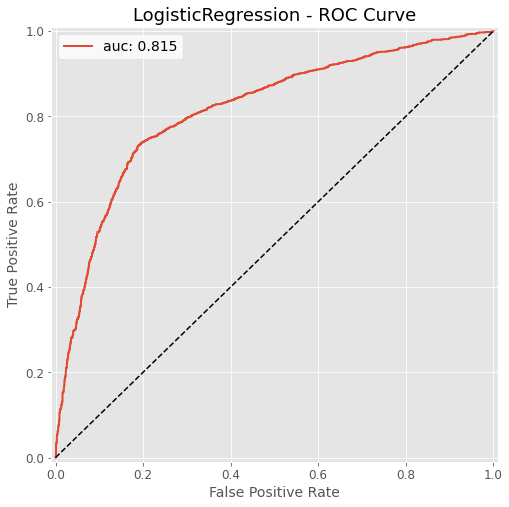

In [42]:
plot_roc_curve(fpr, tpr, round(auc_lr,3), lr_clf)

Concat prediction_proba for each model to test set, save test set

In [43]:
data_test['lr_pred_proba'] = pred_proba_lr[:, 1]

In [44]:
data_test.to_csv('E:/R code-LMX/R code for SEER for publishing paper/Data/test_set_with_predictions-lr.csv'.format(len(data_train)), index=False)

# XGBc

In [45]:
# Import model and retrain
with open('E:/R code-LMX/R code for SEER for publishing paper/Data/Xgbc_clf_final_round.pkl', 'rb') as f:
    Xgbc_clf = pickle.load(f)
Xgbc_clf.fit(data_train_X, data_train['anxietyanddepression'])

[09:07:33] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=45, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [46]:
accu_Xgbc = accuracy_score(data_test['anxietyanddepression'], Xgbc_clf.predict(data_test_X))

In [47]:
round(accu_Xgbc,3)

0.771

In [48]:
pd.crosstab(data_test['anxietyanddepression'], Xgbc_clf.predict(data_test_X))

col_0                    0     1
anxietyanddepression            
0                     1633   385
1                      531  1457

In [75]:
#pred_proba_Xgbc = Xgbc_clf.predict_proba(data_train_X)

In [76]:
#fpr, tpr, _ = roc_curve(data_train['anxietyanddepression'], pred_proba_Xgbc[:, 1])
#auc_Xgbc = roc_auc_score(data_train['anxietyanddepression'], pred_proba_Xgbc[:, 1])

In [49]:
pred_proba_Xgbc = Xgbc_clf.predict_proba(data_test_X)

In [50]:
fpr, tpr, _ = roc_curve(data_test['anxietyanddepression'], pred_proba_Xgbc[:, 1])
auc_Xgbc = roc_auc_score(data_test['anxietyanddepression'], pred_proba_Xgbc[:, 1])

In [51]:
round(auc_Xgbc,3)

0.819

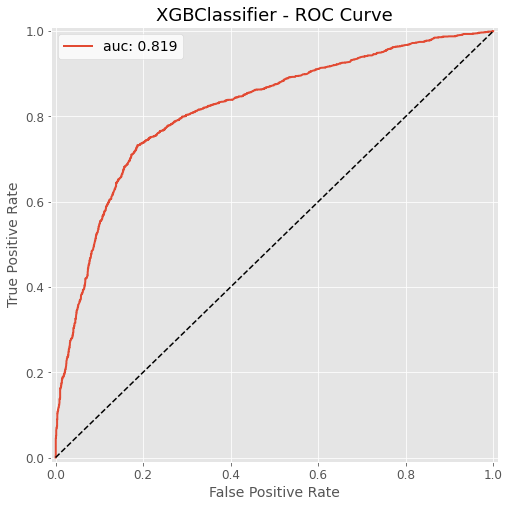

In [52]:
plot_roc_curve(fpr, tpr, round(auc_Xgbc,3), Xgbc_clf)

In [92]:
data_test['lr_pred_proba'] = pred_proba_Xgbc[:, 1]

In [93]:
data_test.to_csv('E:/R code-LMX/R code for SEER for publishing paper/Data/test_set_with_predictions-Xgbc.csv'.format(len(data_train)), index=False)

# Random forests model

In [137]:
# Import model and retrain
with open('E:/R code-LMX/R code for SEER for publishing paper/Data/rf_clf_final_round.pkl', 'rb') as f:
    rf_clf = pickle.load(f)
rf_clf.fit(data_train_X, data_train['anxietyanddepression'])

RandomForestClassifier(max_depth=42, max_features='log2', min_samples_leaf=25,
                       min_samples_split=80, n_estimators=32, random_state=42)

Accuracy scores

In [138]:
accu_rf = accuracy_score(data_test['anxietyanddepression'], rf_clf.predict(data_test_X))

In [139]:
round(accu_rf,3)

0.849

In [140]:
pd.crosstab(data_test['anxietyanddepression'], rf_clf.predict(data_test_X))

col_0                    0   1
anxietyanddepression          
0                     1279  34
1                      208  86

ROC and AUC

In [141]:
pred_proba_rf = rf_clf.predict_proba(data_test_X)

In [142]:
fpr, tpr, _ = roc_curve(data_test['anxietyanddepression'], pred_proba_rf[:, 1])
auc_rf = roc_auc_score(data_test['anxietyanddepression'], pred_proba_rf[:, 1])

In [143]:
round(auc_rf,3)

0.828

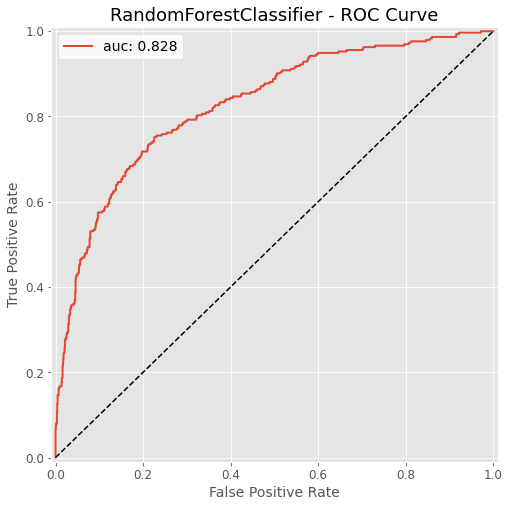

In [144]:
plot_roc_curve(fpr, tpr, round(auc_rf,3), rf_clf)

In [578]:
data_test['lr_pred_proba'] = pred_proba_rf[:, 1]

In [579]:
data_test.to_csv('E:/R code-LMX/R code for SEER for publishing paper/Data/test_set_with_predictions-Random forests model.csv'.format(len(data_train)), index=False)

# Gradient boosting machine model

In [371]:
# Import model and retrain
with open('E:/R code-LMX/R code for SEER for publishing paper/Data/gbm_clf_final_round.pkl', 'rb') as f:
    gbm_clf = pickle.load(f)
gbm_clf.fit(data_train_X, data_train['anxietyanddepression'])

GradientBoostingClassifier(max_features='auto', min_samples_leaf=4,
                           min_samples_split=8, random_state=42)

Accuracy scores

In [372]:
accu_gbm = accuracy_score(data_test['anxietyanddepression'], gbm_clf.predict(data_test_X))

In [373]:
round(accu_gbm,3)

0.772

In [374]:
pd.crosstab(data_test['anxietyanddepression'], gbm_clf.predict(data_test_X))

col_0                    0     1
anxietyanddepression            
0                     1637   381
1                      534  1454

ROC and AUC

In [375]:
pred_proba_gbm = gbm_clf.predict_proba(data_test_X)

In [376]:
fpr, tpr, _ = roc_curve(data_test['anxietyanddepression'], pred_proba_gbm[:, 1])
auc_gbm = roc_auc_score(data_test['anxietyanddepression'], pred_proba_gbm[:, 1])

In [131]:
pred_proba_gbm = gbm_clf.predict_proba(data_train_X)

In [132]:
fpr, tpr, _ = roc_curve(data_train['anxietyanddepression'], pred_proba_gbm[:, 1])
auc_gbm = roc_auc_score(data_train['anxietyanddepression'], pred_proba_gbm[:, 1])

In [377]:
round(auc_gbm,3)

0.82

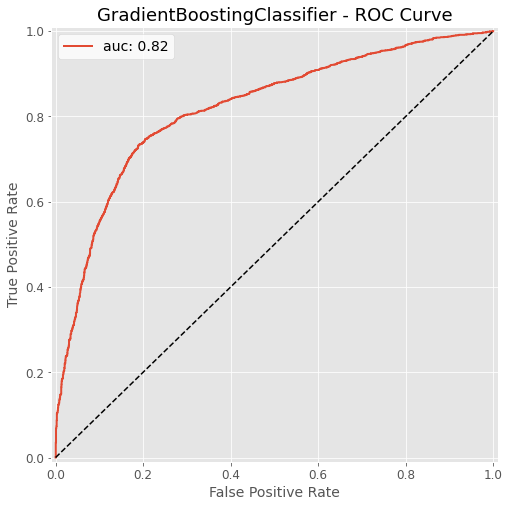

In [378]:
plot_roc_curve(fpr, tpr, round(auc_gbm,3), gbm_clf)

In [379]:
data_test['lr_pred_proba'] = pred_proba_gbm[:, 1]

In [380]:
data_test.to_csv('E:/R code-LMX/R code for SEER for publishing paper/Data/test_set_with_predictions-Gradient boosting machine model.csv'.format(len(data_train)), index=False)

# Support vector machine model

In [537]:
# Import model and retrain
with open('E:/R code-LMX/R code for SEER for publishing paper/Data/svc_clf_final_round.pkl', 'rb') as f:
    svc_clf = pickle.load(f)
svc_clf.fit(data_train_X, data_train['anxietyanddepression'])

SVC(C=0.03845401188473625, gamma=0.4753571532049581, kernel='linear',
    probability=True)

In [538]:
accu_svc = accuracy_score(data_test['anxietyanddepression'], svc_clf.predict(data_test_X))

In [539]:
round(accu_svc,3)

0.77

In [540]:
pd.crosstab(data_test['anxietyanddepression'], svc_clf.predict(data_test_X))

col_0                    0     1
anxietyanddepression            
0                     1627   391
1                      530  1458

In [541]:
pred_proba_svc = svc_clf.predict_proba(data_test_X) 

In [542]:
svc_clf.predict

<bound method BaseSVC.predict of SVC(C=0.03845401188473625, gamma=0.4753571532049581, kernel='linear',
    probability=True)>

In [543]:
fpr, tpr, _ = roc_curve(data_test['anxietyanddepression'], pred_proba_svc[:, 1])
auc_svc = roc_auc_score(data_test['anxietyanddepression'], pred_proba_svc[:, 1])

In [544]:
round(auc_svc,3)

0.759

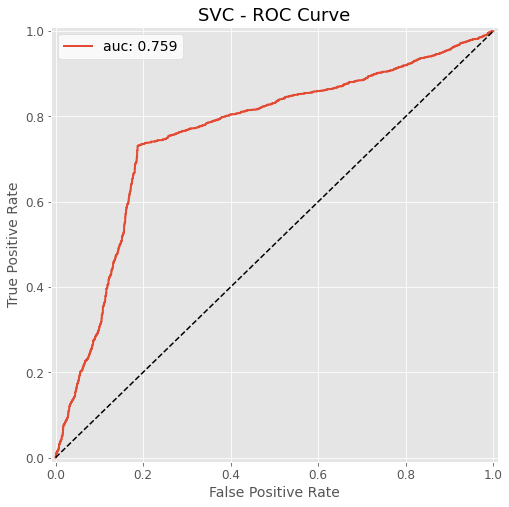

In [545]:
plot_roc_curve(fpr, tpr, round(auc_svc,3), svc_clf)

In [546]:
data_test['lr_pred_proba'] = pred_proba_svc[:, 1]

In [547]:
data_test.to_csv('E:/R code-LMX/R code for SEER for publishing paper/Data/test_set_with_predictions-Support vector machine model.csv'.format(len(data_train)), index=False)

# The ensemble model

In [551]:
# Import model and retrain
with open('E:/R code-LMX/R code for SEER for publishing paper/Data/ensemble_clf_final_round.pkl', 'rb') as f:
    ensemble_clf = pickle.load(f)
ensemble_clf.fit(data_train_X, data_train['anxietyanddepression'])

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=3,
                                                     max_features='log2',
                                                     min_samples_leaf=67,
                                                     min_samples_split=20,
                                                     n_estimators=16,
                                                     random_state=42)),
                             ('gbm',
                              GradientBoostingClassifier(max_features='auto',
                                                         min_samples_leaf=4,
                                                         min_samples_split=8,
                                                         random_state=42)),
                             ('svc',
                              SVC(C=0.03845401188473625,
                                  gamma=0.4753571532049581, kernel='linear',
                

In [552]:
accu_ensemble = accuracy_score(data_test['anxietyanddepression'], ensemble_clf.predict(data_test_X))

In [553]:
round(accu_ensemble,3)

0.77

In [554]:
pd.crosstab(data_test['anxietyanddepression'], ensemble_clf.predict(data_test_X))

col_0                    0     1
anxietyanddepression            
0                     1627   391
1                      530  1458

ROC and AUC

In [555]:
ensemble_clf.predict(data_test_X)

array([1, 1, 1, ..., 0, 1, 0], dtype=int64)

In [556]:
ensemble_clf.predict_proba(data_test_X)

array([[0.1446542 , 0.8553458 ],
       [0.20301206, 0.79698794],
       [0.25671497, 0.74328503],
       ...,
       [0.75628509, 0.24371491],
       [0.39299926, 0.60700074],
       [0.77171429, 0.22828571]])

In [557]:
pred_proba_ensemble = ensemble_clf.predict_proba(data_test_X)

In [558]:
fpr, tpr, _ = roc_curve(data_test['anxietyanddepression'], pred_proba_ensemble[:, 1])
auc_ensemble = roc_auc_score(data_test['anxietyanddepression'], pred_proba_ensemble[:, 1])

In [559]:
round(auc_ensemble,3)

0.814

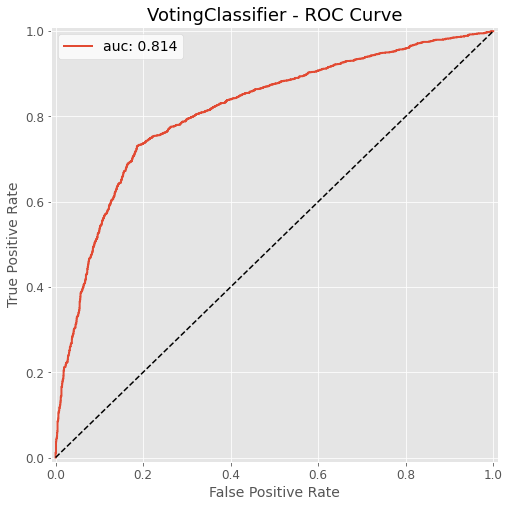

In [560]:
plot_roc_curve(fpr, tpr, round(auc_ensemble,3), ensemble_clf)

In [562]:
data_test['lr_pred_proba'] = pred_proba_ensemble[:, 1]

In [563]:
data_test.to_csv('E:/R code-LMX/R code for SEER for publishing paper/Data/test_set_with_predictions-The ensemble model.csv'.format(len(data_train)), index=False)

# H2O Deep Learner

In [39]:
model_path

'E:\\h2o_deep_learner_may31\\DeepLearning_grid_1_AutoML_2_20220504_122615_model_210'

In [40]:
# Use manual path if model_path is not defined
h2o_deep_learner = h2o.load_model('E:\\h2o_deep_learner_may31\\DeepLearning_grid_1_AutoML_2_20220504_122615_model_210')
h2o_deep_learner.train(x=x, y=y, training_frame=htrain)

deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_model_python_1651628456918_37594


Status of Neuron Layers: predicting anxietyanddepression, 2-class classification, bernoulli distribution, CrossEntropy loss, 42,402 weights/biases, 505.7 KB, 9,280 training samples, mini-batch size 1


layer  units       type dropout   l1   l2 mean_rate  rate_rms momentum  \
0        1      8      Input     0.0                                          
1        2    200  Rectifier     0.0  0.0  0.0  0.004286  0.002771      0.0   
2        3    200  Rectifier     0.0  0.0  0.0  0.054554   0.13957      0.0   
3        4      2    Softmax          0.0  0.0  0.007472  0.069403      0.0   

  mean_weight weight_rms mean_bias  bias_rms  
0                                             
1   -0.005075   0.102542  0.424963  0.039175  
2   -0.005699   0.071876   0.98763  0.012027  
3    0.009494   0.378321       0.0  0.000636



ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.07896483057776159
RMSE: 0.28100681589200216
LogLoss: 0.33308684401981997
Mean Per-Class Error: 0.12240512373943088
AUC: 0.9663579033118908
AUCPR: 0.9029954042629899
Gini: 0.9327158066237815

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0965963646424343: 


0      1   Error           Rate
0      0  717.0   17.0  0.0232   (17.0/734.0)
1      1   43.0  151.0  0.2216   (43.0/194.0)
2  Total  760.0  168.0  0.0647   (60.0/928.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric     threshold       value   idx
0                        max f1  9.659636e-02    0.834254  23.0
1                        max f2  2.126377e-02    0.882353  28.0
2                  max f0point5  9.659636e-02    0.871824  23.0
3                  max accuracy  9.659636e-02    0.935345  23.0
4                 max precision  9.999996e-01    1.000000   0.0
5                    max recall  1.167496e-04    1.000000  49.0
6               max specificity  9.999996e-01    1.000000   0.0
7              max absolute_mcc  9.659636e-02    0.797524  23.0
8    max min_per_class_accuracy  2.126377e-02    0.912807  28.0
9   max mean_per_class_accuracy  2.126377e-02    0.920321  28.0
10                      max tns  9.999996e-01  734.000000   0.0
11                      max fns  9.999996e-01  189.000000   0.0
12                      max fps  4.885614e-11  734.000000  95.0
13                      max tps  1.167496e-04  194.000000  49.0
14                      max tnr  9.999996e-01    1.000000   0.0
15                      max fnr  9.999996e-01    0.974227   0.0
16                      max fpr  4.885614e-11    1.000000  95.0
17                      max tpr  1.167496e-04    1.000000  49.0


Gains/Lift Table: Avg response rate: 20.91 %, avg score: 14.23 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.014009     9.994248e-01  4.783505   
1       2                  0.023707     9.993910e-01  4.783505   
2       3                  0.045259     9.965679e-01  4.783505   
3       4                  0.054957     9.942920e-01  4.783505   
4       5                  0.101293     9.287242e-01  4.561017   
5       6                  0.155172     1.675604e-01  3.635464   
6       7                  0.202586     3.287486e-02  2.283037   
7       8                  0.307112     6.270038e-03  1.430120   
8       9                  0.422414     4.643865e-04  0.357645   
9      10                  0.500000     1.216669e-04  0.000000   
10     11                  0.604526     6.948978e-06  0.295887   
11     12                  0.702586     7.436159e-07  0.000000   
12     13                  0.803879     3.223777e-07  0.000000   
13     14                  0.905172     6.361466e-08  0.000000   
14     15                  1.000000     4.885614e-11  0.000000   

    cumulative_lift  response_rate         score  cumulative_response_rate  \
0          4.783505       1.000000  9.996459e-01                  1.000000   
1          4.783505       1.000000  9.993910e-01                  1.000000   
2          4.783505       1.000000  9.965782e-01                  1.000000   
3          4.783505       1.000000  9.942920e-01                  1.000000   
4          4.681728       0.953488  9.657077e-01                  0.978723   
5          4.318442       0.760000  6.836588e-01                  0.902778   
6          3.842071       0.477273  8.311281e-02                  0.803191   
7          3.021161       0.298969  1.633205e-02                  0.631579   
8          2.294130       0.074766  1.765979e-03                  0.479592   
9          1.938144       0.000000  2.106653e-04                  0.405172   
10         1.654189       0.061856  4.294863e-05                  0.345811   
11         1.423313       0.000000  3.693454e-06                  0.297546   
12         1.243968       0.000000  3.956142e-07                  0.260054   
13         1.104762       0.000000  8.218793e-08                  0.230952   
14         1.000000       0.000000  7.790068e-09                  0.209052   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.999646      0.067010                 0.067010  378.350515   
1           0.999542      0.046392                 0.113402  378.350515   
2           0.998130      0.103093                 0.216495  378.350515   
3           0.997453      0.046392                 0.262887  378.350515   
4           0.982931      0.211340                 0.474227  356.101654   
5           0.879017      0.195876                 0.670103  263.546392   
6           0.692742      0.108247                 0.778351  128.303655   
7           0.462525      0.149485                 0.927835   43.012010   
8           0.336757      0.041237                 0.969072  -64.235475   
9           0.284534      0.000000                 0.969072 -100.000000   
10          0.235344      0.030928                 1.000000  -70.411308   
11          0.202497      0.000000                 1.000000 -100.000000   
12          0.176982      0.000000                 1.000000 -100.000000   
13          0.157177      0.000000                 1.000000 -100.000000   
14          0.142272      0.000000                 1.000000 -100.000000   

    cumulative_gain  kolmogorov_smirnov  
0        378.350515            0.067010  
1        378.350515            0.113402  
2        378.350515            0.216495  
3        378.350515            0.262887  
4        368.172845            0.471502  
5        331.844215            0.651030  
6        284.207063            0.727942  
7        202.116115            0.784783  
8        129.413002            0.691143  
9         93.814433            0.593050  
10        65.418895            0.50



Scoring History: 


timestamp    duration training_speed  epochs  iterations  \
0    2022-05-04 19:42:35   0.000 sec           None     0.0           0   
1    2022-05-04 19:42:35   0.175 sec   7798 obs/sec     1.0           1   
2    2022-05-04 19:42:36   1.048 sec   9606 obs/sec    10.0          10   

   samples  training_rmse  training_logloss  training_r2  training_auc  \
0      0.0            NaN               NaN          NaN           NaN   
1    928.0       0.403352          0.917411     0.016064      0.887648   
2   9280.0       0.281007          0.333087     0.522436      0.966358   

   training_pr_auc  training_lift  training_classification_error  
0              NaN            NaN                            NaN  
1         0.722151       4.783505                       0.118534  
2         0.902995       4.783505                       0.064655


Variable Importances: 


variable  relative_importance  scaled_importance  percentage
0      x16             1.000000           1.000000    0.136165
1       x6             0.976699           0.976699    0.132992
2       x2             0.975130           0.975130    0.132778
3       x5             0.948970           0.948970    0.129216
4      x15             0.922690           0.922690    0.125638
5       x1             0.884770           0.884770    0.120474
6       x9             0.827857           0.827857    0.112725
7       x7             0.807936           0.807936    0.110012

In [129]:
# Get predictions
h2o_deep_pred = h2o_deep_learner.predict(htest)

H2OResponseError: Server error water.exceptions.H2OKeyNotFoundArgumentException:
  Error: Object 'None' not found in function: predict for argument: model
  Request: POST /4/Predictions/models/None/frames/starv0_2.hex


In [88]:
# Convert to pandas df
h2o_deep_pred = h2o_deep_pred['p1'].as_data_frame()

In [89]:
h2o_deep_pred

p1
0    2.126377e-02
1    8.520417e-03
2    7.568999e-07
3    1.675604e-01
4    3.926114e-07
..            ...
110  1.750321e-04
111  7.047133e-08
112  6.569211e-03
113  3.770988e-07
114  9.965679e-01

[115 rows x 1 columns]

In [90]:
accu_h2o_deep = accuracy_score(data_test['anxietyanddepression'], round(h2o_deep_pred))
accu_h2o_deep

0.8347826086956521

In [91]:
##下面没有计算出来，有问题
pd.crosstab(data_test['anxietyanddepression'], round(h2o_deep_pred))

ValueError: Data must be 1-dimensional

In [92]:
fpr, tpr, _ = roc_curve(data_test['anxietyanddepression'], h2o_deep_pred)
auc_h2o_deep = roc_auc_score(data_test['anxietyanddepression'], h2o_deep_pred)

In [93]:
auc_h2o_deep

0.8582352941176471

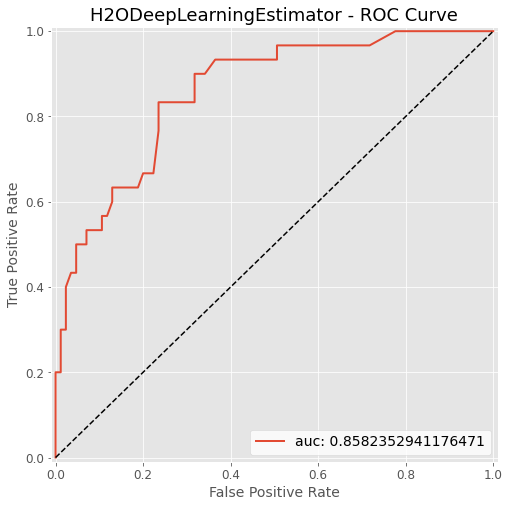

In [94]:
plot_roc_curve(fpr, tpr, auc_h2o_deep, h2o_deep_learner)

In [53]:
data_test['lr_pred_proba'] = h2o_deep_pred

In [54]:
data_test.to_csv('E:/test_set_with_predictions-h2o_deep_pred.csv'.format(len(data_train)), index=False)

Class breakdown per model
下面的代码中
[df.g == 0]，df.后面为y变量，此处为anxietyanddepression

In [88]:
def plot_class_breakdown_hist(df, var, var_name, plot_title, xlog=False, ylog=False, **histkwargs):
    df[var][df.anxietyanddepression == 0].hist(alpha=.5, label='Negative', color = "green", **histkwargs)
    df[var][df.anxietyanddepression == 1].hist(alpha=.5, label='Positive', color = "red", **histkwargs)
    plt.xlabel(var_name)
    plt.title(plot_title)
    if xlog:
        plt.xscale('log')
    if ylog:
        plt.yscale('log')
    plt.ylim(ymax=35, ymin=0)
    plt.legend()
    plt.savefig(var_name + ' Class Breakdown.png');

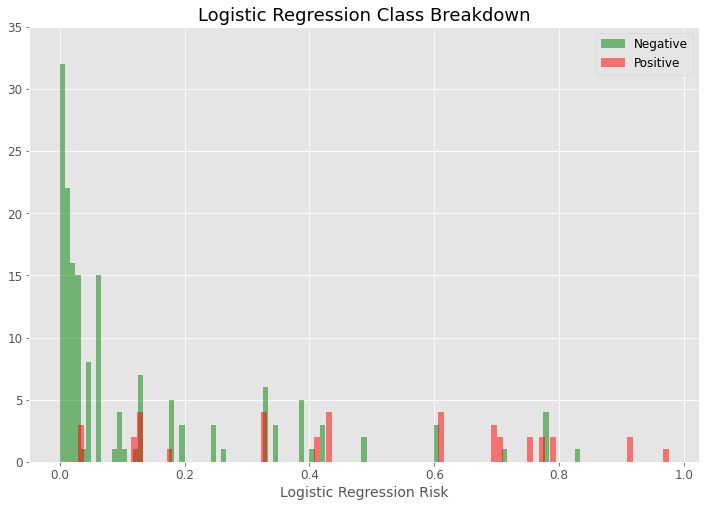

In [89]:
plot_class_breakdown_hist(data_test, 'lr_pred_proba', var_name='Logistic Regression Risk', 
                          plot_title='Logistic Regression Class Breakdown', bins=100)